In [1]:
import random
import json
import gym
from gym import spaces
import pandas as pd
import numpy as np
import datetime as dt
import cv2

import torch
from torch import nn
import torch.nn.functional as F
import collections
from torch.optim.lr_scheduler import StepLR
import os

from torch.cuda.amp import autocast as autocast, GradScaler
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Stock Code

In [4]:
stock_code = "0050"

# Env.

In [5]:
INITIAL_ACCOUNT_BALANCE = 10000 # 最初帳戶餘額


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df):
        super(StockTradingEnv, self).__init__()

        self.df = df
#         self.reward_range = (0, MAX_ACCOUNT_BALANCE)

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        # Box: 空間表示一個 n維框
        # Box 指的是整數維度的向量，用於連續的空間，如 DDPG 的 input/ output space
        self.action_space = spaces.Discrete(3)

        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(low=0, high=1, shape=(4, 28, 1), dtype=np.float16)

    def _next_observation(self):
        
        obs = np.array([
            df.loc[self.current_step - 27: self.current_step , 'Open'].values / max_value,
            df.loc[self.current_step - 27: self.current_step , 'High'].values / max_value,
            df.loc[self.current_step - 27: self.current_step , 'Low'].values / max_value,
            df.loc[self.current_step - 27: self.current_step , 'Close'].values / max_value,
        ])
        
        obs = obs.reshape(4, 28, 1)

        return obs

    def _take_action(self, action):
        # Set the current price to a random price within the time step
#         random.seed(seed)
#         self.current_price = random.uniform(self.df.loc[self.current_step, "Open"], self.df.loc[self.current_step, "Close"])
        self.current_price = self.df.loc[self.current_step, "Close"]
#         print(f'>>> Current Price: {self.current_price} <<<')

        action_type = action
#         amount = 1
#         print(f'>>> action_type: {action_type} <<<')
        # print(f'>>> amount: {amount} <<<')

        if action_type == 2:
            # Buy amount % of balance in shares
#             print("Buy")
            
            # print("cost_basis: ",self.cost_basis)
            prev_cost = self.cost_basis * self.shares_held
            additional_cost = 1 * self.current_price

            self.balance -= additional_cost
            self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + 1)
            self.shares_held += 1

        elif action_type == 0:
#             print("Sell")
            # Sell amount % of shares held
            shares_sold = 1
            self.balance += shares_sold * self.current_price
            self.shares_held -= shares_sold
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * self.current_price
            
        # else:
#             print("Hold")

        self.net_worth = self.balance + self.shares_held * self.current_price
        self.profit = self.net_worth - INITIAL_ACCOUNT_BALANCE

        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

        if self.shares_held == 0:
            self.cost_basis = 0

    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)

        spread = (self.df.loc[self.current_step + 1, "Close"]-self.df.loc[self.current_step, "Close"])
        action_value = action - 1
        
        charge = self.current_price * 0.001425 * 0.5
        tax = self.current_price * 0.001
        
        
        if action_value == 1:
            reward = spread * action_value - charge
        
        elif action_value == -1:
            reward = spread * action_value - charge - tax
        
        else:
            reward = self.current_price * 0.00585
            
#         print(f'Day: {self.current_step+1}')
#         print(f'Current: {self.current_price}')
#         print(f'Yeste: {self.df.loc[self.current_step-1, "Close"]}')
#         print(f'Tomor: {self.df.loc[self.current_step+1, "Close"]}')
#         print(f'Charge: {charge}')
#         print(f'Tax: {tax}')
#         print(f'Action Value: {action_value}')
#         print(f'Reward: {reward}')
#         print("===========================================")
        
        self.total_reward += reward
        
        if episode == (num_episodes-1):
            last_reward_list.append(reward)
            last_reward_sum_list.append(self.total_reward)
            last_profit_list.append(self.profit)

        self.current_step += 1
        done = False
        
#         if self.net_worth <= 0:
#             self.render()
            
#             done = True

#             save_result(self.balance, self.shares_held, self.total_shares_sold,
#                         self.cost_basis, self.total_sales_value, self.net_worth,
#                         self.max_net_worth, self.profit, lr, epsilon, reward)

        obs = self._next_observation()
        
        # 提前 done 檢測: 如果資料筆數下一輪會用完，這輪就要提前 done
        # 因為還有 _next_observation會抓下一輪，所以再 +1
        if len(self.df) < self.current_step + 2:
            # self.render()

            done = True
            
#             if self.net_worth > 0:
            save_result(self.balance, self.shares_held, self.total_shares_sold,
                        self.cost_basis, self.total_sales_value, self.net_worth,
                        self.max_net_worth, self.profit, lr, epsilon, self.total_reward)

        return obs, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE # 餘額
        self.net_worth = INITIAL_ACCOUNT_BALANCE # 淨值
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE # 最大淨值
        self.shares_held = 0 # 持股
        self.cost_basis = 0 # 成本基礎
        self.total_shares_sold = 0 # 總股票拋售量
        self.total_sales_value = 0 # 總銷售價值

        # Set the current step to 29th day
        self.current_step = 27
        self.total_reward = 0
        self.pre_profit = INITIAL_ACCOUNT_BALANCE # 前一個收益值
        
        

        return self._next_observation()

    def render(self, mode='human', close=False):
        # Render the environment to the screen

        print(f'Final Result:')
        print(f'Balance: {self.balance}')
        print(f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
        print(f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
        print(f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
        print(f'Profit: {self.profit}')
        print(f'Learning rate: {lr}')
        print(f'Epsilon: {epsilon}')
        print(f'Reward: {self.total_reward}')
        print("=====================================================")

# Data Preprocess

In [7]:
def data_preprocess(file_path):
    df = pd.read_csv(file_path)
    df.Date = pd.to_datetime(df.Date)
    df = df.sort_values('Date')
    
#     # 複製最後一筆到 dataframe 末端
#     last_df = df.iloc[-1]
#     df.loc[df.shape[0]] = last_df
    
    df.dropna(axis=0, how='any', inplace=True) # 移除 null 值 (axis=0 橫軸)
    
    df.reset_index(drop=True, inplace=True)
    
    return df

# CNN

In [8]:
class QNetworkCNN(nn.Module):
    def __init__(self, action_dim):
        super(QNetworkCNN, self).__init__()

        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [1, 84, 84]
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 128, 3, 1, 1),  # [128, 84, 84]
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, 3, 1, 1),  # [256, 84, 84]
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 512, 3, 1, 1),  # [512, 84, 84]
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(512*4*28, action_dim),
        )

    def forward(self, x):
        x = x.view((-1, 1, 4, 28))
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

# Memory

In [9]:
class Memory:
    def __init__(self, len):
        # deque: 一個類似 list 的容器，可以快速的在頭尾加入(append)元素與移除(pop)元素
        # maxlen: deque 的最大長度，如果不限制長度的話則為 None
        self.rewards = collections.deque(maxlen=len) 
        self.state = collections.deque(maxlen=len) 
        self.action = collections.deque(maxlen=len)
        self.is_done = collections.deque(maxlen=len)

    def update(self, state, action, reward, done):
        # if the episode is finished we do not save to new state. Otherwise we have more states per episode than rewards
        # and actions whcih leads to a mismatch when we sample from memory.
        if not done:
            self.state.append(state)
        self.action.append(action)
        self.rewards.append(reward)
        self.is_done.append(done)

    def sample(self, batch_size):
        """
        sample "batch_size" many (state, action, reward, next state, is_done) datapoints.
        """
        n = len(self.is_done)
        random.seed(seed)
        idx = random.sample(range(0, n-1), batch_size)
        
        return torch.Tensor(np.asarray(self.state))[idx].to(device), torch.LongTensor(np.asarray(self.action))[idx].to(device), \
               torch.Tensor(np.asarray(self.state))[1+np.asarray(idx)].to(device), torch.Tensor(np.asarray(self.rewards))[idx].to(device), \
               torch.Tensor(np.asarray(self.is_done))[idx].to(device)

    def reset(self):
        self.rewards.clear()
        self.state.clear()
        self.action.clear()
        self.is_done.clear()

# DDQN

In [10]:
class DDQN(object):
    def __init__(self):
        self.eval_QNet = eval_QNet
        self.targ_QNet = targ_QNet
        self.iter_num = 0

    def choose_action(self, state):
        state = torch.Tensor(state).to(device)
        with torch.no_grad():
          values = self.eval_QNet(state)

        if np.random.uniform() < epsilon:
            action = np.random.randint(0, env.action_space.n)

        else:
            action = np.argmax(values.cpu().detach().numpy())
        
        return action

    def learn(self, batch_size, optimizer, memory, gamma):
        if(self.iter_num % target_update_iter == 0):
            self.targ_QNet.load_state_dict(self.eval_QNet.state_dict())

        self.iter_num += 1

        # torch.Size([64, 84, 84, 3]) torch.Size([64]) torch.Size([64, 84, 84, 3]) torch.Size([64]) torch.Size([64])
        states, actions, next_states, rewards, is_done = memory.sample(batch_size)

        with autocast():
          Q_eval_values = self.eval_QNet(states)

          next_Q_eval_values = self.eval_QNet(next_states)
          next_Q_targ_values = self.targ_QNet(next_states)

          Q_eval = Q_eval_values.gather(1, actions.unsqueeze(1)).squeeze(1)
          Q_next = next_Q_targ_values.gather(1, torch.max(next_Q_eval_values, 1)[1].unsqueeze(1)).squeeze(1)

          expected_Q_value = rewards + gamma * Q_next * (1 - is_done)

          loss = (Q_eval - expected_Q_value.detach()).pow(2).mean()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

# Main

In [12]:
df = data_preprocess(stock_code + '_train.csv')

max_value = df[['Open', 'High', 'Low', 'Close']].max().max()

env = StockTradingEnv(df)
action_dim = env.action_space.n

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False

max_memory_size = 1000
memory = Memory(max_memory_size)

num_episodes = 1000
target_update_iter = 100 # 更新 target network
gamma = 0.99 # 獎勵折扣因子

epsilon = 0.5 # 在訓練期間採取隨機 Action 的機率
epsilon_decay = 0.995
epsilon_min = 0.01

lr = 1e-3 # Q-Network 的 learning rate

batch_size = 32

eval_QNet = QNetworkCNN(action_dim=env.action_space.n).to(device)
targ_QNet = QNetworkCNN(action_dim=env.action_space.n).to(device)

model = DDQN()
model.eval_QNet = eval_QNet
model.targ_QNet = targ_QNet

scaler = GradScaler()

optimizer = torch.optim.AdamW(model.eval_QNet.parameters(), lr=lr)


each_episode_steps = len(df) - 27

last_reward_list = []
last_reward_sum_list = []
last_profit_list = []

for episode in range(num_episodes):

    with tqdm(total = each_episode_steps - 1) as t:

        t.set_description(f'Episode {episode + 1}')
        
        state = env.reset()
        memory.state.append(state)

        done = False

        while not done:

            action = model.choose_action(state)
            state, reward, done, _ = env.step(action)
            
            memory.update(state, action, reward, done)
            
            if len(memory.is_done) > batch_size:
                model.learn(batch_size, optimizer, memory, gamma)

            t.update(1)
            
        env.render()

        # update learning rate and eps
        epsilon = max(epsilon*epsilon_decay, epsilon_min)

  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 25588.810036
Shares held: -183 (Total sold: 589)
Avg cost for held shares: -4520193.588688958 (Total sales value: 49196.110081000006)
Net worth: -1037.689964000001 (Max net worth: 11264.909592999993)
Profit: -11037.689964000001
Learning rate: 0.001
Epsilon: 0.5
Reward: 237.674383253775


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8455.290044999994
Shares held: -7 (Total sold: 338)
Avg cost for held shares: -752910324.0290633 (Total sales value: 28046.130061000003)
Net worth: 7436.790044999994 (Max net worth: 10485.839897999993)
Profit: -2563.2099550000057
Learning rate: 0.001
Epsilon: 0.4975
Reward: 454.79917709533794


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 21081.500009000003
Shares held: -104 (Total sold: 407)
Avg cost for held shares: -187760385.8435015 (Total sales value: 36988.50000799999)
Net worth: 5949.500009000003 (Max net worth: 11004.899827999998)
Profit: -4050.499990999997
Learning rate: 0.001
Epsilon: 0.4950125
Reward: 417.31765548271204


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17490.51004800002
Shares held: -73 (Total sold: 448)
Avg cost for held shares: -307267346.40377367 (Total sales value: 40201.440024999996)
Net worth: 6869.010048000018 (Max net worth: 10310.209938000022)
Profit: -3130.9899519999817
Learning rate: 0.001
Epsilon: 0.4925374375
Reward: 355.88907412352467


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -5833.3301480000155
Shares held: 252 (Total sold: 439)
Avg cost for held shares: 91.56869930985569 (Total sales value: 40280.24992400001)
Net worth: 30832.669851999985 (Max net worth: 30946.069095999985)
Profit: 20832.669851999985
Learning rate: 0.001
Epsilon: 0.49007475031250003
Reward: 148.39300501389977


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15062.430062
Shares held: -74 (Total sold: 427)
Avg cost for held shares: -531686.1931281118 (Total sales value: 35065.530042)
Net worth: 4295.430061999999 (Max net worth: 10336.729803999999)
Profit: -5704.569938000001
Learning rate: 0.001
Epsilon: 0.48762437656093754
Reward: 360.3394227252749


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 2056.0900140000135
Shares held: 83 (Total sold: 324)
Avg cost for held shares: 113.55262907439314 (Total sales value: 27676.140006999998)
Net worth: 14132.590014000014 (Max net worth: 14169.939765000014)
Profit: 4132.590014000014
Learning rate: 0.001
Epsilon: 0.48518625467813287
Reward: 411.1906034046506


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10393.25996799999
Shares held: -20 (Total sold: 340)
Avg cost for held shares: -95830011130.69516 (Total sales value: 29425.830033999984)
Net worth: 7483.259967999989 (Max net worth: 10234.110169999994)
Profit: -2516.7400320000106
Learning rate: 0.001
Epsilon: 0.4827603234047422
Reward: 494.67889459640014


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 35712.28000800001
Shares held: -306 (Total sold: 629)
Avg cost for held shares: -784888.9374819095 (Total sales value: 53633.26003799995)
Net worth: -8810.719991999991 (Max net worth: 12745.229204999989)
Profit: -18810.71999199999
Learning rate: 0.001
Epsilon: 0.4803465217877185
Reward: 284.99497280239984


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 56965.96995600001
Shares held: -538 (Total sold: 797)
Avg cost for held shares: -30465.993761919563 (Total sales value: 69965.87996599998)
Net worth: -21313.030043999992 (Max net worth: 14285.868705)
Profit: -31313.030043999992
Learning rate: 0.001
Epsilon: 0.47794478917877986
Reward: 199.06395560314945


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 53853.76992799998
Shares held: -514 (Total sold: 824)
Avg cost for held shares: -1243.0522540242046 (Total sales value: 71026.34998300005)
Net worth: -20933.23007200002 (Max net worth: 13313.518806000022)
Profit: -30933.23007200002
Learning rate: 0.001
Epsilon: 0.47555506523288593
Reward: 121.09097192927486


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 39489.57997400004
Shares held: -404 (Total sold: 758)
Avg cost for held shares: -372.6585185394374 (Total sales value: 61221.53003199997)
Net worth: -19292.420025999963 (Max net worth: 11410.928782000017)
Profit: -29292.420025999963
Learning rate: 0.001
Epsilon: 0.4731772899067215
Reward: 206.33916616402533


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 33067.61005800003
Shares held: -297 (Total sold: 595)
Avg cost for held shares: -971.1501401388273 (Total sales value: 49210.97006899992)
Net worth: -10145.889941999973 (Max net worth: 11537.709256999991)
Profit: -20145.889941999973
Learning rate: 0.001
Epsilon: 0.47081140345718786
Reward: 290.5941700676501


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 49733.890042999985
Shares held: -422 (Total sold: 726)
Avg cost for held shares: -32255.102595248103 (Total sales value: 66329.48003799998)
Net worth: -11667.109957000015 (Max net worth: 13438.939203999984)
Profit: -21667.109957000015
Learning rate: 0.001
Epsilon: 0.46845734643990194
Reward: 110.61763815708713


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 55334.72001800004
Shares held: -557 (Total sold: 835)
Avg cost for held shares: -2238.3783817128146 (Total sales value: 69440.81004400006)
Net worth: -25708.779981999956 (Max net worth: 12831.518679000026)
Profit: -35708.77998199996
Learning rate: 0.001
Epsilon: 0.46611505970770245
Reward: 195.34538253327486


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 57588.679969999954
Shares held: -521 (Total sold: 789)
Avg cost for held shares: -691.9444498764684 (Total sales value: 70977.47997599996)
Net worth: -18216.820030000046 (Max net worth: 13014.128928000002)
Profit: -28216.820030000046
Learning rate: 0.001
Epsilon: 0.4637844844091639
Reward: 152.27169092877517


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 69187.6501129999
Shares held: -674 (Total sold: 975)
Avg cost for held shares: -662.2957509288177 (Total sales value: 85554.68009899995)
Net worth: -28879.349887000106 (Max net worth: 13781.698553000002)
Profit: -38879.349887000106
Learning rate: 0.001
Epsilon: 0.4614655619871181
Reward: -25.892902245162325


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 56237.15997500007
Shares held: -611 (Total sold: 972)
Avg cost for held shares: -203.92519101108087 (Total sales value: 80893.63997200009)
Net worth: -32663.340024999932 (Max net worth: 13889.408225000065)
Profit: -42663.34002499993
Learning rate: 0.001
Epsilon: 0.4591582341771825
Reward: 22.35636701808727


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 44423.05013500002
Shares held: -367 (Total sold: 781)
Avg cost for held shares: -130978.90246967998 (Total sales value: 69956.67011200002)
Net worth: -8975.44986499998 (Max net worth: 11994.299443999984)
Profit: -18975.44986499998
Learning rate: 0.001
Epsilon: 0.4568624430062966
Reward: 75.79133246558767


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 46075.88997899999
Shares held: -419 (Total sold: 754)
Avg cost for held shares: -6128.207229541285 (Total sales value: 64955.13999899999)
Net worth: -14888.610021000008 (Max net worth: 12524.239153999923)
Profit: -24888.610021000008
Learning rate: 0.001
Epsilon: 0.4545781307912651
Reward: 198.84459678796256


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 62066.519899999985
Shares held: -599 (Total sold: 889)
Avg cost for held shares: -701.4943827300447 (Total sales value: 77597.55001699996)
Net worth: -25087.980100000015 (Max net worth: 13580.36858499999)
Profit: -35087.980100000015
Learning rate: 0.001
Epsilon: 0.4523052401373088
Reward: 46.06894114027501


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 70465.63993500001
Shares held: -712 (Total sold: 991)
Avg cost for held shares: -176.36493060052382 (Total sales value: 85492.23994700002)
Net worth: -33130.360064999986 (Max net worth: 14814.58819400004)
Profit: -43130.360064999986
Learning rate: 0.001
Epsilon: 0.45004371393662224
Reward: 4.535782108712511


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 68433.66017000002
Shares held: -711 (Total sold: 1021)
Avg cost for held shares: -227.4767379271655 (Total sales value: 86530.450129)
Net worth: -35016.83982999998 (Max net worth: 14282.808246999994)
Profit: -45016.83982999998
Learning rate: 0.001
Epsilon: 0.44779349536693913
Reward: 3.1864990801502993


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 66220.49004100003
Shares held: -697 (Total sold: 1006)
Avg cost for held shares: -363.5106196259864 (Total sales value: 84710.53006000008)
Net worth: -35193.00995899997 (Max net worth: 14470.48825200004)
Profit: -45193.00995899997
Learning rate: 0.001
Epsilon: 0.4455545278901044
Reward: 24.148613083212428


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 63305.77976600018
Shares held: -634 (Total sold: 931)
Avg cost for held shares: -819.0394104579668 (Total sales value: 79792.74990100018)
Net worth: -28941.22023399982 (Max net worth: 14609.428323000117)
Profit: -38941.22023399982
Learning rate: 0.001
Epsilon: 0.4433267552506539
Reward: 125.77412964939955


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 66227.42014100011
Shares held: -696 (Total sold: 960)
Avg cost for held shares: -280.5391934042701 (Total sales value: 79905.75007900006)
Net worth: -35040.57985899989 (Max net worth: 14444.018251000067)
Profit: -45040.57985899989
Learning rate: 0.001
Epsilon: 0.44111012147440065
Reward: 90.94168409608754


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 72614.07013699992
Shares held: -756 (Total sold: 1028)
Avg cost for held shares: -179.85317766005303 (Total sales value: 86854.40009600006)
Net worth: -37383.929863000085 (Max net worth: 14764.018165000001)
Profit: -47383.929863000085
Learning rate: 0.001
Epsilon: 0.43890457086702866
Reward: 14.354321204712496


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 58509.840114
Shares held: -629 (Total sold: 921)
Avg cost for held shares: -680.8948857249968 (Total sales value: 74974.42004800004)
Net worth: -33009.659886 (Max net worth: 13931.73830400002)
Profit: -43009.659886
Learning rate: 0.001
Epsilon: 0.43671004801269353
Reward: 139.020169856775


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 53679.17000799998
Shares held: -519 (Total sold: 829)
Avg cost for held shares: -2227.9327486831876 (Total sales value: 71340.27002299995)
Net worth: -21835.32999200002 (Max net worth: 14265.768597999955)
Profit: -31835.32999200002
Learning rate: 0.001
Epsilon: 0.4345264977726301
Reward: 54.90099238927497


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 58778.19999500004
Shares held: -583 (Total sold: 895)
Avg cost for held shares: -1179.9084231266727 (Total sales value: 76692.13998500006)
Net worth: -26048.30000499996 (Max net worth: 14206.19845800002)
Profit: -36048.30000499996
Learning rate: 0.001
Epsilon: 0.4323538652837669
Reward: 48.178424465712546


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 65597.82017099997
Shares held: -675 (Total sold: 986)
Avg cost for held shares: -403.20711689103393 (Total sales value: 84013.86013)
Net worth: -32614.67982900003 (Max net worth: 14164.368369000003)
Profit: -42614.67982900003
Learning rate: 0.001
Epsilon: 0.4301920959573481
Reward: 21.162878822587587


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 71432.53000300005
Shares held: -719 (Total sold: 1007)
Avg cost for held shares: -626.6101027636628 (Total sales value: 86946.0000010001)
Net worth: -33181.96999699995 (Max net worth: 14204.228324000025)
Profit: -43181.96999699995
Learning rate: 0.001
Epsilon: 0.42804113547756134
Reward: 46.86668941721255


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 70409.97992900007
Shares held: -701 (Total sold: 994)
Avg cost for held shares: -404.37992246807937 (Total sales value: 85220.36998300008)
Net worth: -31585.520070999934 (Max net worth: 14760.878253000075)
Profit: -41585.52007099993
Learning rate: 0.001
Epsilon: 0.4259009298001735
Reward: -2.2393574391624655


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 67951.23988700008
Shares held: -716 (Total sold: 1014)
Avg cost for held shares: -362.01277538025965 (Total sales value: 85326.62996200015)
Net worth: -36226.760112999924 (Max net worth: 14577.188093000077)
Profit: -46226.760112999924
Learning rate: 0.001
Epsilon: 0.42377142515117266
Reward: -10.285846168162692


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 58023.319835000024
Shares held: -600 (Total sold: 907)
Avg cost for held shares: -228.92330626369815 (Total sales value: 76248.89992900004)
Net worth: -29276.680164999976 (Max net worth: 13930.918267999972)
Profit: -39276.680164999976
Learning rate: 0.001
Epsilon: 0.4216525680254168
Reward: 109.1150362067122


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 51215.460054000025
Shares held: -499 (Total sold: 835)
Avg cost for held shares: -884.4030851757583 (Total sales value: 71075.44003700002)
Net worth: -21389.039945999975 (Max net worth: 13462.458724000004)
Profit: -31389.039945999975
Learning rate: 0.001
Epsilon: 0.4195443051852897
Reward: 96.94384336840008


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 41745.290024
Shares held: -396 (Total sold: 725)
Avg cost for held shares: -1146.0569665906278 (Total sales value: 61523.48006200001)
Net worth: -15872.709975999998 (Max net worth: 12078.689056000028)
Profit: -25872.709976
Learning rate: 0.001
Epsilon: 0.4174465836593632
Reward: 231.4971931934003


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 34122.270015999966
Shares held: -318 (Total sold: 677)
Avg cost for held shares: -592.1960699238666 (Total sales value: 56588.74003099996)
Net worth: -12146.729984000034 (Max net worth: 11561.919166999996)
Profit: -22146.729984000034
Learning rate: 0.001
Epsilon: 0.4153593507410664
Reward: 246.68433432877504


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 26014.05994800001
Shares held: -181 (Total sold: 519)
Avg cost for held shares: -1869438.9352943162 (Total sales value: 46658.29997900001)
Net worth: -321.4400519999908 (Max net worth: 10889.159632000014)
Profit: -10321.44005199999
Learning rate: 0.001
Epsilon: 0.4132825539873611
Reward: 327.7616004920251


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 36529.49998800007
Shares held: -349 (Total sold: 709)
Avg cost for held shares: -1093.3827369940461 (Total sales value: 59612.70002600004)
Net worth: -14250.000011999931 (Max net worth: 12553.598951000062)
Profit: -24250.00001199993
Learning rate: 0.001
Epsilon: 0.4112161412174243
Reward: 179.25838009065015


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 34510.139900999966
Shares held: -295 (Total sold: 602)
Avg cost for held shares: -1920.8557420041132 (Total sales value: 52305.169952999924)
Net worth: -8412.360099000034 (Max net worth: 11747.78915799997)
Profit: -18412.360099000034
Learning rate: 0.001
Epsilon: 0.40916006051133713
Reward: 271.78512180083754


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 31856.509890000034
Shares held: -287 (Total sold: 632)
Avg cost for held shares: -12693.869096410368 (Total sales value: 54090.799952999994)
Net worth: -9901.990109999966 (Max net worth: 12016.759059000015)
Profit: -19901.990109999966
Learning rate: 0.001
Epsilon: 0.40711426020878044
Reward: 339.4685581036499


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 42350.32000100002
Shares held: -400 (Total sold: 723)
Avg cost for held shares: -2511.3878397093645 (Total sales value: 61316.26002600002)
Net worth: -15849.679998999978 (Max net worth: 13237.868818000014)
Profit: -25849.679998999978
Learning rate: 0.001
Epsilon: 0.4050786889077365
Reward: 177.40485242596264


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 26040.71994999997
Shares held: -227 (Total sold: 640)
Avg cost for held shares: -1882.7907074537445 (Total sales value: 53307.35998999995)
Net worth: -6987.78005000003 (Max net worth: 11622.669263999982)
Profit: -16987.78005000003
Learning rate: 0.001
Epsilon: 0.40305329546319785
Reward: 228.47869009977472


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 23113.659950999983
Shares held: -172 (Total sold: 610)
Avg cost for held shares: -59136.0987870583 (Total sales value: 51924.740006999986)
Net worth: -1912.3400490000167 (Max net worth: 11872.609411999974)
Profit: -11912.340049000017
Learning rate: 0.001
Epsilon: 0.40103802898588187
Reward: 194.53935711621273


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 29564.109891999953
Shares held: -251 (Total sold: 646)
Avg cost for held shares: -7826.649842989584 (Total sales value: 54765.73996900001)
Net worth: -6956.390108000047 (Max net worth: 11916.70925799997)
Profit: -16956.390108000047
Learning rate: 0.001
Epsilon: 0.3990328388409525
Reward: 209.70125339077515


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 34060.58992200003
Shares held: -327 (Total sold: 752)
Avg cost for held shares: -2493.281152848968 (Total sales value: 61722.97999499998)
Net worth: -13517.910077999972 (Max net worth: 12319.288911000021)
Profit: -23517.91007799997
Learning rate: 0.001
Epsilon: 0.3970376746467477
Reward: 159.64841022040008


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9009.639957999996
Shares held: 12 (Total sold: 416)
Avg cost for held shares: 139.90834358273193 (Total sales value: 37108.920024000014)
Net worth: 10755.639957999996 (Max net worth: 10836.390033000003)
Profit: 755.6399579999961
Learning rate: 0.001
Epsilon: 0.39505248627351397
Reward: 337.14516417202475


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19267.029984000015
Shares held: -124 (Total sold: 492)
Avg cost for held shares: -14879.95529886989 (Total sales value: 41857.499989)
Net worth: 1225.0299840000152 (Max net worth: 10380.129644000022)
Profit: -8774.970015999985
Learning rate: 0.001
Epsilon: 0.3930772238421464
Reward: 321.5356602120248


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 22468.390025
Shares held: -123 (Total sold: 481)
Avg cost for held shares: -795082.6801910136 (Total sales value: 43191.83006600002)
Net worth: 4571.890025000001 (Max net worth: 10774.989786999999)
Profit: -5428.109974999999
Learning rate: 0.001
Epsilon: 0.3911118377229357
Reward: 339.69715614346234


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13586.709924999997
Shares held: -63 (Total sold: 442)
Avg cost for held shares: -494031.8459677841 (Total sales value: 38389.950023999976)
Net worth: 4420.209924999997 (Max net worth: 10229.850032000002)
Profit: -5579.790075000003
Learning rate: 0.001
Epsilon: 0.389156278534321
Reward: 365.31757608046223


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7828.060012999993
Shares held: 38 (Total sold: 477)
Avg cost for held shares: 125.96734766021585 (Total sales value: 42925.950042000004)
Net worth: 13357.060012999993 (Max net worth: 13468.510039999992)
Profit: 3357.060012999993
Learning rate: 0.001
Epsilon: 0.3872104971416494
Reward: 251.86562177871278


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 28544.669918999996
Shares held: -213 (Total sold: 678)
Avg cost for held shares: -38147834.59700746 (Total sales value: 59073.63997099999)
Net worth: -2446.8300810000037 (Max net worth: 12442.519416)
Profit: -12446.830081000004
Learning rate: 0.001
Epsilon: 0.38527444465594113
Reward: 124.3619750397122


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 29530.350129999977
Shares held: -268 (Total sold: 694)
Avg cost for held shares: -35627.79768362066 (Total sales value: 58646.85008899996)
Net worth: -9463.649870000023 (Max net worth: 12706.449200999967)
Profit: -19463.649870000023
Learning rate: 0.001
Epsilon: 0.38334807243266145
Reward: 172.71909150765018


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16769.240082999986
Shares held: -93 (Total sold: 676)
Avg cost for held shares: -251402.49761336244 (Total sales value: 58172.93005899997)
Net worth: 3237.740082999986 (Max net worth: 11425.839674999985)
Profit: -6762.259917000014
Learning rate: 0.001
Epsilon: 0.3814313320704981
Reward: 40.81852624796265


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14308.93986099999
Shares held: -62 (Total sold: 645)
Avg cost for held shares: -130034464456.84322 (Total sales value: 54851.98998599996)
Net worth: 5287.93986099999 (Max net worth: 10713.339713000005)
Profit: -4712.06013900001
Learning rate: 0.001
Epsilon: 0.3795241754101456
Reward: 103.2306605722121


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3134.1400199999985
Shares held: 55 (Total sold: 543)
Avg cost for held shares: 132.14188870022033 (Total sales value: 46217.060047000006)
Net worth: 11136.640019999999 (Max net worth: 11161.839852)
Profit: 1136.640019999999
Learning rate: 0.001
Epsilon: 0.37762655453309485
Reward: 164.264724004025


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -10168.020040000007
Shares held: 254 (Total sold: 447)
Avg cost for held shares: 100.21090739498933 (Total sales value: 40275.24999299999)
Net worth: 26788.979959999993 (Max net worth: 26903.72919499999)
Profit: 16788.979959999993
Learning rate: 0.001
Epsilon: 0.3757384217604294
Reward: 143.20739362302515


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -123.28988999999444
Shares held: 120 (Total sold: 467)
Avg cost for held shares: 116.01009439913396 (Total sales value: 41364.90003600002)
Net worth: 17336.710110000007 (Max net worth: 17391.159747000005)
Profit: 7336.710110000007
Learning rate: 0.001
Epsilon: 0.3738597296516272
Reward: 274.0747063750255


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8137.959961000009
Shares held: 30 (Total sold: 439)
Avg cost for held shares: 132.75321613825335 (Total sales value: 39391.35001600001)
Net worth: 12502.959961000008 (Max net worth: 12516.90986800001)
Profit: 2502.9599610000078
Learning rate: 0.001
Epsilon: 0.3719904310033691
Reward: 290.0754385547125


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16600.089991999983
Shares held: -105 (Total sold: 590)
Avg cost for held shares: -1964186.8410051928 (Total sales value: 50323.360055999976)
Net worth: 1322.5899919999829 (Max net worth: 10878.189558999997)
Profit: -8677.410008000017
Learning rate: 0.001
Epsilon: 0.37013047884835226
Reward: 189.84346606815015


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -1668.6000540000005
Shares held: 137 (Total sold: 457)
Avg cost for held shares: 110.68813067933434 (Total sales value: 40230.35001299999)
Net worth: 18264.899945999998 (Max net worth: 18326.999532)
Profit: 8264.899945999998
Learning rate: 0.001
Epsilon: 0.3682798264541105
Reward: 251.6289304986504


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14634.979805999968
Shares held: -60 (Total sold: 565)
Avg cost for held shares: -807407.3783264811 (Total sales value: 48799.62991000002)
Net worth: 5904.979805999968 (Max net worth: 10403.329707999977)
Profit: -4095.0201940000316
Learning rate: 0.001
Epsilon: 0.36643842732183995
Reward: 215.8699377847749


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5374.43993699999
Shares held: 51 (Total sold: 568)
Avg cost for held shares: 126.43822024586842 (Total sales value: 49491.40999399996)
Net worth: 12794.93993699999 (Max net worth: 12818.33978099999)
Profit: 2794.93993699999
Learning rate: 0.001
Epsilon: 0.3646062351852308
Reward: 161.1264832079627


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12269.429966999996
Shares held: -21 (Total sold: 569)
Avg cost for held shares: -1676.5170661831385 (Total sales value: 50165.159986000006)
Net worth: 9213.929966999996 (Max net worth: 10285.500039999997)
Profit: -786.0700330000036
Learning rate: 0.001
Epsilon: 0.36278320400930464
Reward: 137.12809264283752


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -5202.020076000006
Shares held: 179 (Total sold: 442)
Avg cost for held shares: 107.8528525633604 (Total sales value: 39590.08996600001)
Net worth: 20842.479923999992 (Max net worth: 20923.47938399999)
Profit: 10842.479923999992
Learning rate: 0.001
Epsilon: 0.3609692879892581
Reward: 215.34454976815005


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 25473.970004
Shares held: -188 (Total sold: 641)
Avg cost for held shares: -755620.0621454963 (Total sales value: 55773.76002599999)
Net worth: -1880.0299960000011 (Max net worth: 10753.069538999995)
Profit: -11880.029996000001
Learning rate: 0.001
Epsilon: 0.3591644415493118
Reward: 214.36150507065003


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14637.419869999976
Shares held: -56 (Total sold: 591)
Avg cost for held shares: -62721343.113559544 (Total sales value: 50986.319908999954)
Net worth: 6489.419869999976 (Max net worth: 10308.050005999992)
Profit: -3510.580130000024
Learning rate: 0.001
Epsilon: 0.3573686193415653
Reward: 179.77912146889992


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12578.830001999995
Shares held: -74 (Total sold: 574)
Avg cost for held shares: -322489.2553645322 (Total sales value: 47912.479992000015)
Net worth: 1811.8300019999951 (Max net worth: 10369.950058000006)
Profit: -8188.169998000005
Learning rate: 0.001
Epsilon: 0.35558177624485743
Reward: 220.85771028777498


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6995.709992999995
Shares held: 32 (Total sold: 458)
Avg cost for held shares: 135.4303088664803 (Total sales value: 40421.580017000015)
Net worth: 11651.709992999995 (Max net worth: 11666.109896999995)
Profit: 1651.709992999995
Learning rate: 0.001
Epsilon: 0.3538038673636331
Reward: 272.28752337558774


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 2960.909951999989
Shares held: 75 (Total sold: 483)
Avg cost for held shares: 126.21861339356239 (Total sales value: 42602.15997500002)
Net worth: 13873.409951999989 (Max net worth: 13907.609723999989)
Profit: 3873.409951999989
Learning rate: 0.001
Epsilon: 0.35203484802681495
Reward: 192.27821919977544


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5809.45993400001
Shares held: 53 (Total sold: 497)
Avg cost for held shares: 130.4380089834753 (Total sales value: 43953.229949)
Net worth: 13520.95993400001 (Max net worth: 13544.80977500001)
Profit: 3520.9599340000095
Learning rate: 0.001
Epsilon: 0.35027467378668087
Reward: 227.89805907389984


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7636.339946999992
Shares held: 27 (Total sold: 467)
Avg cost for held shares: 135.66907878252343 (Total sales value: 41392.57999400001)
Net worth: 11564.839946999993 (Max net worth: 11576.989865999993)
Profit: 1564.8399469999931
Learning rate: 0.001
Epsilon: 0.3485233004177475
Reward: 242.3462207735879


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9444.339827999986
Shares held: 22 (Total sold: 500)
Avg cost for held shares: 132.57590149043048 (Total sales value: 44858.389893000036)
Net worth: 12645.339827999986 (Max net worth: 12692.339917999987)
Profit: 2645.3398279999856
Learning rate: 0.001
Epsilon: 0.34678068391565875
Reward: 175.1366331692753


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10768.90984399999
Shares held: -21 (Total sold: 585)
Avg cost for held shares: -190304913378.77518 (Total sales value: 51210.82993399997)
Net worth: 7713.409843999991 (Max net worth: 10495.909778)
Profit: -2286.5901560000093
Learning rate: 0.001
Epsilon: 0.34504678049608045
Reward: 150.4307033201498


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11669.019925999943
Shares held: -65 (Total sold: 592)
Avg cost for held shares: -116469.65312124506 (Total sales value: 49430.69998700001)
Net worth: 2211.5199259999426 (Max net worth: 10977.519494999953)
Profit: -7788.480074000057
Learning rate: 0.001
Epsilon: 0.34332154659360004
Reward: 119.50218323464973


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10140.509953000004
Shares held: -26 (Total sold: 585)
Avg cost for held shares: -3416626119.0719066 (Total sales value: 50116.63001999996)
Net worth: 6357.509953000004 (Max net worth: 10330.459805000011)
Profit: -3642.4900469999957
Learning rate: 0.001
Epsilon: 0.34160493886063203
Reward: 148.57245482071252


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 25638.270096999946
Shares held: -208 (Total sold: 630)
Avg cost for held shares: -223297.58460917723 (Total sales value: 53931.59003599996)
Net worth: -4625.729903000054 (Max net worth: 11094.819476999948)
Profit: -14625.729903000054
Learning rate: 0.001
Epsilon: 0.3398969141663289
Reward: 229.89035453971243


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 30191.39000900002
Shares held: -279 (Total sold: 722)
Avg cost for held shares: -52029.170608049615 (Total sales value: 60217.93001599996)
Net worth: -10403.10999099998 (Max net worth: 12360.98911699999)
Profit: -20403.10999099998
Learning rate: 0.001
Epsilon: 0.33819742959549726
Reward: 175.24547274471237


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9129.31996
Shares held: -28 (Total sold: 511)
Avg cost for held shares: -3183255.818991771 (Total sales value: 43442.99998399998)
Net worth: 5055.319960000001 (Max net worth: 10303.519660999995)
Profit: -4944.680039999999
Learning rate: 0.001
Epsilon: 0.33650644244751976
Reward: 305.55154375015013


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14958.300013999999
Shares held: -66 (Total sold: 531)
Avg cost for held shares: -7412030.82091468 (Total sales value: 45770.020026000006)
Net worth: 5355.300013999999 (Max net worth: 10299.049755999993)
Profit: -4644.699986000001
Learning rate: 0.001
Epsilon: 0.3348239102352822
Reward: 305.87524326127516


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -1156.1000700000134
Shares held: 119 (Total sold: 476)
Avg cost for held shares: 115.95262267276675 (Total sales value: 41425.42)
Net worth: 16158.399929999987 (Max net worth: 16211.949572999985)
Profit: 6158.399929999987
Learning rate: 0.001
Epsilon: 0.3331497906841058
Reward: 223.72181307727521


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14571.850005999999
Shares held: -37 (Total sold: 513)
Avg cost for held shares: -2156120712.430272 (Total sales value: 46069.830011000005)
Net worth: 9188.350005999999 (Max net worth: 10517.449956999999)
Profit: -811.6499940000012
Learning rate: 0.001
Epsilon: 0.33148404173068524
Reward: 219.83424704565027


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5571.73003100001
Shares held: 41 (Total sold: 469)
Avg cost for held shares: 132.61440692689223 (Total sales value: 40666.57001899999)
Net worth: 11537.23003100001 (Max net worth: 11556.129905000009)
Profit: 1537.23003100001
Learning rate: 0.001
Epsilon: 0.3298266215220318
Reward: 313.94211209671334


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12252.000112000018
Shares held: -30 (Total sold: 473)
Avg cost for held shares: -2444856488.1826158 (Total sales value: 41575.57006899998)
Net worth: 7887.000112000018 (Max net worth: 10254.550041000006)
Profit: -2112.999887999982
Learning rate: 0.001
Epsilon: 0.3281774884144216
Reward: 295.7218617970248


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13308.810133000017
Shares held: -39 (Total sold: 488)
Avg cost for held shares: -1069934903.938721 (Total sales value: 43346.25011200001)
Net worth: 7634.310133000017 (Max net worth: 10064.500037999998)
Profit: -2365.6898669999828
Learning rate: 0.001
Epsilon: 0.3265366009723495
Reward: 258.11633895246285


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 21016.600082000008
Shares held: -146 (Total sold: 604)
Avg cost for held shares: -184487.96554164973 (Total sales value: 52185.10006999993)
Net worth: -226.39991799999189 (Max net worth: 11329.649570999993)
Profit: -10226.399917999992
Learning rate: 0.001
Epsilon: 0.32490391796748774
Reward: 215.09979183602502


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -7064.860134000007
Shares held: 177 (Total sold: 485)
Avg cost for held shares: 111.87202553002089 (Total sales value: 40799.279971)
Net worth: 18688.639865999994 (Max net worth: 18768.289334999994)
Profit: 8688.639865999994
Learning rate: 0.001
Epsilon: 0.3232793983776503
Reward: 237.27982406689986


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3000.8799870000057
Shares held: 61 (Total sold: 491)
Avg cost for held shares: 130.72976308502072 (Total sales value: 41959.970057000006)
Net worth: 11876.379987000006 (Max net worth: 11903.379807000005)
Profit: 1876.3799870000057
Learning rate: 0.001
Epsilon: 0.32166300138576204
Reward: 293.3115261462127


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16245.149976000004
Shares held: -93 (Total sold: 491)
Avg cost for held shares: -192495157.7004076 (Total sales value: 42390.530050999994)
Net worth: 2713.6499760000042 (Max net worth: 10909.74968100001)
Profit: -7286.350023999996
Learning rate: 0.001
Epsilon: 0.3200546863788332
Reward: 323.9553060337747


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3497.6101090000143
Shares held: 80 (Total sold: 439)
Avg cost for held shares: 119.86220564289135 (Total sales value: 38515.45008600001)
Net worth: 15137.610109000014 (Max net worth: 15173.609869000013)
Profit: 5137.610109000014
Learning rate: 0.001
Epsilon: 0.31845441294693905
Reward: 293.1952641622124


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -194.45990399998777
Shares held: 98 (Total sold: 464)
Avg cost for held shares: 120.92517030943158 (Total sales value: 39679.220039999986)
Net worth: 14064.540096000012 (Max net worth: 14108.63980200001)
Profit: 4064.5400960000115
Learning rate: 0.001
Epsilon: 0.3168621408822043
Reward: 252.43784410165043


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -7218.219870999993
Shares held: 200 (Total sold: 416)
Avg cost for held shares: 106.55418638482503 (Total sales value: 36865.26006000002)
Net worth: 21881.780129000006 (Max net worth: 21972.229526000006)
Profit: 11881.780129000006
Learning rate: 0.001
Epsilon: 0.3152778301777933
Reward: 261.6817850357128


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5583.609973000007
Shares held: 51 (Total sold: 451)
Avg cost for held shares: 125.80743710949749 (Total sales value: 39503.380009000015)
Net worth: 13004.109973000006 (Max net worth: 13097.91000600001)
Profit: 3004.109973000006
Learning rate: 0.001
Epsilon: 0.31370144102690434
Reward: 302.03997910733756


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 393.100016000006
Shares held: 84 (Total sold: 432)
Avg cost for held shares: 128.69932313304088 (Total sales value: 37223.22999199999)
Net worth: 12615.100016000006 (Max net worth: 12653.349761000005)
Profit: 2615.100016000006
Learning rate: 0.001
Epsilon: 0.3121329338217698
Reward: 271.75451150465005


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -2617.7699960000077
Shares held: 145 (Total sold: 490)
Avg cost for held shares: 113.45460986857893 (Total sales value: 42730.63001399999)
Net worth: 18479.730003999994 (Max net worth: 18544.529571999992)
Profit: 8479.730003999994
Learning rate: 0.001
Epsilon: 0.31057226915266095
Reward: 225.61376174015044


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8745.460007000001
Shares held: -12 (Total sold: 519)
Avg cost for held shares: -66306981864.82319 (Total sales value: 44414.750025000016)
Net worth: 6999.4600070000015 (Max net worth: 10105.350035999998)
Profit: -3000.5399929999985
Learning rate: 0.001
Epsilon: 0.30901940780689763
Reward: 249.10660747946253


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6641.0499940000045
Shares held: 28 (Total sold: 516)
Avg cost for held shares: 137.15449658259524 (Total sales value: 44486.47002700001)
Net worth: 10715.049994000005 (Max net worth: 10727.199913000004)
Profit: 715.0499940000045
Learning rate: 0.001
Epsilon: 0.30747431076786313
Reward: 162.6933107408998


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13631.220072999986
Shares held: -67 (Total sold: 587)
Avg cost for held shares: -16971279.859196126 (Total sales value: 49897.00007099989)
Net worth: 3882.720072999986 (Max net worth: 10133.000069000009)
Profit: -6117.279927000014
Learning rate: 0.001
Epsilon: 0.3059369392140238
Reward: 168.03263801283754


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -9046.599976999993
Shares held: 217 (Total sold: 430)
Avg cost for held shares: 106.04186616026172 (Total sales value: 37317.020041000025)
Net worth: 22526.90002300001 (Max net worth: 22624.099375000005)
Profit: 12526.90002300001
Learning rate: 0.001
Epsilon: 0.3044072545179537
Reward: 231.62174185846249


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -9318.679975000006
Shares held: 241 (Total sold: 433)
Avg cost for held shares: 101.82156942005561 (Total sales value: 38618.15005800002)
Net worth: 25746.820024999994 (Max net worth: 25854.81930499999)
Profit: 15746.820024999994
Learning rate: 0.001
Epsilon: 0.3028852182453639
Reward: 232.04776638146262


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 643.6001220000123
Shares held: 116 (Total sold: 510)
Avg cost for held shares: 116.42616826899824 (Total sales value: 45740.20008300005)
Net worth: 17521.60012200001 (Max net worth: 17573.34977700001)
Profit: 7521.600122000011
Learning rate: 0.001
Epsilon: 0.3013707921541371
Reward: 180.15633691489998


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10782.559961000004
Shares held: -6 (Total sold: 644)
Avg cost for held shares: -2929.823634833334 (Total sales value: 55298.38001300001)
Net worth: 9909.559961000004 (Max net worth: 10382.31014600001)
Profit: -90.44003899999552
Learning rate: 0.001
Epsilon: 0.29986393819336643
Reward: 154.8038283470874


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16149.380059
Shares held: -70 (Total sold: 631)
Avg cost for held shares: -100803251699.96718 (Total sales value: 53981.21004299995)
Net worth: 5964.380058999999 (Max net worth: 10289.850073000001)
Profit: -4035.619941000001
Learning rate: 0.001
Epsilon: 0.2983646185023996
Reward: 69.19867306646253


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 22250.729991000037
Shares held: -153 (Total sold: 620)
Avg cost for held shares: -763578.2289275028 (Total sales value: 53239.160007999984)
Net worth: -10.770008999963466 (Max net worth: 11171.229617000039)
Profit: -10010.770008999963
Learning rate: 0.001
Epsilon: 0.2968727954098876
Reward: 230.60017673958762


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17895.78990299999
Shares held: -104 (Total sold: 562)
Avg cost for held shares: -22464558.290749624 (Total sales value: 47253.51996699995)
Net worth: 2763.78990299999 (Max net worth: 10987.339544999995)
Profit: -7236.21009700001
Learning rate: 0.001
Epsilon: 0.29538843143283816
Reward: 272.85803699121277


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19449.970067999995
Shares held: -115 (Total sold: 531)
Avg cost for held shares: -435870551.0239371 (Total sales value: 45493.01008099998)
Net worth: 2717.470067999995 (Max net worth: 10923.619737000005)
Profit: -7282.529932000005
Learning rate: 0.001
Epsilon: 0.29391148927567395
Reward: 289.66464346377523


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 21787.950069000006
Shares held: -146 (Total sold: 530)
Avg cost for held shares: -16676.58441613175 (Total sales value: 45791.840068)
Net worth: 544.9500690000059 (Max net worth: 11390.149691000008)
Profit: -9455.049930999994
Learning rate: 0.001
Epsilon: 0.29244193182929556
Reward: 305.19674465396275


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 21775.340028999995
Shares held: -159 (Total sold: 604)
Avg cost for held shares: -614955.955236582 (Total sales value: 51660.58005999996)
Net worth: -1359.1599710000046 (Max net worth: 11504.439579999993)
Profit: -11359.159971000005
Learning rate: 0.001
Epsilon: 0.2909797221701491
Reward: 224.93801187946275


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 27468.35998300002
Shares held: -209 (Total sold: 676)
Avg cost for held shares: -305497.88618628564 (Total sales value: 57692.85001999999)
Net worth: -2941.1400169999797 (Max net worth: 11754.309445000008)
Profit: -12941.14001699998
Learning rate: 0.001
Epsilon: 0.28952482355929837
Reward: 186.0125571425878


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 23136.780013000003
Shares held: -176 (Total sold: 646)
Avg cost for held shares: -3057279.735949075 (Total sales value: 55080.270025999984)
Net worth: -2471.2199869999968 (Max net worth: 11884.379362999987)
Profit: -12471.219986999997
Learning rate: 0.001
Epsilon: 0.2880771994415019
Reward: 180.93914000471244


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11234.340003999996
Shares held: -36 (Total sold: 519)
Avg cost for held shares: -85126905.61133978 (Total sales value: 44129.29001300002)
Net worth: 5996.340003999996 (Max net worth: 10216.100024)
Profit: -4003.659996000004
Learning rate: 0.001
Epsilon: 0.28663681344429437
Reward: 252.63203912927528


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 22381.290077000038
Shares held: -156 (Total sold: 583)
Avg cost for held shares: -4348096.39275496 (Total sales value: 50751.58009699995)
Net worth: -316.70992299996215 (Max net worth: 10903.139606000026)
Profit: -10316.709922999962
Learning rate: 0.001
Epsilon: 0.2852036293770729
Reward: 230.02422954683783


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12870.730091000016
Shares held: -53 (Total sold: 531)
Avg cost for held shares: -2052273471.2125742 (Total sales value: 46185.93002600002)
Net worth: 5159.230091000016 (Max net worth: 10280.929879000018)
Profit: -4840.769908999984
Learning rate: 0.001
Epsilon: 0.2837776112301875
Reward: 191.43093089158782


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12844.76007100001
Shares held: -49 (Total sold: 522)
Avg cost for held shares: -6274821503.944496 (Total sales value: 44282.840074999986)
Net worth: 5715.26007100001 (Max net worth: 10500.059800000006)
Profit: -4284.73992899999
Learning rate: 0.001
Epsilon: 0.2823587231740366
Reward: 292.33167919321323


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12169.580013000003
Shares held: -38 (Total sold: 513)
Avg cost for held shares: -3.5839837084106388e+16 (Total sales value: 43423.56002)
Net worth: 6640.5800130000025 (Max net worth: 10481.429872000004)
Profit: -3359.4199869999975
Learning rate: 0.001
Epsilon: 0.2809469295581664
Reward: 255.09804183946287


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7797.3800770000025
Shares held: 18 (Total sold: 444)
Avg cost for held shares: 138.66129404464724 (Total sales value: 38629.95005400002)
Net worth: 10416.380077000002 (Max net worth: 10424.480023000002)
Profit: 416.3800770000016
Learning rate: 0.001
Epsilon: 0.2795421949103756
Reward: 362.5353185292127


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8332.82006799999
Shares held: 15 (Total sold: 471)
Avg cost for held shares: 138.470518500799 (Total sales value: 41198.63004300002)
Net worth: 10515.32006799999 (Max net worth: 10522.07002299999)
Profit: 515.32006799999
Learning rate: 0.001
Epsilon: 0.2781444839358237
Reward: 313.9464646255253


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6271.440060999997
Shares held: 45 (Total sold: 485)
Avg cost for held shares: 130.83702062498273 (Total sales value: 42087.230042)
Net worth: 12818.940060999998 (Max net worth: 12948.739974)
Profit: 2818.9400609999975
Learning rate: 0.001
Epsilon: 0.27675376151614456
Reward: 279.0071303437128


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4072.1500379999925
Shares held: 66 (Total sold: 386)
Avg cost for held shares: 120.33364600223541 (Total sales value: 33028.22006800002)
Net worth: 13675.150037999992 (Max net worth: 13705.299836999991)
Profit: 3675.1500379999925
Learning rate: 0.001
Epsilon: 0.2753699927085638
Reward: 392.3428094505256


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16039.520159000007
Shares held: -73 (Total sold: 489)
Avg cost for held shares: -1252143223.7034423 (Total sales value: 42926.040107000015)
Net worth: 5418.020159000007 (Max net worth: 10490.919908000003)
Profit: -4581.979840999993
Learning rate: 0.001
Epsilon: 0.273993142745021
Reward: 317.8321248187127


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8467.719984999998
Shares held: 7 (Total sold: 499)
Avg cost for held shares: 139.74724595889154 (Total sales value: 42437.89004199997)
Net worth: 9486.219984999998 (Max net worth: 10145.65003)
Profit: -513.7800150000021
Learning rate: 0.001
Epsilon: 0.2726231770312959
Reward: 231.37716184496253


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12519.800184000014
Shares held: -18 (Total sold: 460)
Avg cost for held shares: -33296.21419357833 (Total sales value: 40119.87013800003)
Net worth: 9900.800184000014 (Max net worth: 10537.55010200001)
Profit: -99.19981599998573
Learning rate: 0.001
Epsilon: 0.27126006114613943
Reward: 352.8312112949005


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13168.869935999981
Shares held: -31 (Total sold: 422)
Avg cost for held shares: -506142.36257630214 (Total sales value: 36859.23999400001)
Net worth: 8658.369935999981 (Max net worth: 10078.300008)
Profit: -1341.630064000019
Learning rate: 0.001
Epsilon: 0.26990376084040874
Reward: 387.5067533264008


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11735.260008999994
Shares held: -19 (Total sold: 397)
Avg cost for held shares: -882238369.008331 (Total sales value: 34524.690048000026)
Net worth: 8970.760008999994 (Max net worth: 10001.800003)
Profit: -1029.2399910000058
Learning rate: 0.001
Epsilon: 0.2685542420362067
Reward: 390.7643851677131


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17545.49009300002
Shares held: -87 (Total sold: 469)
Avg cost for held shares: -1430907372.4986284 (Total sales value: 41521.690067999996)
Net worth: 4886.9900930000185 (Max net worth: 10273.639860000014)
Profit: -5113.0099069999815
Learning rate: 0.001
Epsilon: 0.26721147082602564
Reward: 360.1713478114625


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19485.030104999998
Shares held: -96 (Total sold: 502)
Avg cost for held shares: -1730891.6243895115 (Total sales value: 44038.77010700002)
Net worth: 5517.030104999998 (Max net worth: 10716.079882999995)
Profit: -4482.969895000002
Learning rate: 0.001
Epsilon: 0.2658754134718955
Reward: 297.34586858933767


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7224.819979999994
Shares held: 14 (Total sold: 456)
Avg cost for held shares: 140.31946772389222 (Total sales value: 39628.620029)
Net worth: 9261.819979999993 (Max net worth: 10177.700033)
Profit: -738.1800200000071
Learning rate: 0.001
Epsilon: 0.26454603640453606
Reward: 271.88152149577536


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8011.880093000016
Shares held: 29 (Total sold: 465)
Avg cost for held shares: 133.45599774748064 (Total sales value: 40226.24009000001)
Net worth: 12231.380093000016 (Max net worth: 12274.830135000018)
Profit: 2231.380093000016
Learning rate: 0.001
Epsilon: 0.2632233062225134
Reward: 312.46541812571326


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8254.649930999993
Shares held: 23 (Total sold: 419)
Avg cost for held shares: 135.645970717153 (Total sales value: 36872.66999700002)
Net worth: 11601.149930999993 (Max net worth: 11684.449963999994)
Profit: 1601.1499309999926
Learning rate: 0.001
Epsilon: 0.2619071896914008
Reward: 326.96756175121277


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10226.320056999988
Shares held: 14 (Total sold: 449)
Avg cost for held shares: 134.62079410999274 (Total sales value: 40238.970094000026)
Net worth: 12263.320056999988 (Max net worth: 12475.619999999986)
Profit: 2263.320056999988
Learning rate: 0.001
Epsilon: 0.2605976537429438
Reward: 318.2377770829624


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13878.740120000002
Shares held: -53 (Total sold: 408)
Avg cost for held shares: -3648209.8857683 (Total sales value: 35971.29005600003)
Net worth: 6167.240120000002 (Max net worth: 10297.100058999997)
Profit: -3832.759879999998
Learning rate: 0.001
Epsilon: 0.2592946654742291
Reward: 390.08779628314994


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14527.169969999992
Shares held: -56 (Total sold: 471)
Avg cost for held shares: -98414826.88771151 (Total sales value: 41476.100008000016)
Net worth: 6379.169969999992 (Max net worth: 10264.700047999999)
Profit: -3620.8300300000083
Learning rate: 0.001
Epsilon: 0.25799819214685793
Reward: 303.84759160177526


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13397.510101999998
Shares held: -41 (Total sold: 488)
Avg cost for held shares: -13501740.002180139 (Total sales value: 42716.94011500001)
Net worth: 7432.010101999998 (Max net worth: 10557.859876999992)
Profit: -2567.9898980000016
Learning rate: 0.001
Epsilon: 0.25670820118612364
Reward: 273.1574262066504


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7462.990093000007
Shares held: 2 (Total sold: 425)
Avg cost for held shares: 142.4000015 (Total sales value: 36166.990078000024)
Net worth: 7753.990093000007 (Max net worth: 10191.339922000003)
Profit: -2246.0099069999933
Learning rate: 0.001
Epsilon: 0.255424660180193
Reward: 352.50016692021245


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11990.099899999985
Shares held: -31 (Total sold: 427)
Avg cost for held shares: -48050626.22321861 (Total sales value: 36696.13999400001)
Net worth: 7479.599899999985 (Max net worth: 10237.39981199999)
Profit: -2520.4001000000153
Learning rate: 0.001
Epsilon: 0.25414753687929204
Reward: 336.20478946514976


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7628.380065999998
Shares held: 11 (Total sold: 393)
Avg cost for held shares: 139.9451529733067 (Total sales value: 33516.48005199999)
Net worth: 9228.880065999998 (Max net worth: 10123.000027)
Profit: -771.1199340000021
Learning rate: 0.001
Epsilon: 0.2528767991948956
Reward: 402.3340067352751


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8973.720051999999
Shares held: 9 (Total sold: 412)
Avg cost for held shares: 139.4275788030852 (Total sales value: 35715.400076000005)
Net worth: 10283.220051999999 (Max net worth: 10378.170007999997)
Profit: 283.22005199999876
Learning rate: 0.001
Epsilon: 0.2516124151989211
Reward: 382.91302605439967


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6114.969895999977
Shares held: 47 (Total sold: 387)
Avg cost for held shares: 124.35094994757672 (Total sales value: 33912.140000000014)
Net worth: 12953.469895999977 (Max net worth: 12974.169757999976)
Profit: 2953.469895999977
Learning rate: 0.001
Epsilon: 0.2503543531229265
Reward: 399.94333972915007


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -2167.3699630000037
Shares held: 121 (Total sold: 429)
Avg cost for held shares: 122.82027574833012 (Total sales value: 37590.42005600001)
Net worth: 15438.130036999995 (Max net worth: 15492.129676999994)
Profit: 5438.130036999995
Learning rate: 0.001
Epsilon: 0.24910258135731184
Reward: 243.20490661346247


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -4851.09001800001
Shares held: 140 (Total sold: 489)
Avg cost for held shares: 122.38044534039878 (Total sales value: 41803.34001499998)
Net worth: 15518.90998199999 (Max net worth: 15581.90956199999)
Profit: 5518.90998199999
Learning rate: 0.001
Epsilon: 0.24785706845052527
Reward: 206.44532033165038


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -3576.1699799999965
Shares held: 162 (Total sold: 423)
Avg cost for held shares: 105.6408585056918 (Total sales value: 36393.750047000016)
Net worth: 19994.830020000005 (Max net worth: 20068.179531000005)
Profit: 9994.830020000005
Learning rate: 0.001
Epsilon: 0.24661778310827265
Reward: 297.66259237902506


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9224.520089000005
Shares held: 5 (Total sold: 482)
Avg cost for held shares: 142.2276993572474 (Total sales value: 41852.240063000005)
Net worth: 9952.020089000005 (Max net worth: 10295.22018600001)
Profit: -47.9799109999949
Learning rate: 0.001
Epsilon: 0.2453846941927313
Reward: 298.27593148083724


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9247.060014000002
Shares held: -21 (Total sold: 486)
Avg cost for held shares: -158846166.13978598 (Total sales value: 40588.250054999975)
Net worth: 6191.560014000002 (Max net worth: 10312.600068000002)
Profit: -3808.4399859999976
Learning rate: 0.001
Epsilon: 0.24415777072176764
Reward: 337.47777460164997


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10554.200125000016
Shares held: -21 (Total sold: 494)
Avg cost for held shares: -22447345080547.42 (Total sales value: 42503.95010000002)
Net worth: 7498.700125000016 (Max net worth: 10186.949967000011)
Profit: -2501.2998749999842
Learning rate: 0.001
Epsilon: 0.2429369818681588
Reward: 257.60678544446273


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 2508.260073000012
Shares held: 60 (Total sold: 469)
Avg cost for held shares: 130.94755130140123 (Total sales value: 39789.150061)
Net worth: 11238.260073000012 (Max net worth: 11265.709890000013)
Profit: 1238.2600730000122
Learning rate: 0.001
Epsilon: 0.241722296958818
Reward: 276.15174940408775


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5806.140034000003
Shares held: 39 (Total sold: 472)
Avg cost for held shares: 136.862940963071 (Total sales value: 40933.890043000036)
Net worth: 11480.640034000004 (Max net worth: 11498.189917000003)
Profit: 1480.6400340000037
Learning rate: 0.001
Epsilon: 0.2405136854740239
Reward: 271.98454740240004


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 1846.0499309999866
Shares held: 75 (Total sold: 431)
Avg cost for held shares: 127.43287159874298 (Total sales value: 36811.73000700002)
Net worth: 12758.549930999987 (Max net worth: 12792.749702999987)
Profit: 2758.549930999987
Learning rate: 0.001
Epsilon: 0.23931111704665378
Reward: 335.5219276099626


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8134.98011400001
Shares held: 15 (Total sold: 482)
Avg cost for held shares: 138.05118668243477 (Total sales value: 41748.450122000024)
Net worth: 10317.480114000009 (Max net worth: 10324.68006600001)
Profit: 317.48011400000905
Learning rate: 0.001
Epsilon: 0.23811456146142052
Reward: 234.50193131152523


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11795.220039999998
Shares held: -21 (Total sold: 483)
Avg cost for held shares: -3426398.995731598 (Total sales value: 41634.39011400003)
Net worth: 8739.720039999998 (Max net worth: 10522.269977)
Profit: -1260.2799600000017
Learning rate: 0.001
Epsilon: 0.2369239886541134
Reward: 254.53331943890038


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 22639.840042
Shares held: -158 (Total sold: 506)
Avg cost for held shares: -476369.22669209295 (Total sales value: 43623.39001599999)
Net worth: -349.1599580000002 (Max net worth: 10899.539619999998)
Profit: -10349.159958
Learning rate: 0.001
Epsilon: 0.23573936871084283
Reward: 348.35647058627563


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15037.480013000004
Shares held: -79 (Total sold: 505)
Avg cost for held shares: -3624241.786970415 (Total sales value: 42725.78002100001)
Net worth: 3542.980013000004 (Max net worth: 10690.729704000001)
Profit: -6457.019986999996
Learning rate: 0.001
Epsilon: 0.23456067186728863
Reward: 294.8847910753376


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 20471.990015999992
Shares held: -120 (Total sold: 541)
Avg cost for held shares: -11031773023.926472 (Total sales value: 46473.190103999994)
Net worth: 3011.9900159999925 (Max net worth: 10584.589715999988)
Profit: -6988.0099840000075
Learning rate: 0.001
Epsilon: 0.23338786850795218
Reward: 269.53650454765005


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16868.039884999995
Shares held: -98 (Total sold: 516)
Avg cost for held shares: -3053708.2627517716 (Total sales value: 44861.88997500002)
Net worth: 2609.0398849999947 (Max net worth: 10708.53962900002)
Profit: -7390.960115000005
Learning rate: 0.001
Epsilon: 0.23222092916541243
Reward: 318.0351761350872


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15134.090071999995
Shares held: -90 (Total sold: 517)
Avg cost for held shares: -107231.46222514707 (Total sales value: 43612.57005099997)
Net worth: 2039.0900719999954 (Max net worth: 10506.78967899999)
Profit: -7960.909928000005
Learning rate: 0.001
Epsilon: 0.23105982451958537
Reward: 323.03280141377485


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4290.5900950000005
Shares held: 51 (Total sold: 433)
Avg cost for held shares: 130.97501557818862 (Total sales value: 37408.600066)
Net worth: 11711.090095 (Max net worth: 11734.039942)
Profit: 1711.0900949999996
Learning rate: 0.001
Epsilon: 0.22990452539698744
Reward: 332.6635018528376


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 2786.6499569999946
Shares held: 83 (Total sold: 370)
Avg cost for held shares: 116.6787787010379 (Total sales value: 32133.699943)
Net worth: 14863.149956999994 (Max net worth: 14900.499707999994)
Profit: 4863.149956999994
Learning rate: 0.001
Epsilon: 0.2287550027700025
Reward: 354.15169693458716


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9462.599982999998
Shares held: -6 (Total sold: 376)
Avg cost for held shares: -114.39800348000001 (Total sales value: 33104.600017000026)
Net worth: 8589.599982999998 (Max net worth: 10282.149892000001)
Profit: -1410.4000170000018
Learning rate: 0.001
Epsilon: 0.22761122775615247
Reward: 423.428661434963


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5037.169959999993
Shares held: 49 (Total sold: 418)
Avg cost for held shares: 127.46219038461372 (Total sales value: 36261.94003000001)
Net worth: 12166.669959999992 (Max net worth: 12189.169809999992)
Profit: 2166.669959999992
Learning rate: 0.001
Epsilon: 0.2264731716173717
Reward: 350.2695802254003


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10139.010076000008
Shares held: -15 (Total sold: 430)
Avg cost for held shares: -138782089.88919982 (Total sales value: 37582.39003600001)
Net worth: 7956.510076000008 (Max net worth: 10707.309879000004)
Profit: -2043.4899239999922
Learning rate: 0.001
Epsilon: 0.22534080575928486
Reward: 337.24907365190023


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10824.700007999994
Shares held: -25 (Total sold: 464)
Avg cost for held shares: -34775229.00127231 (Total sales value: 39771.56999100002)
Net worth: 7187.200007999994 (Max net worth: 10796.849878000003)
Profit: -2812.7999920000057
Learning rate: 0.001
Epsilon: 0.22421410173048845
Reward: 343.34665396627497


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15765.469963000001
Shares held: -76 (Total sold: 507)
Avg cost for held shares: -532423076892.6296 (Total sales value: 43767.750035000005)
Net worth: 4707.469963000001 (Max net worth: 10824.919756000003)
Profit: -5292.530036999999
Learning rate: 0.001
Epsilon: 0.223093031221836
Reward: 271.2842596744627


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14132.040090999977
Shares held: -77 (Total sold: 530)
Avg cost for held shares: -36429153.93207519 (Total sales value: 44984.240081999975)
Net worth: 2928.540090999977 (Max net worth: 10974.439709999975)
Profit: -7071.459909000023
Learning rate: 0.001
Epsilon: 0.2219775660657268
Reward: 249.01215922558768


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10383.100038000004
Shares held: -19 (Total sold: 490)
Avg cost for held shares: -625545076937.5979 (Total sales value: 42469.440055)
Net worth: 7618.600038000004 (Max net worth: 10495.899925000012)
Profit: -2381.399961999996
Learning rate: 0.001
Epsilon: 0.22086767823539816
Reward: 268.18120450914995


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 29559.440031999973
Shares held: -259 (Total sold: 642)
Avg cost for held shares: -103303.73223234182 (Total sales value: 53963.42005399993)
Net worth: -8125.059968000027 (Max net worth: 11712.989308999975)
Profit: -18125.059968000027
Learning rate: 0.001
Epsilon: 0.21976333984422117
Reward: 211.7234222339


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 22771.88000599999
Shares held: -172 (Total sold: 576)
Avg cost for held shares: -54542.99514628452 (Total sales value: 49298.290040999964)
Net worth: -2254.1199940000115 (Max net worth: 11191.029480999998)
Profit: -12254.119994000012
Learning rate: 0.001
Epsilon: 0.21866452314500007
Reward: 256.66504999690017


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16776.140031000014
Shares held: -92 (Total sold: 546)
Avg cost for held shares: -8928193.315381728 (Total sales value: 46989.29005299998)
Net worth: 3390.1400310000136 (Max net worth: 10654.389735)
Profit: -6609.859968999986
Learning rate: 0.001
Epsilon: 0.21757120052927506
Reward: 272.2126722414625


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6229.279962000002
Shares held: 6 (Total sold: 512)
Avg cost for held shares: 143.39682539682536 (Total sales value: 43348.369975999994)
Net worth: 7102.279962000002 (Max net worth: 10258.779783000002)
Profit: -2897.7200379999977
Learning rate: 0.001
Epsilon: 0.21648334452662868
Reward: 265.44662512627474


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 20053.270145000013
Shares held: -125 (Total sold: 642)
Avg cost for held shares: -209283.32236404353 (Total sales value: 55173.52009399996)
Net worth: 1865.7701450000131 (Max net worth: 11450.26971800001)
Profit: -8134.229854999987
Learning rate: 0.001
Epsilon: 0.21540092780399553
Reward: 173.2665912854626


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8856.919770999968
Shares held: -1 (Total sold: 594)
Avg cost for held shares: 0 (Total sales value: 50852.59993399998)
Net worth: 8711.419770999968 (Max net worth: 10110.650003999994)
Profit: -1288.580229000032
Learning rate: 0.001
Epsilon: 0.21432392316497556
Reward: 148.69330921608724


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12422.520110000012
Shares held: -49 (Total sold: 576)
Avg cost for held shares: -241624323.94517037 (Total sales value: 49546.05006599994)
Net worth: 5293.020110000012 (Max net worth: 10405.919874000014)
Profit: -4706.979889999988
Learning rate: 0.001
Epsilon: 0.21325230354915067
Reward: 223.43786632627493


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19621.790043000005
Shares held: -132 (Total sold: 592)
Avg cost for held shares: -212312034.0719325 (Total sales value: 49850.120053999985)
Net worth: 415.7900430000045 (Max net worth: 10749.439674999992)
Profit: -9584.209956999995
Learning rate: 0.001
Epsilon: 0.21218604203140493
Reward: 268.5480546810877


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13045.239969000011
Shares held: -46 (Total sold: 569)
Avg cost for held shares: -504688052.022905 (Total sales value: 48599.87000399995)
Net worth: 6352.239969000011 (Max net worth: 10195.190351000012)
Profit: -3647.760030999989
Learning rate: 0.001
Epsilon: 0.2111251118212479
Reward: 220.30910577671273


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -78.0599930000019
Shares held: 89 (Total sold: 473)
Avg cost for held shares: 124.64209553903278 (Total sales value: 39899.97000000002)
Net worth: 12871.440006999997 (Max net worth: 12911.039742999998)
Profit: 2871.4400069999974
Learning rate: 0.001
Epsilon: 0.21006948626214167
Reward: 254.2236133325878


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -1460.5099900000025
Shares held: 111 (Total sold: 447)
Avg cost for held shares: 120.93639800369063 (Total sales value: 38609.65004200003)
Net worth: 14689.990009999998 (Max net worth: 14740.389673999998)
Profit: 4689.990009999998
Learning rate: 0.001
Epsilon: 0.20901913883083095
Reward: 279.7369086340249


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -995.9599089999979
Shares held: 129 (Total sold: 425)
Avg cost for held shares: 109.6241665707559 (Total sales value: 36763.090063)
Net worth: 17773.540091000003 (Max net worth: 17832.039701)
Profit: 7773.540091000003
Learning rate: 0.001
Epsilon: 0.2079740431366768
Reward: 355.6384112439625


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7793.320113000003
Shares held: 23 (Total sold: 492)
Avg cost for held shares: 137.33759560658126 (Total sales value: 42521.57006099999)
Net worth: 11139.820113000003 (Max net worth: 11171.02008000001)
Profit: 1139.8201130000034
Learning rate: 0.001
Epsilon: 0.20693417292099342
Reward: 306.91949841658766


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11655.920038999997
Shares held: -22 (Total sold: 503)
Avg cost for held shares: -14822.669046880763 (Total sales value: 43094.94003800001)
Net worth: 8454.920038999997 (Max net worth: 10199.150027999996)
Profit: -1545.079961000003
Learning rate: 0.001
Epsilon: 0.20589950205638846
Reward: 298.9788315058378


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 23795.610030999993
Shares held: -168 (Total sold: 593)
Avg cost for held shares: -2650994.5096081574 (Total sales value: 50551.89007699995)
Net worth: -648.3899690000071 (Max net worth: 10836.909608999986)
Profit: -10648.389969000007
Learning rate: 0.001
Epsilon: 0.20487000454610652
Reward: 239.40618277746265


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11013.87997999999
Shares held: -32 (Total sold: 487)
Avg cost for held shares: -112844950.86285347 (Total sales value: 41429.449985999985)
Net worth: 6357.879979999991 (Max net worth: 10241.450025999997)
Profit: -3642.1200200000094
Learning rate: 0.001
Epsilon: 0.20384565452337597
Reward: 336.7204146031499


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12833.710039999985
Shares held: -54 (Total sold: 553)
Avg cost for held shares: -2163387277.1819963 (Total sales value: 46462.89005699995)
Net worth: 4976.710039999985 (Max net worth: 10787.959728999995)
Profit: -5023.289960000015
Learning rate: 0.001
Epsilon: 0.20282642625075908
Reward: 271.945809369025


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13454.159935999991
Shares held: -55 (Total sold: 569)
Avg cost for held shares: -10802347.887393858 (Total sales value: 49267.06998699997)
Net worth: 5451.659935999991 (Max net worth: 10126.350008999996)
Profit: -4548.340064000009
Learning rate: 0.001
Epsilon: 0.2018122941195053
Reward: 220.8483823002752


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -1388.7298939999916
Shares held: 136 (Total sold: 444)
Avg cost for held shares: 110.62198543948277 (Total sales value: 38739.89005600002)
Net worth: 18399.270106000007 (Max net worth: 18460.469698000008)
Profit: 8399.270106000007
Learning rate: 0.001
Epsilon: 0.20080323264890776
Reward: 247.58850131627526


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7127.689996000002
Shares held: 9 (Total sold: 515)
Avg cost for held shares: 141.3167569281062 (Total sales value: 43377.63001099996)
Net worth: 8437.189996000001 (Max net worth: 10116.189869)
Profit: -1562.810003999999
Learning rate: 0.001
Epsilon: 0.1997992164856632
Reward: 224.64932998002539


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -3581.419964000008
Shares held: 132 (Total sold: 494)
Avg cost for held shares: 118.99421428295004 (Total sales value: 42119.74001500002)
Net worth: 15624.580035999992 (Max net worth: 15683.52964299999)
Profit: 5624.580035999992
Learning rate: 0.001
Epsilon: 0.1988002204032349
Reward: 189.1183790610252


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -4314.319980000001
Shares held: 140 (Total sold: 521)
Avg cost for held shares: 120.53068409522535 (Total sales value: 44062.32006399997)
Net worth: 16055.68002 (Max net worth: 16119.129597)
Profit: 6055.68002
Learning rate: 0.001
Epsilon: 0.19780621930121872
Reward: 129.19981051389965


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -7893.459931999994
Shares held: 195 (Total sold: 495)
Avg cost for held shares: 109.37590017446674 (Total sales value: 42074.79003699999)
Net worth: 20479.040068000006 (Max net worth: 20566.789483000004)
Profit: 10479.040068000006
Learning rate: 0.001
Epsilon: 0.19681718820471264
Reward: 194.72573121027523


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -8996.959992999997
Shares held: 218 (Total sold: 419)
Avg cost for held shares: 103.7611020148159 (Total sales value: 35675.589995)
Net worth: 22722.040007000003 (Max net worth: 22820.589350000002)
Profit: 12722.040007000003
Learning rate: 0.001
Epsilon: 0.19583310226368908
Reward: 286.6527246532127


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -1148.5599079999943
Shares held: 126 (Total sold: 427)
Avg cost for held shares: 116.12599823595541 (Total sales value: 37774.340062)
Net worth: 17184.440092000004 (Max net worth: 17241.589711000004)
Profit: 7184.440092000004
Learning rate: 0.001
Epsilon: 0.19485393675237064
Reward: 268.76298351465005


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12143.24000699999
Shares held: -37 (Total sold: 558)
Avg cost for held shares: -4349151505.311797 (Total sales value: 47826.480005999954)
Net worth: 6759.740006999989 (Max net worth: 10514.18982399999)
Profit: -3240.2599930000106
Learning rate: 0.001
Epsilon: 0.1938796670686088
Reward: 178.7537677478373


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4996.639992999999
Shares held: 57 (Total sold: 432)
Avg cost for held shares: 127.62487459794765 (Total sales value: 37839.59999100002)
Net worth: 13290.139992999999 (Max net worth: 13319.039987)
Profit: 3290.139992999999
Learning rate: 0.001
Epsilon: 0.19291026873326575
Reward: 323.1689893678378


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4596.570023
Shares held: 64 (Total sold: 468)
Avg cost for held shares: 124.96462270275445 (Total sales value: 41322.840026000005)
Net worth: 13908.570023 (Max net worth: 13937.819828)
Profit: 3908.570023
Learning rate: 0.001
Epsilon: 0.19194571738959942
Reward: 265.54282469533723


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5373.110018999998
Shares held: 24 (Total sold: 565)
Avg cost for held shares: 139.55349246686825 (Total sales value: 47711.990011999944)
Net worth: 8865.110018999998 (Max net worth: 10012.210003999999)
Profit: -1134.889981000002
Learning rate: 0.001
Epsilon: 0.1909859888026514
Reward: 202.42208086683772


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6282.089940999993
Shares held: 19 (Total sold: 521)
Avg cost for held shares: 139.83163073793028 (Total sales value: 44325.48996700001)
Net worth: 9046.589940999993 (Max net worth: 10166.050010999998)
Profit: -953.4100590000071
Learning rate: 0.001
Epsilon: 0.19003105885863816
Reward: 273.9814267405874


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18303.400165999974
Shares held: -113 (Total sold: 557)
Avg cost for held shares: -810854.9617853928 (Total sales value: 47835.54009999996)
Net worth: 1861.900165999974 (Max net worth: 10728.99977899998)
Profit: -8138.099834000026
Learning rate: 0.001
Epsilon: 0.18908090356434498
Reward: 252.56205096352517


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13626.460085999988
Shares held: -67 (Total sold: 599)
Avg cost for held shares: -3504704073920.8765 (Total sales value: 51157.05012299991)
Net worth: 3877.960085999988 (Max net worth: 10687.109771999989)
Profit: -6122.039914000012
Learning rate: 0.001
Epsilon: 0.18813549904652327
Reward: 171.39334861365018


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10824.81016600001
Shares held: -15 (Total sold: 560)
Avg cost for held shares: -490104743.70704705 (Total sales value: 48753.490082999946)
Net worth: 8642.31016600001 (Max net worth: 10600.659996000008)
Profit: -1357.6898339999898
Learning rate: 0.001
Epsilon: 0.18719482155129066
Reward: 209.06790557865037


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15499.449960999993
Shares held: -86 (Total sold: 564)
Avg cost for held shares: -781582.572788845 (Total sales value: 47654.28994199994)
Net worth: 2986.449960999993 (Max net worth: 10260.30000499999)
Profit: -7013.550039000007
Learning rate: 0.001
Epsilon: 0.18625884744353421
Reward: 201.97104122496228


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 20787.82000799998
Shares held: -142 (Total sold: 562)
Avg cost for held shares: -181551.13020471606 (Total sales value: 47900.89002899995)
Net worth: 126.82000799998059 (Max net worth: 10956.919616999987)
Profit: -9873.17999200002
Learning rate: 0.001
Epsilon: 0.18532755320631655
Reward: 269.89277742952504


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 30705.42005799999
Shares held: -254 (Total sold: 664)
Avg cost for held shares: -106370.76225238989 (Total sales value: 57242.99005400001)
Net worth: -6251.579942000011 (Max net worth: 11700.069313)
Profit: -16251.579942000011
Learning rate: 0.001
Epsilon: 0.18440091544028497
Reward: 234.54007890452488


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 22633.589986999996
Shares held: -167 (Total sold: 639)
Avg cost for held shares: -70737.99233495336 (Total sales value: 54141.329991000006)
Net worth: -1664.9100130000043 (Max net worth: 11302.839490000008)
Profit: -11664.910013000004
Learning rate: 0.001
Epsilon: 0.18347891086308354
Reward: 178.69947445346284


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 31309.969975999993
Shares held: -256 (Total sold: 636)
Avg cost for held shares: -61375.27231684879 (Total sales value: 53538.18998299999)
Net worth: -5938.030024000007 (Max net worth: 12048.069304999983)
Profit: -15938.030024000007
Learning rate: 0.001
Epsilon: 0.18256151630876813
Reward: 269.097666744275


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 31623.929958000015
Shares held: -272 (Total sold: 631)
Avg cost for held shares: -1526.435392110516 (Total sales value: 53417.02999899994)
Net worth: -7952.070041999985 (Max net worth: 11806.879206000016)
Profit: -17952.070041999985
Learning rate: 0.001
Epsilon: 0.1816487087272243
Reward: 248.97938490014997


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 27096.110054999965
Shares held: -229 (Total sold: 644)
Avg cost for held shares: -6911.5653976414405 (Total sales value: 54261.580010000005)
Net worth: -6223.389945000035 (Max net worth: 11709.509393999977)
Profit: -16223.389945000035
Learning rate: 0.001
Epsilon: 0.1807404651835882
Reward: 219.54631788133764


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16251.750129000004
Shares held: -87 (Total sold: 568)
Avg cost for held shares: -2254166.2410672633 (Total sales value: 49487.19007099999)
Net worth: 3593.2501290000037 (Max net worth: 10349.199789999999)
Profit: -6406.749870999996
Learning rate: 0.001
Epsilon: 0.17983676285767025
Reward: 238.74853975533765


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14170.550033
Shares held: -59 (Total sold: 576)
Avg cost for held shares: -312330410.11895096 (Total sales value: 49630.09002899996)
Net worth: 5586.0500329999995 (Max net worth: 10379.599848000002)
Profit: -4413.9499670000005
Learning rate: 0.001
Epsilon: 0.1789375790433819
Reward: 219.30211621858726


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 20935.729969999968
Shares held: -140 (Total sold: 568)
Avg cost for held shares: -262325.0536787237 (Total sales value: 48371.01999099995)
Net worth: 565.7299699999676 (Max net worth: 10986.17961599997)
Profit: -9434.270030000032
Learning rate: 0.001
Epsilon: 0.178042891148165
Reward: 299.8228918418999


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14647.840014
Shares held: -71 (Total sold: 531)
Avg cost for held shares: -2192298.9218552597 (Total sales value: 45304.39004399999)
Net worth: 4317.340013999999 (Max net worth: 10344.300020999997)
Profit: -5682.659986000001
Learning rate: 0.001
Epsilon: 0.17715267669242415
Reward: 275.36494000702544


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 814.4899649999995
Shares held: 87 (Total sold: 409)
Avg cost for held shares: 124.5047732996939 (Total sales value: 35342.40001000001)
Net worth: 13472.989964999999 (Max net worth: 13511.689706999998)
Profit: 3472.989964999999
Learning rate: 0.001
Epsilon: 0.17626691330896202
Reward: 321.6064695407124


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 1158.1299939999888
Shares held: 78 (Total sold: 471)
Avg cost for held shares: 131.1797286096091 (Total sales value: 40383.690054)
Net worth: 12507.129993999988 (Max net worth: 12541.779762999988)
Profit: 2507.129993999988
Learning rate: 0.001
Epsilon: 0.1753855787424172
Reward: 255.66345435952522


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5533.250080000011
Shares held: 41 (Total sold: 469)
Avg cost for held shares: 136.68531257701676 (Total sales value: 40604.600035)
Net worth: 11498.75008000001 (Max net worth: 11516.74996000001)
Profit: 1498.7500800000107
Learning rate: 0.001
Epsilon: 0.17450865084870512
Reward: 284.44488444227534


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5821.730007000004
Shares held: 41 (Total sold: 444)
Avg cost for held shares: 131.88140615510912 (Total sales value: 38207.94003200001)
Net worth: 11787.230007000004 (Max net worth: 11806.129881000004)
Profit: 1787.2300070000038
Learning rate: 0.001
Epsilon: 0.1736361075944616
Reward: 317.35085550558773


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3791.449990000003
Shares held: 60 (Total sold: 489)
Avg cost for held shares: 128.83317963204132 (Total sales value: 42151.95001800001)
Net worth: 12521.449990000003 (Max net worth: 12547.999813000002)
Profit: 2521.449990000003
Learning rate: 0.001
Epsilon: 0.1727679270564893
Reward: 269.6679518417746


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4252.6301400000075
Shares held: 36 (Total sold: 525)
Avg cost for held shares: 138.70928392828412 (Total sales value: 44351.61013099997)
Net worth: 9490.630140000008 (Max net worth: 10095.000045000003)
Profit: -509.3698599999916
Learning rate: 0.001
Epsilon: 0.17190408742120686
Reward: 228.29445848002544


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -2655.259884999998
Shares held: 130 (Total sold: 516)
Avg cost for held shares: 117.47965020025615 (Total sales value: 43759.14007700001)
Net worth: 16259.740115000002 (Max net worth: 16318.689722000001)
Profit: 6259.740115000002
Learning rate: 0.001
Epsilon: 0.1710445669841008
Reward: 189.7199997037128


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 1758.0500120000024
Shares held: 95 (Total sold: 522)
Avg cost for held shares: 116.82412408434591 (Total sales value: 44724.31998899999)
Net worth: 15580.550012000003 (Max net worth: 15623.749724000001)
Profit: 5580.550012000003
Learning rate: 0.001
Epsilon: 0.1701893441491803
Reward: 186.5290816457752


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4480.710031999999
Shares held: 50 (Total sold: 474)
Avg cost for held shares: 132.1832669638048 (Total sales value: 40242.990005)
Net worth: 11755.710031999999 (Max net worth: 11778.659878999999)
Profit: 1755.710031999999
Learning rate: 0.001
Epsilon: 0.1693383974284344
Reward: 277.63537205102506


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7601.360071000007
Shares held: 7 (Total sold: 480)
Avg cost for held shares: 143.17857142857142 (Total sales value: 41591.19002400001)
Net worth: 8619.860071000006 (Max net worth: 10294.760188000004)
Profit: -1380.1399289999936
Learning rate: 0.001
Epsilon: 0.16849170544129222
Reward: 224.56147466358797


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7233.269918999991
Shares held: 12 (Total sold: 471)
Avg cost for held shares: 139.84254990470646 (Total sales value: 40000.54996300001)
Net worth: 8979.269918999991 (Max net worth: 10222.520122999993)
Profit: -1020.7300810000088
Learning rate: 0.001
Epsilon: 0.16764924691408575
Reward: 316.01341290271233


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5754.320097000006
Shares held: 39 (Total sold: 472)
Avg cost for held shares: 133.55177590252163 (Total sales value: 40565.090125000024)
Net worth: 11428.820097000007 (Max net worth: 11446.819977000006)
Profit: 1428.820097000007
Learning rate: 0.001
Epsilon: 0.16681100067951532
Reward: 299.03390490758795


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6318.180059000001
Shares held: 17 (Total sold: 480)
Avg cost for held shares: 139.6083214059135 (Total sales value: 40896.45008)
Net worth: 8791.680059000002 (Max net worth: 10098.430142000003)
Profit: -1208.319940999998
Learning rate: 0.001
Epsilon: 0.16597694567611773
Reward: 292.4536235438375


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6309.160081999998
Shares held: 26 (Total sold: 487)
Avg cost for held shares: 138.6501059944266 (Total sales value: 41583.050075999985)
Net worth: 10092.160081999999 (Max net worth: 10443.360163999996)
Profit: 92.16008199999851
Learning rate: 0.001
Epsilon: 0.16514706094773715
Reward: 295.98633900127516


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6532.790044999998
Shares held: 7 (Total sold: 485)
Avg cost for held shares: 140.47977476085072 (Total sales value: 41291.89005900001)
Net worth: 7551.290044999998 (Max net worth: 10213.250010999991)
Profit: -2448.709955000002
Learning rate: 0.001
Epsilon: 0.16432132564299848
Reward: 266.51643287358775


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17440.44007199999
Shares held: -108 (Total sold: 561)
Avg cost for held shares: -101344.9607695879 (Total sales value: 47548.94004799995)
Net worth: 1726.4400719999903 (Max net worth: 10861.839647999985)
Profit: -8273.55992800001
Learning rate: 0.001
Epsilon: 0.1634997190147835
Reward: 287.76712208115055


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 21272.220013000027
Shares held: -148 (Total sold: 531)
Avg cost for held shares: -8934.421947661356 (Total sales value: 45593.07002300003)
Net worth: -261.7799869999726 (Max net worth: 10887.019637000021)
Profit: -10261.779986999973
Learning rate: 0.001
Epsilon: 0.1626822204197096
Reward: 313.9198170470877


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 21155.350065999974
Shares held: -153 (Total sold: 525)
Avg cost for held shares: -78718.95476641506 (Total sales value: 44939.390085999985)
Net worth: -1106.1499340000264 (Max net worth: 11183.899559999973)
Profit: -11106.149934000026
Learning rate: 0.001
Epsilon: 0.16186880931761105
Reward: 314.156082130025


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 20330.570048999973
Shares held: -148 (Total sold: 560)
Avg cost for held shares: -26496.015652126527 (Total sales value: 47181.59004699998)
Net worth: -1203.4299510000274 (Max net worth: 10875.36956799999)
Profit: -11203.429951000027
Learning rate: 0.001
Epsilon: 0.161059465271023
Reward: 280.1223618193376


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12559.490006999995
Shares held: -57 (Total sold: 479)
Avg cost for held shares: -194737520.24256092 (Total sales value: 40266.59007300001)
Net worth: 4265.990006999995 (Max net worth: 10504.589705000002)
Profit: -5734.009993000005
Learning rate: 0.001
Epsilon: 0.16025416794466787
Reward: 302.78901267646256


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13347.299997000004
Shares held: -62 (Total sold: 464)
Avg cost for held shares: -33477556.111847486 (Total sales value: 39687.350028000015)
Net worth: 4326.299997000004 (Max net worth: 10580.249803000004)
Profit: -5673.700002999996
Learning rate: 0.001
Epsilon: 0.15945289710494454
Reward: 298.2007513714621


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19748.52001700002
Shares held: -131 (Total sold: 528)
Avg cost for held shares: -1434173.6917790335 (Total sales value: 45836.350034999974)
Net worth: 688.0200170000207 (Max net worth: 11021.219657000018)
Profit: -9311.97998299998
Learning rate: 0.001
Epsilon: 0.1586556326194198
Reward: 316.15418565383754


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 26477.209970999986
Shares held: -212 (Total sold: 597)
Avg cost for held shares: -12694.564417249061 (Total sales value: 50999.45004199992)
Net worth: -4368.790029000014 (Max net worth: 11672.909352999992)
Profit: -14368.790029000014
Learning rate: 0.001
Epsilon: 0.1578623544563227
Reward: 280.3923728780872


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19725.47010399997
Shares held: -151 (Total sold: 589)
Avg cost for held shares: -52730.6968661854 (Total sales value: 49733.45008999996)
Net worth: -2245.029896000029 (Max net worth: 11345.369456999979)
Profit: -12245.02989600003
Learning rate: 0.001
Epsilon: 0.1570730426840411
Reward: 229.05641032290023


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 28615.07990799998
Shares held: -242 (Total sold: 644)
Avg cost for held shares: -15566.822175176196 (Total sales value: 54733.620002999975)
Net worth: -6595.9200920000185 (Max net worth: 11570.679245999989)
Profit: -16595.92009200002
Learning rate: 0.001
Epsilon: 0.1562876774706209
Reward: 219.926790640525


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 22934.390028000005
Shares held: -173 (Total sold: 573)
Avg cost for held shares: -299746.30885212304 (Total sales value: 49167.44004299994)
Net worth: -2237.1099719999947 (Max net worth: 10830.089525999994)
Profit: -12237.109971999995
Learning rate: 0.001
Epsilon: 0.15550623908326777
Reward: 264.45966123802526


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17444.469980000005
Shares held: -95 (Total sold: 526)
Avg cost for held shares: -5155525.38998878 (Total sales value: 44987.100002)
Net worth: 3621.9699800000053 (Max net worth: 10220.419757000009)
Profit: -6378.030019999995
Learning rate: 0.001
Epsilon: 0.15472870788785142
Reward: 248.35941600215023


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18899.91003099998
Shares held: -120 (Total sold: 540)
Avg cost for held shares: -650647.0700923044 (Total sales value: 46282.790030000004)
Net worth: 1439.9100309999812 (Max net worth: 11173.759630999988)
Profit: -8560.089969000019
Learning rate: 0.001
Epsilon: 0.15395506434841216
Reward: 314.1292786913372


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19447.72006999999
Shares held: -131 (Total sold: 562)
Avg cost for held shares: -154422.52744493537 (Total sales value: 48076.14005299996)
Net worth: 387.2200699999885 (Max net worth: 10973.919676999996)
Profit: -9612.779930000012
Learning rate: 0.001
Epsilon: 0.1531852890266701
Reward: 265.82318899740017


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 21475.249966999992
Shares held: -172 (Total sold: 577)
Avg cost for held shares: -20386.239820471113 (Total sales value: 47958.35002599997)
Net worth: -3550.7500330000075 (Max net worth: 11195.399440999985)
Profit: -13550.750033000008
Learning rate: 0.001
Epsilon: 0.15241936258153677
Reward: 316.1925520778375


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12095.779897999993
Shares held: -57 (Total sold: 498)
Avg cost for held shares: -93229.07332338185 (Total sales value: 42286.74993599999)
Net worth: 3802.2798979999934 (Max net worth: 10669.179607999997)
Profit: -6197.720102000007
Learning rate: 0.001
Epsilon: 0.1516572657686291
Reward: 315.571004021275


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15746.889922999995
Shares held: -87 (Total sold: 522)
Avg cost for held shares: -7376406.632671654 (Total sales value: 44963.56998899997)
Net worth: 3088.389922999995 (Max net worth: 10897.639650999989)
Profit: -6911.610077000005
Learning rate: 0.001
Epsilon: 0.15089897943978595
Reward: 275.25141431171244


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19645.10000699998
Shares held: -133 (Total sold: 567)
Avg cost for held shares: -205490.93876518842 (Total sales value: 47745.33009099994)
Net worth: 293.6000069999791 (Max net worth: 10841.399569999972)
Profit: -9706.399993000021
Learning rate: 0.001
Epsilon: 0.15014448454258703
Reward: 336.2610335472118


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16411.88002099997
Shares held: -99 (Total sold: 491)
Avg cost for held shares: -17691.83757284302 (Total sales value: 42177.52998299999)
Net worth: 2007.3800209999717 (Max net worth: 10368.379650999976)
Profit: -7992.619979000028
Learning rate: 0.001
Epsilon: 0.1493937621198741
Reward: 322.39817991458756


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15487.409935999975
Shares held: -95 (Total sold: 498)
Avg cost for held shares: -50494.224652481455 (Total sales value: 42456.97995800002)
Net worth: 1664.9099359999746 (Max net worth: 10797.95959899999)
Profit: -8335.090064000025
Learning rate: 0.001
Epsilon: 0.14864679330927472
Reward: 347.3941670848998


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15042.659938999972
Shares held: -83 (Total sold: 514)
Avg cost for held shares: -543858.2387274046 (Total sales value: 43699.799989)
Net worth: 2966.159938999972 (Max net worth: 10366.259666999977)
Profit: -7033.840061000028
Learning rate: 0.001
Epsilon: 0.14790355934272834
Reward: 312.51058529171223


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16160.989961999963
Shares held: -93 (Total sold: 525)
Avg cost for held shares: -1679670.788546 (Total sales value: 44647.320019999985)
Net worth: 2629.4899619999633 (Max net worth: 10560.739691999972)
Profit: -7370.510038000037
Learning rate: 0.001
Epsilon: 0.1471640415460147
Reward: 293.175962629775


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16480.369956
Shares held: -84 (Total sold: 501)
Avg cost for held shares: -296747.2029025494 (Total sales value: 43330.79001800001)
Net worth: 4258.369955999999 (Max net worth: 10434.369748000006)
Profit: -5741.630044000001
Learning rate: 0.001
Epsilon: 0.14642822133828462
Reward: 311.93790811865


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18966.34010299996
Shares held: -138 (Total sold: 590)
Avg cost for held shares: -34605.99040253116 (Total sales value: 49185.070049999995)
Net worth: -1112.6598970000414 (Max net worth: 11322.439512999967)
Profit: -11112.659897000041
Learning rate: 0.001
Epsilon: 0.1456960802315932
Reward: 292.2604057563373


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18794.00990799996
Shares held: -127 (Total sold: 526)
Avg cost for held shares: -279959.1081317239 (Total sales value: 44847.39996999999)
Net worth: 315.50990799996 (Max net worth: 11174.75953499999)
Profit: -9684.49009200004
Learning rate: 0.001
Epsilon: 0.14496759983043522
Reward: 281.34891773164986


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14546.570002999977
Shares held: -90 (Total sold: 516)
Avg cost for held shares: -18499.284146126385 (Total sales value: 43692.69000099999)
Net worth: 1451.570002999977 (Max net worth: 10846.869613999985)
Profit: -8548.429997000023
Learning rate: 0.001
Epsilon: 0.14424276183128304
Reward: 296.9256126672128


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4153.999956999985
Shares held: 20 (Total sold: 486)
Avg cost for held shares: 140.17303714090744 (Total sales value: 40946.86997400001)
Net worth: 7063.999956999985 (Max net worth: 10043.20019099999)
Profit: -2936.0000430000146
Learning rate: 0.001
Epsilon: 0.14352154802212663
Reward: 268.30896062171246


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -1825.2699769999974
Shares held: 137 (Total sold: 477)
Avg cost for held shares: 109.54246155873051 (Total sales value: 40784.100041)
Net worth: 18108.230023000004 (Max net worth: 18170.329609000004)
Profit: 8108.230023000004
Learning rate: 0.001
Epsilon: 0.142803940282016
Reward: 231.28914698346273


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4409.469940999986
Shares held: 32 (Total sold: 455)
Avg cost for held shares: 139.34830609853995 (Total sales value: 38653.19002100001)
Net worth: 9065.469940999985 (Max net worth: 10396.300052999997)
Profit: -934.5300590000152
Learning rate: 0.001
Epsilon: 0.14208992058060593
Reward: 297.0835977278374


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5015.900079999998
Shares held: 54 (Total sold: 560)
Avg cost for held shares: 127.13527408727069 (Total sales value: 47925.70005299996)
Net worth: 12872.900079999998 (Max net worth: 12897.650065)
Profit: 2872.9000799999976
Learning rate: 0.001
Epsilon: 0.1413794709777029
Reward: 218.09927431302523


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3137.0000499999865
Shares held: 48 (Total sold: 473)
Avg cost for held shares: 138.11880453830466 (Total sales value: 40405.08006400003)
Net worth: 10121.000049999986 (Max net worth: 10192.40001099999)
Profit: 121.000049999986
Learning rate: 0.001
Epsilon: 0.14067257362281438
Reward: 259.5577112107751


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13950.019971999993
Shares held: -60 (Total sold: 520)
Avg cost for held shares: -293204.707293167 (Total sales value: 44365.000058)
Net worth: 5220.019971999993 (Max net worth: 10815.769775000004)
Profit: -4779.980028000007
Learning rate: 0.001
Epsilon: 0.1399692107547003
Reward: 279.70420253364995


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14808.379957999992
Shares held: -68 (Total sold: 528)
Avg cost for held shares: -2015991399.676799 (Total sales value: 45037.190051000005)
Net worth: 4914.379957999992 (Max net worth: 10422.379817000001)
Profit: -5085.620042000008
Learning rate: 0.001
Epsilon: 0.13926936470092682
Reward: 276.01250429064993


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14878.909943999999
Shares held: -70 (Total sold: 513)
Avg cost for held shares: -14025535.957563704 (Total sales value: 44477.850049)
Net worth: 4693.909943999999 (Max net worth: 10407.75978800001)
Profit: -5306.090056000001
Learning rate: 0.001
Epsilon: 0.13857301787742218
Reward: 245.0560288520251


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 2837.0000540000005
Shares held: 65 (Total sold: 476)
Avg cost for held shares: 127.0855477887616 (Total sales value: 40587.000069000016)
Net worth: 12294.500054 (Max net worth: 12323.299862)
Profit: 2294.500054
Learning rate: 0.001
Epsilon: 0.13788015278803506
Reward: 277.3594161664004


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8722.699951999995
Shares held: -1 (Total sold: 468)
Avg cost for held shares: 0 (Total sales value: 40084.30008700002)
Net worth: 8577.199951999995 (Max net worth: 10251.800125)
Profit: -1422.8000480000046
Learning rate: 0.001
Epsilon: 0.1371907520240949
Reward: 317.79475399277464


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3936.869908999993
Shares held: 59 (Total sold: 418)
Avg cost for held shares: 128.80264328522873 (Total sales value: 36359.83005200001)
Net worth: 12521.369908999994 (Max net worth: 12548.369728999993)
Profit: 2521.3699089999936
Learning rate: 0.001
Epsilon: 0.1365047982639744
Reward: 353.6559115799619


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7495.079985000002
Shares held: 14 (Total sold: 453)
Avg cost for held shares: 139.74586903224295 (Total sales value: 38994.08001999998)
Net worth: 9532.079985000002 (Max net worth: 10012.550008000002)
Profit: -467.9200149999979
Learning rate: 0.001
Epsilon: 0.13582227427265453
Reward: 321.5778354057119


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7518.250056000003
Shares held: 17 (Total sold: 425)
Avg cost for held shares: 138.56525443834812 (Total sales value: 37130.350042)
Net worth: 9991.750056000003 (Max net worth: 10050.600047000005)
Profit: -8.249943999997413
Learning rate: 0.001
Epsilon: 0.13514316290129125
Reward: 350.92526793589997


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9512.120015999999
Shares held: -6 (Total sold: 466)
Avg cost for held shares: -170900.37426951906 (Total sales value: 40910.72004100001)
Net worth: 8639.120015999999 (Max net worth: 10091.119926)
Profit: -1360.879984000001
Learning rate: 0.001
Epsilon: 0.1344674470867848
Reward: 297.7822803125251


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3885.440045999992
Shares held: 54 (Total sold: 437)
Avg cost for held shares: 131.020260942177 (Total sales value: 37669.070049999995)
Net worth: 11742.440045999992 (Max net worth: 11767.189880999991)
Profit: 1742.4400459999924
Learning rate: 0.001
Epsilon: 0.13379510985135087
Reward: 310.4655591322751


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 2468.2499929999917
Shares held: 77 (Total sold: 434)
Avg cost for held shares: 124.7647728973704 (Total sales value: 37686.85001700001)
Net worth: 13671.749992999992 (Max net worth: 13706.849758999992)
Profit: 3671.749992999992
Learning rate: 0.001
Epsilon: 0.1331261343020941
Reward: 308.2541233755873


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12655.91009100001
Shares held: -40 (Total sold: 548)
Avg cost for held shares: -2412531.758154489 (Total sales value: 47955.840098999994)
Net worth: 6835.910091000011 (Max net worth: 10305.959966000013)
Profit: -3164.0899089999893
Learning rate: 0.001
Epsilon: 0.13246050363058365
Reward: 240.2609838604625


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 21151.820039999966
Shares held: -153 (Total sold: 667)
Avg cost for held shares: -383306.81858782656 (Total sales value: 55797.170036999996)
Net worth: -1109.679960000034 (Max net worth: 11453.669468999962)
Profit: -11109.679960000034
Learning rate: 0.001
Epsilon: 0.13179820111243074
Reward: 191.41669952652512


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12021.770008999993
Shares held: -36 (Total sold: 533)
Avg cost for held shares: -1092128.37853269 (Total sales value: 45153.17001999996)
Net worth: 6783.770008999993 (Max net worth: 10763.219807999994)
Profit: -3216.2299910000074
Learning rate: 0.001
Epsilon: 0.13113921010686858
Reward: 250.44724643821257


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 553.0999839999919
Shares held: 90 (Total sold: 408)
Avg cost for held shares: 122.96244045094612 (Total sales value: 35306.769999)
Net worth: 13648.099983999991 (Max net worth: 13689.04971099999)
Profit: 3648.0999839999913
Learning rate: 0.001
Epsilon: 0.13048351405633424
Reward: 333.5944316957746


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8061.1499359999925
Shares held: -12 (Total sold: 468)
Avg cost for held shares: -1454107624.9697304 (Total sales value: 39420.889982)
Net worth: 6315.1499359999925 (Max net worth: 10189.800005999998)
Profit: -3684.8500640000075
Learning rate: 0.001
Epsilon: 0.12983109648605257
Reward: 300.9641007459005


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8327.849983999999
Shares held: 4 (Total sold: 435)
Avg cost for held shares: 140.16806517763217 (Total sales value: 37881.240022)
Net worth: 8909.849983999999 (Max net worth: 10267.550021999998)
Profit: -1090.1500160000014
Learning rate: 0.001
Epsilon: 0.1291819410036223
Reward: 329.7818384959004


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6751.999951
Shares held: 8 (Total sold: 458)
Avg cost for held shares: 141.34092966144985 (Total sales value: 38890.989986999986)
Net worth: 7915.999951 (Max net worth: 10259.950016999997)
Profit: -2084.000049
Learning rate: 0.001
Epsilon: 0.1285360312986042
Reward: 333.27752839871226


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10042.05993099999
Shares held: -33 (Total sold: 476)
Avg cost for held shares: -720145.4149912632 (Total sales value: 40103.340008000014)
Net worth: 5240.559930999991 (Max net worth: 10343.800021)
Profit: -4759.440069000009
Learning rate: 0.001
Epsilon: 0.12789335114211117
Reward: 329.6541509708378


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5808.28993099999
Shares held: 25 (Total sold: 406)
Avg cost for held shares: 137.7267060116668 (Total sales value: 34831.190017)
Net worth: 9445.78993099999 (Max net worth: 10123.740152999992)
Profit: -554.2100690000098
Learning rate: 0.001
Epsilon: 0.12725388438640062
Reward: 392.24921596871275


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11166.389983999998
Shares held: -43 (Total sold: 454)
Avg cost for held shares: -177043.4224893878 (Total sales value: 38324.140015)
Net worth: 4909.889983999998 (Max net worth: 10428.800035999997)
Profit: -5090.110016000002
Learning rate: 0.001
Epsilon: 0.1266176149644686
Reward: 354.57391184477524


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 1464.0999159999951
Shares held: 78 (Total sold: 432)
Avg cost for held shares: 125.28113453057279 (Total sales value: 36875.389994000005)
Net worth: 12813.099915999996 (Max net worth: 12848.649678999995)
Profit: 2813.0999159999956
Learning rate: 0.001
Epsilon: 0.12598452688964626
Reward: 317.9961683201503


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10301.089980000012
Shares held: -49 (Total sold: 497)
Avg cost for held shares: -391437.9667825582 (Total sales value: 41042.190056)
Net worth: 3171.5899800000116 (Max net worth: 10463.83961700001)
Profit: -6828.410019999988
Learning rate: 0.001
Epsilon: 0.12535460425519804
Reward: 297.24295973939996


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3497.8200559999955
Shares held: 57 (Total sold: 387)
Avg cost for held shares: 128.26608095876762 (Total sales value: 32984.390028999995)
Net worth: 11791.320055999995 (Max net worth: 11816.519887999995)
Profit: 1791.320055999995
Learning rate: 0.001
Epsilon: 0.12472783123392205
Reward: 384.1228862445252


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4610.440007999997
Shares held: 26 (Total sold: 466)
Avg cost for held shares: 138.722364842687 (Total sales value: 39881.680044)
Net worth: 8393.440007999998 (Max net worth: 10585.439834999996)
Profit: -1606.5599920000022
Learning rate: 0.001
Epsilon: 0.12410419207775243
Reward: 302.4600692176499


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -2086.859904999995
Shares held: 105 (Total sold: 472)
Avg cost for held shares: 124.37944828204364 (Total sales value: 39309.38007899997)
Net worth: 13190.640095000006 (Max net worth: 13238.339777000005)
Profit: 3190.640095000006
Learning rate: 0.001
Epsilon: 0.12348367111736366
Reward: 266.70289154421243


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 1772.7599989999967
Shares held: 77 (Total sold: 475)
Avg cost for held shares: 125.5155987737058 (Total sales value: 40155.67001400001)
Net worth: 12976.259998999996 (Max net worth: 13010.909767999996)
Profit: 2976.2599989999962
Learning rate: 0.001
Epsilon: 0.12286625276177685
Reward: 258.1478078323376


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -959.5700339999989
Shares held: 110 (Total sold: 382)
Avg cost for held shares: 115.70421328093956 (Total sales value: 32627.650000000016)
Net worth: 15045.429966000002 (Max net worth: 15095.379633)
Profit: 5045.4299660000015
Learning rate: 0.001
Epsilon: 0.12225192149796796
Reward: 374.5501506885249


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8039.249949999998
Shares held: 8 (Total sold: 366)
Avg cost for held shares: 137.98195705960984 (Total sales value: 32151.87999200001)
Net worth: 9203.249949999998 (Max net worth: 10177.949881000004)
Profit: -796.7500500000024
Learning rate: 0.001
Epsilon: 0.12164066189047812
Reward: 412.6152071965249


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12412.720009000015
Shares held: -51 (Total sold: 437)
Avg cost for held shares: -682935.461597818 (Total sales value: 37146.100034000025)
Net worth: 4992.220009000015 (Max net worth: 10718.86971500001)
Profit: -5007.779990999985
Learning rate: 0.001
Epsilon: 0.12103245858102572
Reward: 361.0327793654626


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14207.300012000009
Shares held: -83 (Total sold: 451)
Avg cost for held shares: -534645.0696308968 (Total sales value: 38659.30006600001)
Net worth: 2130.800012000009 (Max net worth: 10948.19968500001)
Profit: -7869.199987999991
Learning rate: 0.001
Epsilon: 0.1204272962881206
Reward: 393.2956241831499


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9591.140001
Shares held: -10 (Total sold: 430)
Avg cost for held shares: -309.9055958756798 (Total sales value: 36245.59005800001)
Net worth: 8136.140001 (Max net worth: 10470.239849000001)
Profit: -1863.8599990000002
Learning rate: 0.001
Epsilon: 0.11982515980668
Reward: 350.0557329739628


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13275.499891999987
Shares held: -64 (Total sold: 413)
Avg cost for held shares: -64367439.78707304 (Total sales value: 35132.73996700001)
Net worth: 3963.499891999987 (Max net worth: 10708.799638999986)
Profit: -6036.500108000013
Learning rate: 0.001
Epsilon: 0.1192260340076466
Reward: 411.47323529402547


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13554.329929999998
Shares held: -63 (Total sold: 452)
Avg cost for held shares: -3609799.66473701 (Total sales value: 38668.61999300001)
Net worth: 4387.829929999998 (Max net worth: 10800.629614999998)
Profit: -5612.170070000002
Learning rate: 0.001
Epsilon: 0.11862990383760837
Reward: 309.87887905115


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 23122.11992999999
Shares held: -181 (Total sold: 552)
Avg cost for held shares: -4804.940826591317 (Total sales value: 47070.26999299996)
Net worth: -3213.38007000001 (Max net worth: 10942.869406999991)
Profit: -13213.38007000001
Learning rate: 0.001
Epsilon: 0.11803675431842033
Reward: 296.52420367615014


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 20207.270046999976
Shares held: -155 (Total sold: 549)
Avg cost for held shares: -17533.829522218533 (Total sales value: 46839.47004899997)
Net worth: -2345.2299530000237 (Max net worth: 11425.019484999979)
Profit: -12345.229953000024
Learning rate: 0.001
Epsilon: 0.11744657054682822
Reward: 307.23569152796296


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 31376.26011399997
Shares held: -280 (Total sold: 681)
Avg cost for held shares: -8795.146127875576 (Total sales value: 57869.41008899997)
Net worth: -9363.739886000028 (Max net worth: 12288.90921199998)
Profit: -19363.73988600003
Learning rate: 0.001
Epsilon: 0.11685933769409408
Reward: 203.93420377765023


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 24590.089962999984
Shares held: -195 (Total sold: 614)
Avg cost for held shares: -14455.905047809234 (Total sales value: 52569.48004499998)
Net worth: -3782.410037000016 (Max net worth: 11480.889396999988)
Profit: -13782.410037000016
Learning rate: 0.001
Epsilon: 0.11627504100562361
Reward: 240.22148403321276


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17275.669995999986
Shares held: -109 (Total sold: 577)
Avg cost for held shares: -29206673.493173912 (Total sales value: 48135.24002199994)
Net worth: 1416.169995999986 (Max net worth: 11057.869595999986)
Profit: -8583.830004000014
Learning rate: 0.001
Epsilon: 0.1156936658005955
Reward: 224.65415832465


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18555.000019
Shares held: -120 (Total sold: 521)
Avg cost for held shares: -894732.7333006295 (Total sales value: 44331.55003199998)
Net worth: 1095.0000189999992 (Max net worth: 10952.249639999993)
Profit: -8904.999981
Learning rate: 0.001
Epsilon: 0.11511519747159252
Reward: 289.0869227093377


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18461.349969000006
Shares held: -134 (Total sold: 531)
Avg cost for held shares: -6188.636134567891 (Total sales value: 44603.59002099992)
Net worth: -1035.6500309999938 (Max net worth: 10880.649527999993)
Profit: -11035.650030999994
Learning rate: 0.001
Epsilon: 0.11453962148423455
Reward: 315.2597334115874


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6224.879955999997
Shares held: 2 (Total sold: 477)
Avg cost for held shares: 142.2562494375 (Total sales value: 40075.97000800001)
Net worth: 6515.879955999997 (Max net worth: 10190.979788999994)
Profit: -3484.120044000003
Learning rate: 0.001
Epsilon: 0.11396692337681337
Reward: 316.8305586349003


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7922.67008500001
Shares held: 8 (Total sold: 473)
Avg cost for held shares: 139.08683883666833 (Total sales value: 40433.450032)
Net worth: 9086.670085000009 (Max net worth: 10667.169933000001)
Profit: -913.3299149999912
Learning rate: 0.001
Epsilon: 0.11339708875992931
Reward: 306.4831140174629


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 1725.7199879999841
Shares held: 70 (Total sold: 412)
Avg cost for held shares: 125.06995350530184 (Total sales value: 34351.190013000014)
Net worth: 11910.719987999984 (Max net worth: 11941.769780999985)
Profit: 1910.7199879999844
Learning rate: 0.001
Epsilon: 0.11283010331612967
Reward: 330.89737377427554


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -12333.539965000005
Shares held: 228 (Total sold: 378)
Avg cost for held shares: 108.40638809853783 (Total sales value: 31668.500046000005)
Net worth: 20840.460034999996 (Max net worth: 20942.609353999993)
Profit: 10840.460034999996
Learning rate: 0.001
Epsilon: 0.11226595279954901
Reward: 306.43642411658766


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -2542.279972000005
Shares held: 130 (Total sold: 420)
Avg cost for held shares: 114.06940627363115 (Total sales value: 35547.39005500002)
Net worth: 16372.720027999996 (Max net worth: 16430.769640999995)
Profit: 6372.720027999996
Learning rate: 0.001
Epsilon: 0.11170462303555127
Reward: 340.78225544352483


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 2907.109881999996
Shares held: 82 (Total sold: 418)
Avg cost for held shares: 121.03599422333865 (Total sales value: 36703.889981000015)
Net worth: 14838.109881999997 (Max net worth: 14875.459632999995)
Profit: 4838.109881999997
Learning rate: 0.001
Epsilon: 0.11114609992037351
Reward: 315.50809990564994


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3702.130037000019
Shares held: 37 (Total sold: 505)
Avg cost for held shares: 139.4531600845188 (Total sales value: 42254.82008999999)
Net worth: 9085.630037000019 (Max net worth: 10891.830347000017)
Profit: -914.369962999981
Learning rate: 0.001
Epsilon: 0.11059036942077165
Reward: 277.7886938832122


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -9427.91002800002
Shares held: 201 (Total sold: 397)
Avg cost for held shares: 110.15276854491732 (Total sales value: 33521.820011)
Net worth: 19817.58997199998 (Max net worth: 19908.48936599998)
Profit: 9817.58997199998
Learning rate: 0.001
Epsilon: 0.11003741757366779
Reward: 310.6664860725253


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -1531.0599720000039
Shares held: 121 (Total sold: 452)
Avg cost for held shares: 117.0132777088807 (Total sales value: 39021.420071000015)
Net worth: 16074.440027999995 (Max net worth: 16129.339661999997)
Profit: 6074.440027999995
Learning rate: 0.001
Epsilon: 0.10948723048579945
Reward: 246.33777771752503


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6952.480008999994
Shares held: 5 (Total sold: 536)
Avg cost for held shares: 142.37180959309524 (Total sales value: 44983.99006599997)
Net worth: 7679.980008999994 (Max net worth: 10141.379924000004)
Profit: -2320.0199910000056
Learning rate: 0.001
Epsilon: 0.10893979433337045
Reward: 235.80973266346257


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11671.710101000011
Shares held: -52 (Total sold: 584)
Avg cost for held shares: -55951921.20467634 (Total sales value: 49379.840115999956)
Net worth: 4105.7101010000115 (Max net worth: 10682.609805000004)
Profit: -5894.2898989999885
Learning rate: 0.001
Epsilon: 0.1083950953617036
Reward: 222.91832918596273


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11669.410024000008
Shares held: -54 (Total sold: 557)
Avg cost for held shares: -1419669.1422322923 (Total sales value: 46730.21004399997)
Net worth: 3812.410024000008 (Max net worth: 10711.859739999998)
Profit: -6187.589975999992
Learning rate: 0.001
Epsilon: 0.10785311988489507
Reward: 251.39923169765007


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12223.280047000004
Shares held: -43 (Total sold: 532)
Avg cost for held shares: -39026.44833073562 (Total sales value: 44964.14006899992)
Net worth: 5966.780047000004 (Max net worth: 10998.679817000006)
Profit: -4033.219952999996
Learning rate: 0.001
Epsilon: 0.10731385428547059
Reward: 283.5297551204627


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 990.7300139999923
Shares held: 82 (Total sold: 454)
Avg cost for held shares: 124.62330566985352 (Total sales value: 38330.08005300003)
Net worth: 12921.730013999992 (Max net worth: 12959.079764999991)
Profit: 2921.7300139999916
Learning rate: 0.001
Epsilon: 0.10677728501404324
Reward: 328.9022912549


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 896.3500680000118
Shares held: 99 (Total sold: 474)
Avg cost for held shares: 118.62101262791704 (Total sales value: 41345.400102)
Net worth: 15300.850068000012 (Max net worth: 15345.849768000013)
Profit: 5300.8500680000125
Learning rate: 0.001
Epsilon: 0.10624339858897303
Reward: 259.48148816714985


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5647.129968999996
Shares held: 32 (Total sold: 454)
Avg cost for held shares: 136.85400983404986 (Total sales value: 39159.080024999996)
Net worth: 10303.129968999996 (Max net worth: 10317.979869999996)
Profit: 303.129968999996
Learning rate: 0.001
Epsilon: 0.10571218159602816
Reward: 310.0501993550877


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6727.100004999999
Shares held: 26 (Total sold: 454)
Avg cost for held shares: 136.25021030395607 (Total sales value: 39085.70003400003)
Net worth: 10510.100005 (Max net worth: 10527.800061999998)
Profit: 510.10000500000024
Learning rate: 0.001
Epsilon: 0.10518362068804801
Reward: 349.9339260892127


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13787.659957000022
Shares held: -72 (Total sold: 528)
Avg cost for held shares: -1031723.1118630798 (Total sales value: 44655.200059)
Net worth: 3311.6599570000217 (Max net worth: 10682.35965800003)
Profit: -6688.340042999978
Learning rate: 0.001
Epsilon: 0.10465770258460777
Reward: 290.43960192108756


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7720.090067000002
Shares held: -2 (Total sold: 456)
Avg cost for held shares: -431.300003 (Total sales value: 38657.590070000006)
Net worth: 7429.090067000002 (Max net worth: 10577.839824999997)
Profit: -2570.909932999998
Learning rate: 0.001
Epsilon: 0.10413441407168474
Reward: 317.7876136125874


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13983.329979000006
Shares held: -65 (Total sold: 503)
Avg cost for held shares: -1905742.8872355558 (Total sales value: 43396.970039000014)
Net worth: 4525.829979000006 (Max net worth: 10724.679738000006)
Profit: -5474.170020999994
Learning rate: 0.001
Epsilon: 0.10361374200132631
Reward: 317.11625747296256


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4684.219950999987
Shares held: 46 (Total sold: 444)
Avg cost for held shares: 133.4148751903898 (Total sales value: 38463.59002300003)
Net worth: 11377.219950999988 (Max net worth: 11398.369809999987)
Profit: 1377.2199509999882
Learning rate: 0.001
Epsilon: 0.10309567329131968
Reward: 345.4648276402125


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12208.239886999985
Shares held: -50 (Total sold: 522)
Avg cost for held shares: -60160094.167825125 (Total sales value: 44276.33998399996)
Net worth: 4933.239886999985 (Max net worth: 10156.500028)
Profit: -5066.760113000015
Learning rate: 0.001
Epsilon: 0.10258019492486307
Reward: 299.10600827108703


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17167.050025000004
Shares held: -92 (Total sold: 518)
Avg cost for held shares: -19288.844989319008 (Total sales value: 45114.950067000005)
Net worth: 3781.050025000004 (Max net worth: 11233.099716)
Profit: -6218.949974999996
Learning rate: 0.001
Epsilon: 0.10206729395023875
Reward: 319.89304837933736


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 20875.789952
Shares held: -151 (Total sold: 551)
Avg cost for held shares: -719934.7705054407 (Total sales value: 47510.99000799995)
Net worth: -1094.7100480000008 (Max net worth: 11605.489441999995)
Profit: -11094.710048
Learning rate: 0.001
Epsilon: 0.10155695748048756
Reward: 278.54744598364977


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 24328.959926999985
Shares held: -203 (Total sold: 548)
Avg cost for held shares: -28078.343045280053 (Total sales value: 46243.98996099996)
Net worth: -5207.540073000015 (Max net worth: 11434.509251999996)
Profit: -15207.540073000015
Learning rate: 0.001
Epsilon: 0.10104917269308512
Reward: 338.02524060846224


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10289.379953999987
Shares held: -32 (Total sold: 488)
Avg cost for held shares: -71890842.81431411 (Total sales value: 41643.889985)
Net worth: 5633.379953999987 (Max net worth: 10266.629747999988)
Profit: -4366.620046000013
Learning rate: 0.001
Epsilon: 0.1005439268296197
Reward: 310.8270131966497


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13744.060025999997
Shares held: -70 (Total sold: 448)
Avg cost for held shares: -2857405.6225755974 (Total sales value: 38621.400038)
Net worth: 3559.0600259999974 (Max net worth: 10713.959639999983)
Profit: -6440.939974000003
Learning rate: 0.001
Epsilon: 0.1000412071954716
Reward: 353.85095167052447


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7752.400031000006
Shares held: 4 (Total sold: 371)
Avg cost for held shares: 143.076562875 (Total sales value: 31561.500070000006)
Net worth: 8334.400031000005 (Max net worth: 10177.900024)
Profit: -1665.5999689999953
Learning rate: 0.001
Epsilon: 0.09954100115949424
Reward: 427.971812001337


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4171.500048000002
Shares held: 56 (Total sold: 377)
Avg cost for held shares: 124.50746873572393 (Total sales value: 33018.70003800002)
Net worth: 12319.500048000002 (Max net worth: 12344.699880000002)
Profit: 2319.5000480000017
Learning rate: 0.001
Epsilon: 0.09904329615369677
Reward: 383.9392183148998


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15250.439961000022
Shares held: -77 (Total sold: 438)
Avg cost for held shares: -1013059.3454905652 (Total sales value: 37617.040017)
Net worth: 4046.939961000022 (Max net worth: 10640.039671000024)
Profit: -5953.060038999978
Learning rate: 0.001
Epsilon: 0.09854807967292828
Reward: 365.663065290587


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16714.889935000014
Shares held: -103 (Total sold: 490)
Avg cost for held shares: -195870.57423340043 (Total sales value: 42146.38996100001)
Net worth: 1728.3899350000138 (Max net worth: 11149.589530000007)
Profit: -8271.610064999986
Learning rate: 0.001
Epsilon: 0.09805533927456364
Reward: 330.68646428596196


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -2410.60001700001
Shares held: 126 (Total sold: 450)
Avg cost for held shares: 116.50405390613975 (Total sales value: 38904.14001700003)
Net worth: 15922.39998299999 (Max net worth: 15979.09960499999)
Profit: 5922.39998299999
Learning rate: 0.001
Epsilon: 0.09756506257819082
Reward: 264.3824119349626


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -1536.7100050000115
Shares held: 129 (Total sold: 412)
Avg cost for held shares: 113.16118520248686 (Total sales value: 36017.550037000015)
Net worth: 17232.78999499999 (Max net worth: 17290.839607999987)
Profit: 7232.789994999988
Learning rate: 0.001
Epsilon: 0.09707723726529986
Reward: 309.1603086062123


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -2224.9999739999985
Shares held: 147 (Total sold: 356)
Avg cost for held shares: 107.84981250558674 (Total sales value: 31579.23000500001)
Net worth: 19163.500026 (Max net worth: 19229.199588)
Profit: 9163.500026000002
Learning rate: 0.001
Epsilon: 0.09659185107897336
Reward: 366.42470113664984


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -8553.600057000012
Shares held: 198 (Total sold: 372)
Avg cost for held shares: 109.66344846903756 (Total sales value: 32529.64999600001)
Net worth: 20255.39994299999 (Max net worth: 20344.049351999987)
Profit: 10255.39994299999
Learning rate: 0.001
Epsilon: 0.0961088918235785
Reward: 295.778387719087


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3007.799893999997
Shares held: 93 (Total sold: 484)
Avg cost for held shares: 115.36733296656664 (Total sales value: 42165.99996800002)
Net worth: 16539.299893999996 (Max net worth: 16580.699617999995)
Profit: 6539.299893999996
Learning rate: 0.001
Epsilon: 0.0956283473644606
Reward: 264.7667455430249


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 2770.320004999994
Shares held: 71 (Total sold: 484)
Avg cost for held shares: 130.50431676483473 (Total sales value: 41866.600005000015)
Net worth: 13100.820004999994 (Max net worth: 13132.319794999994)
Profit: 3100.820004999994
Learning rate: 0.001
Epsilon: 0.0951502056276383
Reward: 239.50730424883739


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 934.1500149999936
Shares held: 74 (Total sold: 442)
Avg cost for held shares: 133.44806672657808 (Total sales value: 37299.93004400003)
Net worth: 11701.150014999994 (Max net worth: 11733.999795999993)
Profit: 1701.1500149999938
Learning rate: 0.001
Epsilon: 0.09467445459950011
Reward: 314.52166688858716


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -3044.860009000008
Shares held: 136 (Total sold: 416)
Avg cost for held shares: 115.30824266069341 (Total sales value: 35977.15004800003)
Net worth: 16743.139990999993 (Max net worth: 16803.889585999994)
Profit: 6743.139990999993
Learning rate: 0.001
Epsilon: 0.09420108232650261
Reward: 285.29375304958774


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12499.110033999998
Shares held: -43 (Total sold: 453)
Avg cost for held shares: -52014.48202767538 (Total sales value: 38100.050047)
Net worth: 6242.6100339999975 (Max net worth: 10875.009872)
Profit: -3757.3899660000025
Learning rate: 0.001
Epsilon: 0.09373007691487009
Reward: 359.17503997089966


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6924.520027000004
Shares held: 25 (Total sold: 458)
Avg cost for held shares: 139.20007870190835 (Total sales value: 39314.80009700001)
Net worth: 10562.020027000004 (Max net worth: 10668.120048000006)
Profit: 562.0200270000041
Learning rate: 0.001
Epsilon: 0.09326142653029575
Reward: 300.1735455937124


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 1801.5399989999949
Shares held: 87 (Total sold: 388)
Avg cost for held shares: 120.87562849589301 (Total sales value: 33510.700064)
Net worth: 14460.039998999995 (Max net worth: 14498.739740999994)
Profit: 4460.039998999995
Learning rate: 0.001
Epsilon: 0.09279511939764427
Reward: 378.7367701260872


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5193.439987999994
Shares held: 38 (Total sold: 403)
Avg cost for held shares: 136.30503251204664 (Total sales value: 34426.02007700001)
Net worth: 10722.439987999995 (Max net worth: 10739.089876999995)
Profit: 722.4399879999946
Learning rate: 0.001
Epsilon: 0.09233114380065605
Reward: 385.6371926202753


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12563.91003
Shares held: -39 (Total sold: 469)
Avg cost for held shares: -555294.7123566361 (Total sales value: 40647.99006400002)
Net worth: 6889.410029999999 (Max net worth: 10566.359868)
Profit: -3110.589970000001
Learning rate: 0.001
Epsilon: 0.09186948808165277
Reward: 319.5307522045252


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14418.470029000024
Shares held: -72 (Total sold: 456)
Avg cost for held shares: -266149.79963288247 (Total sales value: 38387.80009600001)
Net worth: 3942.4700290000237 (Max net worth: 10524.569763000021)
Profit: -6057.529970999976
Learning rate: 0.001
Epsilon: 0.0914101406412445
Reward: 397.7864374959623


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10450.940000999995
Shares held: -27 (Total sold: 413)
Avg cost for held shares: -14514547.397213977 (Total sales value: 35417.64005600001)
Net worth: 6522.440000999995 (Max net worth: 10304.239849)
Profit: -3477.5599990000046
Learning rate: 0.001
Epsilon: 0.09095308993803829
Reward: 403.23303225221264


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18930.659992999997
Shares held: -120 (Total sold: 491)
Avg cost for held shares: -187218.30702592756 (Total sales value: 42834.090034000015)
Net worth: 1470.6599929999975 (Max net worth: 11285.85960999999)
Profit: -8529.340007000003
Learning rate: 0.001
Epsilon: 0.09049832448834809
Reward: 319.42373776046236


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5386.850090000006
Shares held: 39 (Total sold: 427)
Avg cost for held shares: 133.5870016169805 (Total sales value: 37310.85008600002)
Net worth: 11061.350090000007 (Max net worth: 11093.150108000009)
Profit: 1061.3500900000072
Learning rate: 0.001
Epsilon: 0.09004583286590635
Reward: 377.51846453752495


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6068.740057999996
Shares held: 24 (Total sold: 443)
Avg cost for held shares: 139.025154527126 (Total sales value: 38324.190055999985)
Net worth: 9560.740057999996 (Max net worth: 10117.740129999991)
Profit: -439.25994200000423
Learning rate: 0.001
Epsilon: 0.08959560370157682
Reward: 327.38990637627467


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8298.340083999998
Shares held: 14 (Total sold: 475)
Avg cost for held shares: 137.52250416905488 (Total sales value: 41226.640072999995)
Net worth: 10335.340083999998 (Max net worth: 10428.940075000002)
Profit: 335.34008399999766
Learning rate: 0.001
Epsilon: 0.08914762568306893
Reward: 330.7045020567749


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13654.479967999992
Shares held: -53 (Total sold: 543)
Avg cost for held shares: -1053319.9326967576 (Total sales value: 47226.140032)
Net worth: 5942.979967999992 (Max net worth: 10291.829825999996)
Profit: -4057.0200320000076
Learning rate: 0.001
Epsilon: 0.08870188755465358
Reward: 207.52113512465004


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9717.849924999982
Shares held: -7 (Total sold: 535)
Avg cost for held shares: -2717.0478618512866 (Total sales value: 46642.820013)
Net worth: 8699.349924999982 (Max net worth: 10169.800009999997)
Profit: -1300.6500750000178
Learning rate: 0.001
Epsilon: 0.08825837811688031
Reward: 248.49632873583735


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 2889.8599729999924
Shares held: 71 (Total sold: 421)
Avg cost for held shares: 127.40458780612674 (Total sales value: 36337.24001000001)
Net worth: 13220.359972999991 (Max net worth: 13251.859762999993)
Profit: 3220.3599729999914
Learning rate: 0.001
Epsilon: 0.0878170862262959
Reward: 350.2139072182122


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -1854.989979000003
Shares held: 136 (Total sold: 399)
Avg cost for held shares: 112.31651317171337 (Total sales value: 34990.940065000024)
Net worth: 17933.010021 (Max net worth: 17993.759616)
Profit: 7933.010020999998
Learning rate: 0.001
Epsilon: 0.08737800079516442
Reward: 337.2724731313377


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5186.609996999993
Shares held: 37 (Total sold: 460)
Avg cost for held shares: 137.20350822498887 (Total sales value: 39734.64004900003)
Net worth: 10570.109996999992 (Max net worth: 10620.910014999998)
Profit: 570.1099969999923
Learning rate: 0.001
Epsilon: 0.08694111079118859
Reward: 320.36815069983743


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9977.769983999991
Shares held: -24 (Total sold: 480)
Avg cost for held shares: -8382071.451039457 (Total sales value: 41297.270039)
Net worth: 6485.769983999991 (Max net worth: 10203.400047999998)
Profit: -3514.2300160000086
Learning rate: 0.001
Epsilon: 0.08650640523723264
Reward: 289.0080735057746


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17651.089989000004
Shares held: -111 (Total sold: 492)
Avg cost for held shares: -24089.262660536926 (Total sales value: 42545.19005900002)
Net worth: 1500.5899890000037 (Max net worth: 10768.189613000002)
Profit: -8499.410010999996
Learning rate: 0.001
Epsilon: 0.08607387321104648
Reward: 366.5474407560875


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 26855.469979999998
Shares held: -224 (Total sold: 589)
Avg cost for held shares: -15623.958406130694 (Total sales value: 50122.220031999954)
Net worth: -5736.530020000002 (Max net worth: 11418.669294)
Profit: -15736.530020000002
Learning rate: 0.001
Epsilon: 0.08564350384499125
Reward: 290.20552307839966


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11504.309987000006
Shares held: -39 (Total sold: 531)
Avg cost for held shares: -9999609.945717 (Total sales value: 45383.540042000015)
Net worth: 5829.809987000006 (Max net worth: 10367.000071000002)
Profit: -4170.190012999994
Learning rate: 0.001
Epsilon: 0.08521528632576629
Reward: 254.64738048308723


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12343.55993599999
Shares held: -45 (Total sold: 521)
Avg cost for held shares: -15112649.933961315 (Total sales value: 44549.940031)
Net worth: 5796.059935999991 (Max net worth: 10202.609727999992)
Profit: -4203.940064000009
Learning rate: 0.001
Epsilon: 0.08478920989413746
Reward: 260.5995554287747


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9991.960074000004
Shares held: -22 (Total sold: 551)
Avg cost for held shares: -581279674.6821305 (Total sales value: 46746.12004999997)
Net worth: 6790.960074000004 (Max net worth: 10428.700061999998)
Profit: -3209.039925999996
Learning rate: 0.001
Epsilon: 0.08436526384466678
Reward: 256.4261855660249


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17325.809998999986
Shares held: -106 (Total sold: 608)
Avg cost for held shares: -285438.62427918985 (Total sales value: 51490.870025999924)
Net worth: 1902.8099989999864 (Max net worth: 10297.959675999991)
Profit: -8097.190001000014
Learning rate: 0.001
Epsilon: 0.08394343752544345
Reward: 202.57492028783747


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 20098.059938000002
Shares held: -147 (Total sold: 555)
Avg cost for held shares: -30721.255473836813 (Total sales value: 47255.87000199991)
Net worth: -1290.4400619999979 (Max net worth: 11282.959437000003)
Profit: -11290.440061999998
Learning rate: 0.001
Epsilon: 0.08352372033781623
Reward: 272.4171358515249


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13310.070029999993
Shares held: -49 (Total sold: 514)
Avg cost for held shares: -967369473.291836 (Total sales value: 44571.670078)
Net worth: 6180.5700299999935 (Max net worth: 10155.719845999993)
Profit: -3819.4299700000065
Learning rate: 0.001
Epsilon: 0.08310610173612715
Reward: 286.86536600677465


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11943.910030999996
Shares held: -37 (Total sold: 552)
Avg cost for held shares: -240186178.54145706 (Total sales value: 47337.070054999975)
Net worth: 6560.410030999996 (Max net worth: 10229.550015999997)
Profit: -3439.589969000004
Learning rate: 0.001
Epsilon: 0.08269057122744651
Reward: 294.85875433821263


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7093.729978999998
Shares held: 7 (Total sold: 520)
Avg cost for held shares: 142.54013836169312 (Total sales value: 44084.39000600001)
Net worth: 8112.229978999998 (Max net worth: 10305.300051000002)
Profit: -1887.770021000002
Learning rate: 0.001
Epsilon: 0.08227711837130927
Reward: 267.2433734390872


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5056.730029000003
Shares held: 28 (Total sold: 519)
Avg cost for held shares: 139.47970553865068 (Total sales value: 43352.83003399998)
Net worth: 9130.730029000002 (Max net worth: 10123.380094999995)
Profit: -869.2699709999979
Learning rate: 0.001
Epsilon: 0.08186573277945272
Reward: 234.00890087171248


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 167.949965999987
Shares held: 93 (Total sold: 440)
Avg cost for held shares: 123.31542268030852 (Total sales value: 37356.39002900001)
Net worth: 13699.449965999987 (Max net worth: 13740.849689999986)
Profit: 3699.4499659999874
Learning rate: 0.001
Epsilon: 0.08145640411555546
Reward: 275.1260617788999


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8839.929914999977
Shares held: -4 (Total sold: 481)
Avg cost for held shares: -23875.8922714898 (Total sales value: 40941.84002)
Net worth: 8257.929914999977 (Max net worth: 10083.000004999994)
Profit: -1742.070085000023
Learning rate: 0.001
Epsilon: 0.08104912209497768
Reward: 307.7413720713373


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11013.349941999984
Shares held: -23 (Total sold: 494)
Avg cost for held shares: -129761605.15676916 (Total sales value: 42740.78999300003)
Net worth: 7666.849941999984 (Max net worth: 10371.049916999993)
Profit: -2333.1500580000156
Learning rate: 0.001
Epsilon: 0.08064387648450279
Reward: 289.67422062990016


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16540.559982999992
Shares held: -103 (Total sold: 539)
Avg cost for held shares: -176461.2498218263 (Total sales value: 45142.32003199997)
Net worth: 1554.059982999992 (Max net worth: 10575.609670999998)
Profit: -8445.940017000008
Learning rate: 0.001
Epsilon: 0.08024065710208027
Reward: 303.2449957230873


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19162.139877999984
Shares held: -121 (Total sold: 550)
Avg cost for held shares: -1537896.8155406874 (Total sales value: 47406.09002999998)
Net worth: 1556.6398779999836 (Max net worth: 11008.989583999994)
Profit: -8443.360122000016
Learning rate: 0.001
Epsilon: 0.07983945381656987
Reward: 290.40323656227423


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 30713.979943999973
Shares held: -259 (Total sold: 636)
Avg cost for held shares: -86997.47775700029 (Total sales value: 54141.08006099996)
Net worth: -6970.520056000027 (Max net worth: 12420.279285999986)
Profit: -16970.520056000027
Learning rate: 0.001
Epsilon: 0.07944025654748703
Reward: 261.2705738075246


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 23775.86000299998
Shares held: -190 (Total sold: 614)
Avg cost for held shares: -138142.53939090247 (Total sales value: 52306.09008299997)
Net worth: -3869.1399970000202 (Max net worth: 11456.709430999985)
Profit: -13869.13999700002
Learning rate: 0.001
Epsilon: 0.0790430552647496
Reward: 237.5984071339625


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17107.84990499999
Shares held: -107 (Total sold: 578)
Avg cost for held shares: -1215884.0449482584 (Total sales value: 49625.99002599994)
Net worth: 1539.3499049999882 (Max net worth: 11027.19955199999)
Profit: -8460.650095000012
Learning rate: 0.001
Epsilon: 0.07864783998842585
Reward: 249.20591617096215


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18416.93997599998
Shares held: -136 (Total sold: 573)
Avg cost for held shares: -468485.9521318449 (Total sales value: 48144.12004699997)
Net worth: -1371.0600240000203 (Max net worth: 10824.139550999995)
Profit: -11371.06002400002
Learning rate: 0.001
Epsilon: 0.07825460078848372
Reward: 269.01832921527483


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17810.310033000012
Shares held: -113 (Total sold: 554)
Avg cost for held shares: -184026.98009115813 (Total sales value: 47700.09003899998)
Net worth: 1368.8100330000125 (Max net worth: 10535.859671000004)
Profit: -8631.189966999988
Learning rate: 0.001
Epsilon: 0.0778633277845413
Reward: 286.9992530773372


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 23120.95993099998
Shares held: -177 (Total sold: 610)
Avg cost for held shares: -36431.6274236672 (Total sales value: 51701.99002799996)
Net worth: -2632.5400690000206 (Max net worth: 11079.859431999977)
Profit: -12632.54006900002
Learning rate: 0.001
Epsilon: 0.0774740111456186
Reward: 271.5234686883369


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19123.35993499998
Shares held: -123 (Total sold: 565)
Avg cost for held shares: -350075.23910403554 (Total sales value: 48238.84000999992)
Net worth: 1226.8599349999786 (Max net worth: 10737.409609999979)
Profit: -8773.140065000021
Learning rate: 0.001
Epsilon: 0.07708664108989051
Reward: 297.25628871883697


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12187.670024000003
Shares held: -47 (Total sold: 531)
Avg cost for held shares: -668038.6549367562 (Total sales value: 45127.22007199995)
Net worth: 5349.170024000003 (Max net worth: 10454.000046999998)
Profit: -4650.829975999997
Learning rate: 0.001
Epsilon: 0.07670120788444106
Reward: 285.6125553021498


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7487.470024999995
Shares held: 11 (Total sold: 516)
Avg cost for held shares: 140.9047601542744 (Total sales value: 44089.070066999986)
Net worth: 9087.970024999995 (Max net worth: 10190.400004)
Profit: -912.0299750000049
Learning rate: 0.001
Epsilon: 0.07631770184501885
Reward: 264.2813306293373


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10868.49005
Shares held: -29 (Total sold: 498)
Avg cost for held shares: -19716958169.945026 (Total sales value: 42341.44010200001)
Net worth: 6648.99005 (Max net worth: 10196.350031000002)
Profit: -3351.0099499999997
Learning rate: 0.001
Epsilon: 0.07593611333579375
Reward: 273.67455079902476


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8219.880049000003
Shares held: 1 (Total sold: 501)
Avg cost for held shares: 145.5 (Total sales value: 42408.980084)
Net worth: 8365.380049000003 (Max net worth: 10139.450027999997)
Profit: -1634.619950999997
Learning rate: 0.001
Epsilon: 0.07555643276911478
Reward: 301.17911542171237


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9527.759961999984
Shares held: -15 (Total sold: 483)
Avg cost for held shares: -5141180365.680215 (Total sales value: 41311.09003500002)
Net worth: 7345.259961999984 (Max net worth: 10147.650031999996)
Profit: -2654.7400380000163
Learning rate: 0.001
Epsilon: 0.07517865060526921
Reward: 307.8395232928998


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 1019.2599759999935
Shares held: 99 (Total sold: 450)
Avg cost for held shares: 117.52667446180372 (Total sales value: 39528.82004200002)
Net worth: 15423.759975999994 (Max net worth: 15468.759675999994)
Profit: 5423.759975999994
Learning rate: 0.001
Epsilon: 0.07480275735224286
Reward: 292.2870947859001


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5487.529960999987
Shares held: 27 (Total sold: 497)
Avg cost for held shares: 139.23950274642334 (Total sales value: 42456.94002700002)
Net worth: 9416.029960999987 (Max net worth: 10244.500040999992)
Profit: -583.9700390000125
Learning rate: 0.001
Epsilon: 0.07442874356548164
Reward: 306.2403637743372


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12748.029983999992
Shares held: -47 (Total sold: 572)
Avg cost for held shares: -619893835.1319134 (Total sales value: 49453.04005499995)
Net worth: 5909.529983999992 (Max net worth: 10212.250008999998)
Profit: -4090.4700160000084
Learning rate: 0.001
Epsilon: 0.07405659984765423
Reward: 241.59753727977494


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13806.900008999994
Shares held: -69 (Total sold: 565)
Avg cost for held shares: -3051258.850576034 (Total sales value: 47917.090037999944)
Net worth: 3767.4000089999936 (Max net worth: 10747.59970799999)
Profit: -6232.599991000006
Learning rate: 0.001
Epsilon: 0.07368631684841595
Reward: 252.5117078089626


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15845.889956999996
Shares held: -73 (Total sold: 525)
Avg cost for held shares: -38968714.12592737 (Total sales value: 45434.67003999998)
Net worth: 5224.389956999996 (Max net worth: 10696.289756000002)
Profit: -4775.610043000004
Learning rate: 0.001
Epsilon: 0.07331788526417388
Reward: 317.1468778144619


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 20095.729963999973
Shares held: -133 (Total sold: 541)
Avg cost for held shares: -243493.18772984995 (Total sales value: 46442.63000199997)
Net worth: 744.2299639999728 (Max net worth: 10684.379621999975)
Profit: -9255.770036000027
Learning rate: 0.001
Epsilon: 0.07295129583785301
Reward: 300.7290153971499


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19109.019967999975
Shares held: -132 (Total sold: 538)
Avg cost for held shares: -54364.73213243507 (Total sales value: 46226.12004799997)
Net worth: -96.98003200002495 (Max net worth: 10459.019584999985)
Profit: -10096.980032000025
Learning rate: 0.001
Epsilon: 0.07258653935866374
Reward: 273.5318311486498


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13017.040012
Shares held: -68 (Total sold: 534)
Avg cost for held shares: -120664524.77301355 (Total sales value: 44966.57004199997)
Net worth: 3123.0400119999995 (Max net worth: 10394.78969099999)
Profit: -6876.9599880000005
Learning rate: 0.001
Epsilon: 0.07222360666187043
Reward: 291.3143645221497


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 20116.619962999983
Shares held: -123 (Total sold: 539)
Avg cost for held shares: -947050.6384769026 (Total sales value: 46406.999987)
Net worth: 2220.119962999983 (Max net worth: 10405.569689999986)
Profit: -7779.880037000017
Learning rate: 0.001
Epsilon: 0.07186248862856108
Reward: 290.75927797746226


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 20394.319898999976
Shares held: -136 (Total sold: 559)
Avg cost for held shares: -929858.2565492578 (Total sales value: 47981.96998199997)
Net worth: 606.3198989999764 (Max net worth: 11317.219571999984)
Profit: -9393.680101000024
Learning rate: 0.001
Epsilon: 0.07150317618541828
Reward: 310.8851846280875


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17867.899997999964
Shares held: -116 (Total sold: 540)
Avg cost for held shares: -144359.54602781113 (Total sales value: 46294.390018)
Net worth: 989.8999979999644 (Max net worth: 10649.099608999977)
Profit: -9010.100002000036
Learning rate: 0.001
Epsilon: 0.07114566030449118
Reward: 292.98274001927484


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10333.07997899999
Shares held: -14 (Total sold: 490)
Avg cost for held shares: -15620163316.49095 (Total sales value: 42203.98998700002)
Net worth: 8296.07997899999 (Max net worth: 10026.600006999994)
Profit: -1703.9200210000108
Learning rate: 0.001
Epsilon: 0.07078993200296872
Reward: 289.22230408246236


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13411.919896999978
Shares held: -50 (Total sold: 554)
Avg cost for held shares: -988068361.436275 (Total sales value: 47692.89997899998)
Net worth: 6136.919896999978 (Max net worth: 10166.650007999993)
Profit: -3863.080103000022
Learning rate: 0.001
Epsilon: 0.07043598234295388
Reward: 239.75624640733733


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13956.239955999985
Shares held: -56 (Total sold: 567)
Avg cost for held shares: -32171513715259.508 (Total sales value: 49108.04999199996)
Net worth: 5808.239955999985 (Max net worth: 10167.13984299999)
Profit: -4191.760044000015
Learning rate: 0.001
Epsilon: 0.07008380243123911
Reward: 203.97937686089946


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18125.00991000001
Shares held: -103 (Total sold: 576)
Avg cost for held shares: -561469.2854148039 (Total sales value: 49424.33999599993)
Net worth: 3138.5099100000116 (Max net worth: 10475.859705000013)
Profit: -6861.490089999988
Learning rate: 0.001
Epsilon: 0.06973338341908292
Reward: 219.24929537752467


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15671.119970000003
Shares held: -82 (Total sold: 467)
Avg cost for held shares: -92736.9010911595 (Total sales value: 39590.40002100004)
Net worth: 3740.1199700000034 (Max net worth: 10270.900033999998)
Profit: -6259.880029999997
Learning rate: 0.001
Epsilon: 0.0693847165019875
Reward: 357.8300417931495


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16160.000033999982
Shares held: -85 (Total sold: 495)
Avg cost for held shares: -2209741.8631318994 (Total sales value: 43260.000058000034)
Net worth: 3792.5000339999824 (Max net worth: 10609.949719999982)
Profit: -6207.499966000018
Learning rate: 0.001
Epsilon: 0.06903779291947756
Reward: 369.35540369052484


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 23239.370086000017
Shares held: -184 (Total sold: 610)
Avg cost for held shares: -108970.26902669047 (Total sales value: 51989.70005399995)
Net worth: -3532.629913999983 (Max net worth: 11750.219394000012)
Profit: -13532.629913999983
Learning rate: 0.001
Epsilon: 0.06869260395488018
Reward: 280.9465812132749


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 26472.570011999986
Shares held: -206 (Total sold: 610)
Avg cost for held shares: -238834.1357314132 (Total sales value: 52598.900042999936)
Net worth: -3500.4299880000144 (Max net worth: 11525.01947199998)
Profit: -13500.429988000014
Learning rate: 0.001
Epsilon: 0.06834914093510577
Reward: 264.31958788302484


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 27447.209950999993
Shares held: -230 (Total sold: 641)
Avg cost for held shares: -82729.1900370346 (Total sales value: 54778.98001599998)
Net worth: -6017.790049000007 (Max net worth: 11541.409328999987)
Profit: -16017.790049000007
Learning rate: 0.001
Epsilon: 0.06800739523043024
Reward: 264.4619158640875


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 25340.43996899999
Shares held: -201 (Total sold: 645)
Avg cost for held shares: -76849.52572441591 (Total sales value: 55261.140024999986)
Net worth: -3905.060031000012 (Max net worth: 10940.039436999987)
Profit: -13905.060031000012
Learning rate: 0.001
Epsilon: 0.0676673582542781
Reward: 222.67595173008743


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 27368.01999999999
Shares held: -228 (Total sold: 649)
Avg cost for held shares: -19435.829720877253 (Total sales value: 55513.050039999966)
Net worth: -5805.9800000000105 (Max net worth: 11468.319362999979)
Profit: -15805.98000000001
Learning rate: 0.001
Epsilon: 0.0673290214630067
Reward: 238.8037277216504


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 34444.100021999984
Shares held: -303 (Total sold: 707)
Avg cost for held shares: -4100.690060908185 (Total sales value: 60712.10004099998)
Net worth: -9642.399978000016 (Max net worth: 11984.249221999973)
Profit: -19642.399978000016
Learning rate: 0.001
Epsilon: 0.06699237635569168
Reward: 212.95388760190016


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 30669.329978000005
Shares held: -274 (Total sold: 648)
Avg cost for held shares: -1238.1180193879984 (Total sales value: 55282.230019999944)
Net worth: -9197.670021999995 (Max net worth: 11813.829156)
Profit: -19197.670021999995
Learning rate: 0.001
Epsilon: 0.06665741447391321
Reward: 261.21892523477516


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 29720.28998999998
Shares held: -263 (Total sold: 636)
Avg cost for held shares: -1821.6078008962704 (Total sales value: 54095.53004199996)
Net worth: -8546.21001000002 (Max net worth: 12178.689172999988)
Profit: -18546.21001000002
Learning rate: 0.001
Epsilon: 0.06632412740154364
Reward: 264.20295350277496


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 26400.829966999976
Shares held: -216 (Total sold: 603)
Avg cost for held shares: -5340.026095879227 (Total sales value: 51793.42998899997)
Net worth: -5027.170033000024 (Max net worth: 11784.379315999988)
Profit: -15027.170033000024
Learning rate: 0.001
Epsilon: 0.06599250676453593
Reward: 278.3361373504625


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 20527.00001699999
Shares held: -172 (Total sold: 611)
Avg cost for held shares: -21845.275858230907 (Total sales value: 51290.13005499998)
Net worth: -4498.999983000009 (Max net worth: 11472.399323999982)
Profit: -14498.999983000009
Learning rate: 0.001
Epsilon: 0.06566254423071324
Reward: 261.3381958713376


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10391.760041000003
Shares held: -21 (Total sold: 522)
Avg cost for held shares: -68923627.14113016 (Total sales value: 45276.54004600001)
Net worth: 7336.260041000003 (Max net worth: 10568.90991700001)
Profit: -2663.739958999997
Learning rate: 0.001
Epsilon: 0.06533423150955968
Reward: 276.9576974059626


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15324.619942999996
Shares held: -71 (Total sold: 522)
Avg cost for held shares: -95466916.3042198 (Total sales value: 45212.11999900001)
Net worth: 4994.119942999996 (Max net worth: 10377.919764000002)
Profit: -5005.880057000004
Learning rate: 0.001
Epsilon: 0.06500756035201188
Reward: 287.26943367671254


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10703.159986999992
Shares held: -30 (Total sold: 516)
Avg cost for held shares: -97225701959.76642 (Total sales value: 44308.79003000001)
Net worth: 6338.159986999992 (Max net worth: 10533.409810999996)
Profit: -3661.840013000008
Learning rate: 0.001
Epsilon: 0.06468252255025182
Reward: 265.7406085275877


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17320.110002999998
Shares held: -85 (Total sold: 532)
Avg cost for held shares: -508461537.5823217 (Total sales value: 46612.64002000001)
Net worth: 4952.610002999998 (Max net worth: 10309.359797999998)
Profit: -5047.389997000002
Learning rate: 0.001
Epsilon: 0.06435910993750056
Reward: 239.39257489883772


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19646.960033000018
Shares held: -132 (Total sold: 540)
Avg cost for held shares: -614137.7108589775 (Total sales value: 46121.990078999996)
Net worth: 440.9600330000176 (Max net worth: 11067.959653000014)
Profit: -9559.039966999982
Learning rate: 0.001
Epsilon: 0.06403731438781306
Reward: 258.8030086373376


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14840.220020000002
Shares held: -75 (Total sold: 505)
Avg cost for held shares: -6366512.199213854 (Total sales value: 42926.370032000006)
Net worth: 3927.7200200000025 (Max net worth: 10559.919724000001)
Profit: -6072.2799799999975
Learning rate: 0.001
Epsilon: 0.06371712781587399
Reward: 277.02684646590006


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8980.109985999998
Shares held: -18 (Total sold: 452)
Avg cost for held shares: -27968494.989540435 (Total sales value: 38093.240036)
Net worth: 6361.109985999998 (Max net worth: 10296.709863000007)
Profit: -3638.8900140000023
Learning rate: 0.001
Epsilon: 0.06339854217679462
Reward: 334.55784756127474


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10296.37997999999
Shares held: -26 (Total sold: 503)
Avg cost for held shares: -349291842.9579314 (Total sales value: 42753.140032)
Net worth: 6513.379979999991 (Max net worth: 10659.829812999997)
Profit: -3486.6200200000094
Learning rate: 0.001
Epsilon: 0.06308154946591064
Reward: 312.08482795340007


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3681.509965999998
Shares held: 57 (Total sold: 500)
Avg cost for held shares: 129.36217534807076 (Total sales value: 42489.53997800001)
Net worth: 11975.009965999998 (Max net worth: 12001.109791999997)
Profit: 1975.0099659999978
Learning rate: 0.001
Epsilon: 0.0627661417185811
Reward: 278.55796024927474


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 2469.250006000005
Shares held: 79 (Total sold: 456)
Avg cost for held shares: 121.69078533660544 (Total sales value: 39001.03007400001)
Net worth: 13963.750006000006 (Max net worth: 13999.749766000004)
Profit: 3963.7500060000057
Learning rate: 0.001
Epsilon: 0.06245231100998819
Reward: 300.8478516557754


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11620.579980999992
Shares held: -18 (Total sold: 447)
Avg cost for held shares: -4629.743003666592 (Total sales value: 38924.14)
Net worth: 9001.579980999992 (Max net worth: 10188.750021999997)
Profit: -998.4200190000083
Learning rate: 0.001
Epsilon: 0.06214004945493825
Reward: 392.6394489119626


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10784.769995999997
Shares held: -22 (Total sold: 453)
Avg cost for held shares: -522743308.7393688 (Total sales value: 39137.900009)
Net worth: 7583.769995999997 (Max net worth: 10237.250038999999)
Profit: -2416.2300040000027
Learning rate: 0.001
Epsilon: 0.06182934920766356
Reward: 337.0550917582747


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9096.01997199999
Shares held: -8 (Total sold: 427)
Avg cost for held shares: -2921321745206.5737 (Total sales value: 37015.170020000005)
Net worth: 7932.019971999989 (Max net worth: 10358.269919)
Profit: -2067.980028000011
Learning rate: 0.001
Epsilon: 0.06152020246162524
Reward: 382.3262128203997


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14515.769953999987
Shares held: -52 (Total sold: 448)
Avg cost for held shares: -89298734.63799863 (Total sales value: 39501.50003999999)
Net worth: 6949.769953999987 (Max net worth: 10272.200052999995)
Profit: -3050.2300460000133
Learning rate: 0.001
Epsilon: 0.06121260144931712
Reward: 338.0238635447745


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13249.509916999978
Shares held: -48 (Total sold: 456)
Avg cost for held shares: -150382340.522157 (Total sales value: 40007.63996300001)
Net worth: 6265.509916999978 (Max net worth: 10616.609772999986)
Profit: -3734.4900830000224
Learning rate: 0.001
Epsilon: 0.06090653844207053
Reward: 340.55477363958744


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 22419.299998000006
Shares held: -159 (Total sold: 508)
Avg cost for held shares: -4265.467898304083 (Total sales value: 44154.10001000001)
Net worth: -715.2000019999941 (Max net worth: 10592.099568000003)
Profit: -10715.200001999994
Learning rate: 0.001
Epsilon: 0.060602005749860174
Reward: 347.2029578822752


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16694.030011999985
Shares held: -86 (Total sold: 511)
Avg cost for held shares: -2022779.4004818026 (Total sales value: 45065.57004900001)
Net worth: 4181.030011999985 (Max net worth: 10546.179752999995)
Profit: -5818.969988000015
Learning rate: 0.001
Epsilon: 0.06029899572111087
Reward: 308.8363212982746


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15037.879972999994
Shares held: -74 (Total sold: 504)
Avg cost for held shares: -3283567.19694228 (Total sales value: 43242.59003900002)
Net worth: 4270.879972999994 (Max net worth: 10496.879794000004)
Profit: -5729.120027000006
Learning rate: 0.001
Epsilon: 0.059997500742505316
Reward: 310.9174143085872


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14343.260040000003
Shares held: -63 (Total sold: 478)
Avg cost for held shares: -721150070.9687511 (Total sales value: 41202.140075)
Net worth: 5176.760040000003 (Max net worth: 10427.65987400001)
Profit: -4823.239959999997
Learning rate: 0.001
Epsilon: 0.05969751323879279
Reward: 317.6903577397745


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7337.540113000007
Shares held: 19 (Total sold: 423)
Avg cost for held shares: 137.61619068233125 (Total sales value: 36311.740092)
Net worth: 10102.040113000006 (Max net worth: 10188.290128000008)
Profit: 102.04011300000639
Learning rate: 0.001
Epsilon: 0.059399025672598825
Reward: 384.9122714787127


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10408.519947999992
Shares held: -15 (Total sold: 436)
Avg cost for held shares: -281475.0806849819 (Total sales value: 37866.350046000014)
Net worth: 8226.019947999992 (Max net worth: 10230.01987)
Profit: -1773.980052000008
Learning rate: 0.001
Epsilon: 0.05910203054423583
Reward: 352.54656604564985


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9753.999927999981
Shares held: -15 (Total sold: 450)
Avg cost for held shares: -41733416890.705956 (Total sales value: 38431.33003500002)
Net worth: 7571.499927999981 (Max net worth: 10167.54999499999)
Profit: -2428.500072000019
Learning rate: 0.001
Epsilon: 0.05880652039151465
Reward: 318.95097006977477


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15189.839945999993
Shares held: -61 (Total sold: 453)
Avg cost for held shares: -66235448.35817645 (Total sales value: 39497.370022000025)
Net worth: 6314.339945999993 (Max net worth: 10216.300029999999)
Profit: -3685.660054000007
Learning rate: 0.001
Epsilon: 0.058512487789557074
Reward: 374.20582137152525


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12723.849933999985
Shares held: -36 (Total sold: 428)
Avg cost for held shares: -3419533063171.654 (Total sales value: 36819.630008)
Net worth: 7485.849933999985 (Max net worth: 10141.449887999994)
Profit: -2514.1500660000147
Learning rate: 0.001
Epsilon: 0.05821992535060929
Reward: 364.5858636155247


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6861.089929999992
Shares held: 7 (Total sold: 475)
Avg cost for held shares: 143.00574976374998 (Total sales value: 40843.10000200002)
Net worth: 7879.589929999992 (Max net worth: 10298.500011999991)
Profit: -2120.410070000008
Learning rate: 0.001
Epsilon: 0.05792882572385624
Reward: 289.7899924240248


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10837.790002999993
Shares held: -33 (Total sold: 502)
Avg cost for held shares: -53817422.269504644 (Total sales value: 42424.17001000002)
Net worth: 6036.290002999993 (Max net worth: 10385.600011999994)
Profit: -3963.709997000007
Learning rate: 0.001
Epsilon: 0.05763918159523696
Reward: 284.2345187900874


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15263.709945999997
Shares held: -76 (Total sold: 495)
Avg cost for held shares: -256968.98012430643 (Total sales value: 42808.79002000002)
Net worth: 4205.709945999997 (Max net worth: 10440.200058)
Profit: -5794.290054000003
Learning rate: 0.001
Epsilon: 0.057350985687260776
Reward: 325.08682577477447


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16150.529965999995
Shares held: -75 (Total sold: 487)
Avg cost for held shares: -9377340.84986865 (Total sales value: 42644.89000500003)
Net worth: 5238.029965999995 (Max net worth: 10167.679835)
Profit: -4761.970034000005
Learning rate: 0.001
Epsilon: 0.05706423075882447
Reward: 313.7416938678996


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 24514.44990199998
Shares held: -180 (Total sold: 534)
Avg cost for held shares: -14750.151673835033 (Total sales value: 46451.139990999975)
Net worth: -1675.5500980000215 (Max net worth: 11157.449490999983)
Profit: -11675.550098000022
Learning rate: 0.001
Epsilon: 0.05677890960503035
Reward: 319.70655639564995


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19050.14
Shares held: -105 (Total sold: 493)
Avg cost for held shares: -8703498.657538727 (Total sales value: 43354.12000900002)
Net worth: 3772.6399999999994 (Max net worth: 10800.489757000003)
Profit: -6227.360000000001
Learning rate: 0.001
Epsilon: 0.056495015057005195
Reward: 316.3825089095246


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 22166.889947999985
Shares held: -174 (Total sold: 582)
Avg cost for held shares: -50461.208698008406 (Total sales value: 49329.61998199995)
Net worth: -3150.1100520000145 (Max net worth: 11335.189448999992)
Profit: -13150.110052000015
Learning rate: 0.001
Epsilon: 0.05621253998172017
Reward: 262.2821523246497


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18948.369906999982
Shares held: -121 (Total sold: 530)
Avg cost for held shares: -470085.3332927947 (Total sales value: 45538.169991000024)
Net worth: 1342.869906999982 (Max net worth: 10906.969589999993)
Profit: -8657.130093000018
Learning rate: 0.001
Epsilon: 0.05593147728181157
Reward: 272.3447716784625


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 28251.53991899997
Shares held: -238 (Total sold: 599)
Avg cost for held shares: -9521.619849383751 (Total sales value: 50812.329954999994)
Net worth: -6377.46008100003 (Max net worth: 11741.73929299998)
Profit: -16377.46008100003
Learning rate: 0.001
Epsilon: 0.05565181989540251
Reward: 288.5793113907121


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17513.429936000004
Shares held: -108 (Total sold: 534)
Avg cost for held shares: -217595.61161806795 (Total sales value: 46032.090006)
Net worth: 1799.429936000004 (Max net worth: 10775.129626000005)
Profit: -8200.570063999996
Learning rate: 0.001
Epsilon: 0.055373560795925494
Reward: 268.11141290689983


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15428.219944999979
Shares held: -79 (Total sold: 527)
Avg cost for held shares: -5947485.444784892 (Total sales value: 45635.97002699998)
Net worth: 3933.719944999979 (Max net worth: 10773.76971999999)
Profit: -6066.280055000021
Learning rate: 0.001
Epsilon: 0.05509669299194587
Reward: 296.56242004433733


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12830.340047999995
Shares held: -41 (Total sold: 486)
Avg cost for held shares: -3238412201.99866 (Total sales value: 42342.890052)
Net worth: 6864.840047999995 (Max net worth: 10253.389900999999)
Profit: -3135.1599520000054
Learning rate: 0.001
Epsilon: 0.05482120952698614
Reward: 298.37874386715015


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19124.190039999983
Shares held: -129 (Total sold: 585)
Avg cost for held shares: -21254824.203456566 (Total sales value: 49497.32002799998)
Net worth: 354.6900399999831 (Max net worth: 10712.53961799999)
Profit: -9645.309960000017
Learning rate: 0.001
Epsilon: 0.054547103479351204
Reward: 301.02573202864943


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16956.659971999983
Shares held: -108 (Total sold: 516)
Avg cost for held shares: -438686.80082579184 (Total sales value: 44180.19001799997)
Net worth: 1242.659971999983 (Max net worth: 11196.25959499999)
Profit: -8757.340028000017
Learning rate: 0.001
Epsilon: 0.05427436796195445
Reward: 357.8456463486494


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12207.029918999991
Shares held: -39 (Total sold: 459)
Avg cost for held shares: -69030.7773550261 (Total sales value: 39948.83998200002)
Net worth: 6532.529918999991 (Max net worth: 10476.279822)
Profit: -3467.4700810000086
Learning rate: 0.001
Epsilon: 0.05400299612214468
Reward: 362.764019384337


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16067.799933000006
Shares held: -84 (Total sold: 506)
Avg cost for held shares: -6088291.384604677 (Total sales value: 43499.08998000002)
Net worth: 3845.7999330000057 (Max net worth: 10802.749690000004)
Profit: -6154.200066999994
Learning rate: 0.001
Epsilon: 0.05373298114153396
Reward: 354.12308837946216


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13448.879846999975
Shares held: -54 (Total sold: 483)
Avg cost for held shares: -5068739.103327751 (Total sales value: 41910.439942)
Net worth: 5591.879846999975 (Max net worth: 10219.800012999995)
Profit: -4408.120153000025
Learning rate: 0.001
Epsilon: 0.05346431623582629
Reward: 335.70601710183684


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11232.949955999991
Shares held: -21 (Total sold: 511)
Avg cost for held shares: -3068626602.078303 (Total sales value: 44333.09000299999)
Net worth: 8177.449955999991 (Max net worth: 10206.250026999996)
Profit: -1822.5500440000087
Learning rate: 0.001
Epsilon: 0.05319699465464715
Reward: 281.3741990805248


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12735.16994299999
Shares held: -42 (Total sold: 493)
Avg cost for held shares: -448976168.2792818 (Total sales value: 42626.839970000015)
Net worth: 6624.16994299999 (Max net worth: 10300.219794999994)
Profit: -3375.83005700001
Learning rate: 0.001
Epsilon: 0.05293100968137392
Reward: 325.02321746133686


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13065.679956999986
Shares held: -44 (Total sold: 493)
Avg cost for held shares: -817621197.4840455 (Total sales value: 42833.59001299999)
Net worth: 6663.679956999986 (Max net worth: 10438.079840999993)
Profit: -3336.3200430000143
Learning rate: 0.001
Epsilon: 0.052666354632967045
Reward: 317.25191007083686


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14886.829989000003
Shares held: -67 (Total sold: 535)
Avg cost for held shares: -27557339.20189007 (Total sales value: 46375.840008)
Net worth: 5138.3299890000035 (Max net worth: 10422.929771000006)
Profit: -4861.6700109999965
Learning rate: 0.001
Epsilon: 0.05240302285980221
Reward: 282.2489379764621


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13207.569985
Shares held: -69 (Total sold: 514)
Avg cost for held shares: -111637.89031943053 (Total sales value: 43197.36999599999)
Net worth: 3168.069985 (Max net worth: 10672.919648999987)
Profit: -6831.930015
Learning rate: 0.001
Epsilon: 0.0521410077455032
Reward: 311.73465811971244


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7988.040016999997
Shares held: 19 (Total sold: 458)
Avg cost for held shares: 138.4956772225178 (Total sales value: 40188.57005699999)
Net worth: 10752.540016999996 (Max net worth: 10833.390038000001)
Profit: 752.5400169999957
Learning rate: 0.001
Epsilon: 0.05188030270677568
Reward: 308.03091984308725


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11050.789932
Shares held: -34 (Total sold: 517)
Avg cost for held shares: -34986752.406138964 (Total sales value: 44641.719982999995)
Net worth: 6103.789932 (Max net worth: 10552.039738000005)
Profit: -3896.2100680000003
Learning rate: 0.001
Epsilon: 0.0516209011932418
Reward: 263.23929545552465


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9172.720033999998
Shares held: -16 (Total sold: 466)
Avg cost for held shares: -6255146856.816592 (Total sales value: 39714.370039999994)
Net worth: 6844.720033999998 (Max net worth: 10373.219883000003)
Profit: -3155.279966000002
Learning rate: 0.001
Epsilon: 0.05136279668727559
Reward: 319.1534706947746


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14413.539954999997
Shares held: -58 (Total sold: 476)
Avg cost for held shares: -5738374.222509808 (Total sales value: 41600.019998000025)
Net worth: 5974.539954999997 (Max net worth: 10171.100039)
Profit: -4025.4600450000034
Learning rate: 0.001
Epsilon: 0.05110598270383922
Reward: 327.951445769587


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13493.690020000004
Shares held: -55 (Total sold: 505)
Avg cost for held shares: -4539776.869585698 (Total sales value: 43594.67003499999)
Net worth: 5491.190020000004 (Max net worth: 10262.189802000004)
Profit: -4508.809979999996
Learning rate: 0.001
Epsilon: 0.05085045279032002
Reward: 331.0005227985245


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17487.889957000018
Shares held: -101 (Total sold: 567)
Avg cost for held shares: -1113431.8513832237 (Total sales value: 48779.06999399995)
Net worth: 2792.3899570000176 (Max net worth: 10647.039662000003)
Profit: -7207.610042999982
Learning rate: 0.001
Epsilon: 0.05059620052636842
Reward: 294.34275146421226


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13737.190003000016
Shares held: -66 (Total sold: 570)
Avg cost for held shares: -3151607.196854016 (Total sales value: 48438.92003499993)
Net worth: 4134.190003000016 (Max net worth: 10420.950025999995)
Profit: -5865.809996999984
Learning rate: 0.001
Epsilon: 0.050343219523736576
Reward: 238.7733721869622


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13426.560008000006
Shares held: -58 (Total sold: 521)
Avg cost for held shares: -6080007.750144643 (Total sales value: 45643.49001099998)
Net worth: 4987.560008000006 (Max net worth: 10592.459740000006)
Profit: -5012.439991999994
Learning rate: 0.001
Epsilon: 0.050091503426117893
Reward: 262.740427933775


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17521.639974
Shares held: -103 (Total sold: 517)
Avg cost for held shares: -129254.16403207995 (Total sales value: 44489.389989)
Net worth: 2535.1399740000015 (Max net worth: 10761.289692999993)
Profit: -7464.8600259999985
Learning rate: 0.001
Epsilon: 0.0498410459089873
Reward: 325.2459570213993


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19132.560010999994
Shares held: -112 (Total sold: 542)
Avg cost for held shares: -83312.51678245339 (Total sales value: 46582.04006399999)
Net worth: 2836.560010999994 (Max net worth: 10368.109690999998)
Profit: -7163.439989000006
Learning rate: 0.001
Epsilon: 0.04959184067944237
Reward: 293.74896445483733


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19711.230056
Shares held: -143 (Total sold: 556)
Avg cost for held shares: -14967.701581978898 (Total sales value: 46728.97006999994)
Net worth: -1095.2699439999997 (Max net worth: 10572.17960100001)
Profit: -11095.269944
Learning rate: 0.001
Epsilon: 0.049343881476045154
Reward: 275.44124429039994


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16236.029938
Shares held: -90 (Total sold: 507)
Avg cost for held shares: -5920447.642836851 (Total sales value: 43371.09000000002)
Net worth: 3141.0299379999997 (Max net worth: 10823.879667999994)
Profit: -6858.970062
Learning rate: 0.001
Epsilon: 0.04909716206866493
Reward: 335.6950895047744


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13280.189981999989
Shares held: -55 (Total sold: 507)
Avg cost for held shares: -562570037.7544258 (Total sales value: 43635.67003799999)
Net worth: 5277.689981999989 (Max net worth: 10471.38974699999)
Profit: -4722.310018000011
Learning rate: 0.001
Epsilon: 0.048851676258321604
Reward: 309.0602887567749


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 24664.63999799998
Shares held: -193 (Total sold: 587)
Avg cost for held shares: -8357.001715261189 (Total sales value: 50646.17002799989)
Net worth: -3416.8600020000194 (Max net worth: 11550.939393999979)
Profit: -13416.86000200002
Learning rate: 0.001
Epsilon: 0.04860741787703
Reward: 270.3474196280249


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 22946.139978999985
Shares held: -168 (Total sold: 550)
Avg cost for held shares: -19390.139298679587 (Total sales value: 47056.22006299995)
Net worth: -1497.860021000015 (Max net worth: 10950.939525999986)
Profit: -11497.860021000015
Learning rate: 0.001
Epsilon: 0.048364380787644844
Reward: 305.157762508962


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19721.479942999962
Shares held: -132 (Total sold: 516)
Avg cost for held shares: -19190.40876447371 (Total sales value: 44286.65000499997)
Net worth: 515.4799429999621 (Max net worth: 10846.729536999972)
Profit: -9484.520057000038
Learning rate: 0.001
Epsilon: 0.04812255888370662
Reward: 318.5361350919619


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 34115.07994999995
Shares held: -304 (Total sold: 636)
Avg cost for held shares: -2540.1910490070536 (Total sales value: 53484.13000999995)
Net worth: -10116.920050000052 (Max net worth: 11797.429174999954)
Profit: -20116.92005000005
Learning rate: 0.001
Epsilon: 0.047881946089288085
Reward: 283.13971906727505


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 28063.03997099997
Shares held: -221 (Total sold: 530)
Avg cost for held shares: -10403.153061518837 (Total sales value: 45640.570057999954)
Net worth: -4092.4600290000308 (Max net worth: 11365.839419999973)
Profit: -14092.46002900003
Learning rate: 0.001
Epsilon: 0.04764253635884164
Reward: 338.30351702708714


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 24978.129990999983
Shares held: -198 (Total sold: 541)
Avg cost for held shares: -5365.831108966826 (Total sales value: 46062.02002899995)
Net worth: -3830.8700090000166 (Max net worth: 11253.67941899998)
Profit: -13830.870009000017
Learning rate: 0.001
Epsilon: 0.04740432367704744
Reward: 326.9458134429619


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 24272.289990999983
Shares held: -188 (Total sold: 519)
Avg cost for held shares: -5569.829940498411 (Total sales value: 44590.39002899999)
Net worth: -3081.7100090000167 (Max net worth: 11154.089469999984)
Profit: -13081.710009000017
Learning rate: 0.001
Epsilon: 0.0471673020586622
Reward: 331.9605281929623


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 21959.529948999952
Shares held: -150 (Total sold: 521)
Avg cost for held shares: -691827.0329805232 (Total sales value: 45151.19001399996)
Net worth: 134.52994899995247 (Max net worth: 11048.729572999957)
Profit: -9865.470051000048
Learning rate: 0.001
Epsilon: 0.04693146554836889
Reward: 320.9616846292123


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19099.819990999986
Shares held: -169 (Total sold: 587)
Avg cost for held shares: -1494.5803225870043 (Total sales value: 49145.46999499995)
Net worth: -5489.680009000014 (Max net worth: 11123.419292999983)
Profit: -15489.680009000014
Learning rate: 0.001
Epsilon: 0.046696808220627044
Reward: 243.87555729821204


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12534.789933999991
Shares held: -49 (Total sold: 558)
Avg cost for held shares: -3584754914.591801 (Total sales value: 47347.189956999944)
Net worth: 5405.289933999991 (Max net worth: 10377.889807000001)
Profit: -4594.710066000009
Learning rate: 0.001
Epsilon: 0.04646332417952391
Reward: 259.85324908589956


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15138.999963999979
Shares held: -73 (Total sold: 553)
Avg cost for held shares: -122377957.26650852 (Total sales value: 47595.0199979999)
Net worth: 4517.499963999979 (Max net worth: 10982.399781999982)
Profit: -5482.500036000021
Learning rate: 0.001
Epsilon: 0.04623100755862629
Reward: 264.4428440786495


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15181.029924999977
Shares held: -88 (Total sold: 580)
Avg cost for held shares: -19201717.17967045 (Total sales value: 49316.590007999905)
Net worth: 2377.029924999977 (Max net worth: 10708.279673999976)
Profit: -7622.970075000023
Learning rate: 0.001
Epsilon: 0.045999852520833155
Reward: 220.41149330646266


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18729.32989599998
Shares held: -123 (Total sold: 567)
Avg cost for held shares: -1296951.5343644775 (Total sales value: 47971.289966999924)
Net worth: 832.8298959999811 (Max net worth: 11257.029578999991)
Profit: -9167.170104000019
Learning rate: 0.001
Epsilon: 0.045769853258228986
Reward: 287.9794789452744


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 22469.30992899998
Shares held: -170 (Total sold: 531)
Avg cost for held shares: -10261.458951319984 (Total sales value: 44981.78999699996)
Net worth: -2265.690071000019 (Max net worth: 11349.909524999988)
Profit: -12265.690071000019
Learning rate: 0.001
Epsilon: 0.04554100399193784
Reward: 328.89982198808696


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 24874.68989
Shares held: -197 (Total sold: 485)
Avg cost for held shares: -1590.178490755001 (Total sales value: 40836.919988)
Net worth: -3788.8101099999985 (Max net worth: 11237.439343000007)
Profit: -13788.810109999999
Learning rate: 0.001
Epsilon: 0.04531329897197815
Reward: 427.36150785927464


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14860.169955999998
Shares held: -96 (Total sold: 540)
Avg cost for held shares: -27064.22533425647 (Total sales value: 45755.189990999956)
Net worth: 892.1699559999979 (Max net worth: 10752.41959)
Profit: -9107.830044000002
Learning rate: 0.001
Epsilon: 0.04508673247711826
Reward: 308.1106250000249


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8023.189873999977
Shares held: -2 (Total sold: 470)
Avg cost for held shares: -67837124797741.86 (Total sales value: 39770.689975999994)
Net worth: 7732.189873999977 (Max net worth: 10185.53987199999)
Profit: -2267.810126000023
Learning rate: 0.001
Epsilon: 0.044861298814732664
Reward: 352.76389792377427


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7925.889885999981
Shares held: -10 (Total sold: 515)
Avg cost for held shares: -121402201085.04326 (Total sales value: 43818.03993199998)
Net worth: 6470.889885999981 (Max net worth: 10589.789737999989)
Profit: -3529.110114000019
Learning rate: 0.001
Epsilon: 0.044636992320659
Reward: 261.7064746240243


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11376.339935999991
Shares held: -51 (Total sold: 523)
Avg cost for held shares: -16268082.776598345 (Total sales value: 43925.88995199998)
Net worth: 3955.839935999991 (Max net worth: 10253.750023999997)
Profit: -6044.160064000009
Learning rate: 0.001
Epsilon: 0.0444138073590557
Reward: 272.34686854464985


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11503.679870999995
Shares held: -63 (Total sold: 534)
Avg cost for held shares: -88998.27204684312 (Total sales value: 44737.089967999986)
Net worth: 2337.179870999995 (Max net worth: 10494.479666999996)
Profit: -7662.820129000005
Learning rate: 0.001
Epsilon: 0.04419173832226042
Reward: 274.49419364208734


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7908.889862999978
Shares held: -7 (Total sold: 552)
Avg cost for held shares: -1175832946.4796157 (Total sales value: 47066.069970999975)
Net worth: 6890.389862999978 (Max net worth: 10254.500019999996)
Profit: -3109.6101370000224
Learning rate: 0.001
Epsilon: 0.04397077963064912
Reward: 236.3965046722119


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11880.599982999996
Shares held: -54 (Total sold: 606)
Avg cost for held shares: -76902636.79904304 (Total sales value: 50930.97005299996)
Net worth: 4023.5999829999964 (Max net worth: 10448.050036999999)
Profit: -5976.400017000004
Learning rate: 0.001
Epsilon: 0.04375092573249587
Reward: 187.9792626764626


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9050.47993799998
Shares held: -24 (Total sold: 526)
Avg cost for held shares: -1172981412.2385876 (Total sales value: 44126.189973999986)
Net worth: 5558.47993799998 (Max net worth: 10637.479802999995)
Profit: -4441.52006200002
Learning rate: 0.001
Epsilon: 0.043532171103833395
Reward: 261.35408249702493


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8907.749929999984
Shares held: -11 (Total sold: 528)
Avg cost for held shares: -22318471.856079843 (Total sales value: 45013.23998999997)
Net worth: 7307.249929999984 (Max net worth: 10569.299876999996)
Profit: -2692.7500700000164
Learning rate: 0.001
Epsilon: 0.04331451024831423
Reward: 293.50773234352465


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 2075.2099249999924
Shares held: 82 (Total sold: 464)
Avg cost for held shares: 121.91734290415336 (Total sales value: 39800.54000999999)
Net worth: 14006.209924999992 (Max net worth: 14042.659681999992)
Profit: 4006.209924999992
Learning rate: 0.001
Epsilon: 0.04309793769707266
Reward: 290.50862477821204


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4340.129952999996
Shares held: 46 (Total sold: 470)
Avg cost for held shares: 135.67887014895973 (Total sales value: 40178.48998500001)
Net worth: 11033.129952999996 (Max net worth: 11053.379817999996)
Profit: 1033.129952999996
Learning rate: 0.001
Epsilon: 0.042882448008587294
Reward: 307.70362606508706


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8221.04997299999
Shares held: -6 (Total sold: 503)
Avg cost for held shares: -55239967706275.38 (Total sales value: 42487.190002999974)
Net worth: 7348.04997299999 (Max net worth: 10059.100008999994)
Profit: -2651.95002700001
Learning rate: 0.001
Epsilon: 0.04266803576854436
Reward: 304.2718819420873


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9557.099950999986
Shares held: -5 (Total sold: 528)
Avg cost for held shares: -35483.976408842515 (Total sales value: 45046.94000299998)
Net worth: 8829.599950999986 (Max net worth: 10161.600011999994)
Profit: -1170.4000490000144
Learning rate: 0.001
Epsilon: 0.042454695589701635
Reward: 281.44315517271235


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7936.519883999983
Shares held: 5 (Total sold: 484)
Avg cost for held shares: 143.00000300000002 (Total sales value: 40590.84995399999)
Net worth: 8664.019883999983 (Max net worth: 10159.12010999999)
Profit: -1335.980116000017
Learning rate: 0.001
Epsilon: 0.04224242211175313
Reward: 332.1903444251495


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -1767.469977999996
Shares held: 120 (Total sold: 422)
Avg cost for held shares: 117.01578999291038 (Total sales value: 35821.64003600001)
Net worth: 15692.530022000004 (Max net worth: 15746.079665000003)
Profit: 5692.5300220000045
Learning rate: 0.001
Epsilon: 0.04203121000119436
Reward: 315.563146047525


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 1803.3099879999988
Shares held: 93 (Total sold: 454)
Avg cost for held shares: 118.8782110308005 (Total sales value: 39238.69004300001)
Net worth: 15334.809987999999 (Max net worth: 15377.109706)
Profit: 5334.809987999999
Learning rate: 0.001
Epsilon: 0.04182105395118839
Reward: 298.16058422552476


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 448.63003099999355
Shares held: 106 (Total sold: 439)
Avg cost for held shares: 115.152395990262 (Total sales value: 37486.84004900001)
Net worth: 15871.630030999993 (Max net worth: 15919.779709999993)
Profit: 5871.630030999993
Learning rate: 0.001
Epsilon: 0.04161194868143245
Reward: 325.97539417296247


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 903.6999229999901
Shares held: 91 (Total sold: 428)
Avg cost for held shares: 121.34477372302283 (Total sales value: 36748.189997000016)
Net worth: 14144.19992299999 (Max net worth: 14185.599646999988)
Profit: 4144.199922999989
Learning rate: 0.001
Epsilon: 0.04140388893802528
Reward: 346.9352103237121


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -1662.4700850000079
Shares held: 120 (Total sold: 435)
Avg cost for held shares: 116.71177339825553 (Total sales value: 37265.48999200001)
Net worth: 15797.529914999992 (Max net worth: 15851.97955199999)
Profit: 5797.529914999992
Learning rate: 0.001
Epsilon: 0.041196869493335155
Reward: 279.4277782168375


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12695.259944999994
Shares held: -51 (Total sold: 530)
Avg cost for held shares: -445764646.44711107 (Total sales value: 45112.990017)
Net worth: 5274.759944999994 (Max net worth: 10475.909827000007)
Profit: -4725.240055000006
Learning rate: 0.001
Epsilon: 0.04099088514586848
Reward: 288.32452568558716


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 2669.0999679999954
Shares held: 59 (Total sold: 481)
Avg cost for held shares: 131.79541856264797 (Total sales value: 40464.33999900001)
Net worth: 11253.599967999995 (Max net worth: 11280.599787999994)
Profit: 1253.599967999995
Learning rate: 0.001
Epsilon: 0.04078593072013914
Reward: 290.5199963407748


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6886.429952999994
Shares held: 23 (Total sold: 469)
Avg cost for held shares: 138.94965056864075 (Total sales value: 39901.84000299998)
Net worth: 10232.929952999995 (Max net worth: 10284.530033999992)
Profit: 232.9299529999953
Learning rate: 0.001
Epsilon: 0.04058200106653845
Reward: 332.1115428108372


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6993.479868999996
Shares held: 18 (Total sold: 451)
Avg cost for held shares: 139.1803618527719 (Total sales value: 38456.08996999999)
Net worth: 9612.479868999995 (Max net worth: 10108.500013999996)
Profit: -387.52013100000477
Learning rate: 0.001
Epsilon: 0.040379091061205755
Reward: 354.2952871007123


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5526.879938999995
Shares held: 42 (Total sold: 502)
Avg cost for held shares: 134.93429251638426 (Total sales value: 43458.090035)
Net worth: 11637.879938999995 (Max net worth: 11685.230004999994)
Profit: 1637.879938999995
Learning rate: 0.001
Epsilon: 0.040177195605899725
Reward: 247.56748014196245


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4045.549989999997
Shares held: 53 (Total sold: 541)
Avg cost for held shares: 130.50812756265742 (Total sales value: 46276.89003199999)
Net worth: 11757.049989999996 (Max net worth: 11797.250001999993)
Profit: 1757.049989999996
Learning rate: 0.001
Epsilon: 0.03997630962787023
Reward: 240.6006913940254


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11493.929987999996
Shares held: -31 (Total sold: 550)
Avg cost for held shares: -710305543320.268 (Total sales value: 46727.79002299996)
Net worth: 6983.429987999996 (Max net worth: 10305.800027)
Profit: -3016.5700120000038
Learning rate: 0.001
Epsilon: 0.03977642807973088
Reward: 280.29169775802507


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12145.42994699999
Shares held: -41 (Total sold: 513)
Avg cost for held shares: -2213574208.338934 (Total sales value: 43596.54001200001)
Net worth: 6179.92994699999 (Max net worth: 10250.150006999995)
Profit: -3820.0700530000104
Learning rate: 0.001
Epsilon: 0.03957754593933222
Reward: 295.31606264433736


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8976.519903999986
Shares held: -3 (Total sold: 473)
Avg cost for held shares: -318081.42217177665 (Total sales value: 40463.99998)
Net worth: 8540.019903999986 (Max net worth: 10219.050007999993)
Profit: -1459.9800960000139
Learning rate: 0.001
Epsilon: 0.039379658209635564
Reward: 279.8171304391496


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11612.379919999988
Shares held: -28 (Total sold: 499)
Avg cost for held shares: -28436887225.34138 (Total sales value: 42400.23998300001)
Net worth: 7538.3799199999885 (Max net worth: 10209.300029999993)
Profit: -2461.6200800000115
Learning rate: 0.001
Epsilon: 0.039182759918587384
Reward: 291.745706751775


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7926.189949000006
Shares held: 9 (Total sold: 493)
Avg cost for held shares: 140.22843730852503 (Total sales value: 41553.940021999995)
Net worth: 9235.689949000007 (Max net worth: 10186.700025999997)
Profit: -764.3100509999931
Learning rate: 0.001
Epsilon: 0.038986846118994445
Reward: 292.03908001621255


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7495.399994999998
Shares held: 19 (Total sold: 488)
Avg cost for held shares: 137.69612989282186 (Total sales value: 41733.07002900001)
Net worth: 10259.899994999998 (Max net worth: 10384.900054999998)
Profit: 259.89999499999794
Learning rate: 0.001
Epsilon: 0.03879191188839947
Reward: 310.7918665942121


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10064.219942999987
Shares held: -1 (Total sold: 500)
Avg cost for held shares: 0 (Total sales value: 43311.67002000002)
Net worth: 9918.719942999987 (Max net worth: 10187.370011999996)
Profit: -81.28005700001268
Learning rate: 0.001
Epsilon: 0.03859795232895747
Reward: 310.2219016300871


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18169.10000500001
Shares held: -98 (Total sold: 558)
Avg cost for held shares: -1046892927.8367491 (Total sales value: 48682.09006299996)
Net worth: 3910.100005000011 (Max net worth: 10667.549766000004)
Profit: -6089.899994999989
Learning rate: 0.001
Epsilon: 0.038404962567312684
Reward: 251.46303492958722


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19226.65002499999
Shares held: -127 (Total sold: 556)
Avg cost for held shares: -73934.69322092024 (Total sales value: 47113.340072999934)
Net worth: 748.1500249999917 (Max net worth: 10561.549630999987)
Profit: -9251.849975000008
Learning rate: 0.001
Epsilon: 0.03821293775447612
Reward: 284.8718385445875


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15020.289990999996
Shares held: -70 (Total sold: 535)
Avg cost for held shares: -63299014.27538589 (Total sales value: 45714.29005399997)
Net worth: 4835.289990999996 (Max net worth: 10244.400046999997)
Profit: -5164.710009000004
Learning rate: 0.001
Epsilon: 0.03802187306570374
Reward: 261.9791773398377


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 24861.799992999993
Shares held: -178 (Total sold: 556)
Avg cost for held shares: -175040.05143798512 (Total sales value: 47930.79001099994)
Net worth: -1037.2000070000067 (Max net worth: 10962.799544999989)
Profit: -11037.200007000007
Learning rate: 0.001
Epsilon: 0.03783176370037522
Reward: 290.9059988353374


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18208.539957999998
Shares held: -115 (Total sold: 509)
Avg cost for held shares: -41371.00113586174 (Total sales value: 43690.59003699999)
Net worth: 1476.0399579999976 (Max net worth: 10489.78965499999)
Profit: -8523.960042000002
Learning rate: 0.001
Epsilon: 0.03764260488187334
Reward: 293.72680948839985


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11865.459984999996
Shares held: -38 (Total sold: 504)
Avg cost for held shares: -313692604.9535862 (Total sales value: 43344.590088000004)
Net worth: 6336.459984999996 (Max net worth: 10204.350022999999)
Profit: -3663.540015000004
Learning rate: 0.001
Epsilon: 0.03745439185746397
Reward: 273.30763844521266


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17524.739912999998
Shares held: -106 (Total sold: 537)
Avg cost for held shares: -93639.66437143268 (Total sales value: 45488.14003199997)
Net worth: 2101.7399129999976 (Max net worth: 10428.139654999994)
Profit: -7898.260087000002
Learning rate: 0.001
Epsilon: 0.03726711989817665
Reward: 309.6789450137121


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10717.639996999997
Shares held: -36 (Total sold: 531)
Avg cost for held shares: -47624519.688095935 (Total sales value: 44708.12009799996)
Net worth: 5479.639996999997 (Max net worth: 10332.450036999999)
Profit: -4520.360003000003
Learning rate: 0.001
Epsilon: 0.03708078429868577
Reward: 246.7551643827128


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9019.629998000006
Shares held: -18 (Total sold: 490)
Avg cost for held shares: -101594829.70506968 (Total sales value: 41332.790091999996)
Net worth: 6400.629998000006 (Max net worth: 10320.800035999995)
Profit: -3599.370001999994
Learning rate: 0.001
Epsilon: 0.03689538037719234
Reward: 303.43853709902515


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10277.149945000001
Shares held: -30 (Total sold: 484)
Avg cost for held shares: -19365578.963025633 (Total sales value: 41063.03007799999)
Net worth: 5912.149945000001 (Max net worth: 10255.550000999996)
Profit: -4087.850054999999
Learning rate: 0.001
Epsilon: 0.036710903475306374
Reward: 293.53130194896255


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11403.07990499999
Shares held: -39 (Total sold: 502)
Avg cost for held shares: -35185606.63084576 (Total sales value: 42599.39000199999)
Net worth: 5728.57990499999 (Max net worth: 10195.499995999999)
Profit: -4271.42009500001
Learning rate: 0.001
Epsilon: 0.03652734895792984
Reward: 285.9791083849625


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13026.179960999993
Shares held: -50 (Total sold: 483)
Avg cost for held shares: -22761939.526036277 (Total sales value: 41416.29002499999)
Net worth: 5751.1799609999925 (Max net worth: 10257.879814999998)
Profit: -4248.8200390000075
Learning rate: 0.001
Epsilon: 0.036344712213140194
Reward: 326.2419896775871


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18373.410078
Shares held: -111 (Total sold: 516)
Avg cost for held shares: -13774543.181424804 (Total sales value: 43968.09007699999)
Net worth: 2222.910078000001 (Max net worth: 10734.209713)
Profit: -7777.089921999999
Learning rate: 0.001
Epsilon: 0.03616298865207449
Reward: 299.86913458590004


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16421.95998
Shares held: -86 (Total sold: 529)
Avg cost for held shares: -2403896.0331980237 (Total sales value: 45123.14007199998)
Net worth: 3908.9599799999996 (Max net worth: 10308.709765000007)
Profit: -6091.04002
Learning rate: 0.001
Epsilon: 0.03598217370881412
Reward: 284.5276741384003


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9496.570008999995
Shares held: -10 (Total sold: 463)
Avg cost for held shares: -47676.930439807256 (Total sales value: 39524.19003700001)
Net worth: 8041.5700089999955 (Max net worth: 10196.700031999997)
Profit: -1958.4299910000045
Learning rate: 0.001
Epsilon: 0.03580226284027005
Reward: 335.1949756980872


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17088.719969999995
Shares held: -93 (Total sold: 529)
Avg cost for held shares: -119583382.00817838 (Total sales value: 45717.769991)
Net worth: 3557.2199699999946 (Max net worth: 10680.069720999994)
Profit: -6442.780030000005
Learning rate: 0.001
Epsilon: 0.0356232515260687
Reward: 319.4340729669


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11711.939997999993
Shares held: -28 (Total sold: 496)
Avg cost for held shares: -17778916936.946243 (Total sales value: 42727.59002100001)
Net worth: 7637.939997999993 (Max net worth: 10250.550013999995)
Profit: -2362.0600020000074
Learning rate: 0.001
Epsilon: 0.03544513526843835
Reward: 308.9053074769


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4331.979959000002
Shares held: 50 (Total sold: 458)
Avg cost for held shares: 130.56780184365928 (Total sales value: 39223.140038)
Net worth: 11606.979959000002 (Max net worth: 11717.930031)
Profit: 1606.979959000002
Learning rate: 0.001
Epsilon: 0.03526790959209616
Reward: 307.54462173083726


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9811.639984999996
Shares held: -17 (Total sold: 490)
Avg cost for held shares: -448443307766.4288 (Total sales value: 41836.970057000006)
Net worth: 7338.139984999996 (Max net worth: 10258.739857)
Profit: -2661.860015000004
Learning rate: 0.001
Epsilon: 0.03509157004413568
Reward: 301.99456563308706


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10391.179934000036
Shares held: -56 (Total sold: 537)
Avg cost for held shares: -244494.55197052428 (Total sales value: 44708.44003299996)
Net worth: 2243.179934000036 (Max net worth: 10224.600013999992)
Profit: -7756.820065999964
Learning rate: 0.001
Epsilon: 0.034916112193915
Reward: 294.0281711373997


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -7130.669981000005
Shares held: 183 (Total sold: 442)
Avg cost for held shares: 109.72594358985805 (Total sales value: 37639.94003500001)
Net worth: 19495.830018999994 (Max net worth: 19578.62946699999)
Profit: 9495.830018999994
Learning rate: 0.001
Epsilon: 0.034741531632945424
Reward: 272.15384254196226


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -5600.189997000005
Shares held: 167 (Total sold: 445)
Avg cost for held shares: 110.7906903090567 (Total sales value: 38233.69004800001)
Net worth: 18698.310002999995 (Max net worth: 18773.909498999994)
Profit: 8698.310002999995
Learning rate: 0.001
Epsilon: 0.0345678239747807
Reward: 250.44066650333738


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -287.05997000000633
Shares held: 119 (Total sold: 438)
Avg cost for held shares: 112.43401563379793 (Total sales value: 37997.250065000015)
Net worth: 17027.440029999994 (Max net worth: 17081.439669999992)
Profit: 7027.440029999994
Learning rate: 0.001
Epsilon: 0.034394984854906795
Reward: 299.6778640654002


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -1175.4500869999956
Shares held: 112 (Total sold: 432)
Avg cost for held shares: 117.52705082477524 (Total sales value: 36423.290014)
Net worth: 15120.549913000004 (Max net worth: 15171.399574000005)
Profit: 5120.549913000004
Learning rate: 0.001
Epsilon: 0.03422300993063226
Reward: 335.0799346429625


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4921.650062000005
Shares held: 58 (Total sold: 450)
Avg cost for held shares: 126.06412780906314 (Total sales value: 39021.19009)
Net worth: 13360.650062000004 (Max net worth: 13416.750083000006)
Profit: 3360.6500620000043
Learning rate: 0.001
Epsilon: 0.034051894880979094
Reward: 311.23695979727506


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12140.300002999993
Shares held: -36 (Total sold: 502)
Avg cost for held shares: -14921185006.947567 (Total sales value: 43222.19005699999)
Net worth: 6902.300002999993 (Max net worth: 10230.50000799999)
Profit: -3097.699997000007
Learning rate: 0.001
Epsilon: 0.0338816354065742
Reward: 282.8901755012125


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6055.260043000003
Shares held: 29 (Total sold: 447)
Avg cost for held shares: 137.95585031061498 (Total sales value: 38362.270046)
Net worth: 10274.760043000002 (Max net worth: 10382.510073000001)
Profit: 274.76004300000204
Learning rate: 0.001
Epsilon: 0.03371222722954133
Reward: 337.11346291908717


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6591.489908999993
Shares held: 10 (Total sold: 493)
Avg cost for held shares: 140.39009918572563 (Total sales value: 42228.67002400001)
Net worth: 8046.489908999993 (Max net worth: 10217.050019999995)
Profit: -1953.5100910000074
Learning rate: 0.001
Epsilon: 0.03354366609339362
Reward: 315.16944572546237


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 228.12996099999913
Shares held: 104 (Total sold: 450)
Avg cost for held shares: 118.34391537756566 (Total sales value: 38587.540021000015)
Net worth: 15360.129960999999 (Max net worth: 15407.379645999998)
Profit: 5360.129960999999
Learning rate: 0.001
Epsilon: 0.03337594776292665
Reward: 299.79094335908763


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3778.9999710000016
Shares held: 76 (Total sold: 467)
Avg cost for held shares: 117.91272448552849 (Total sales value: 40448.140034)
Net worth: 14836.999971000001 (Max net worth: 14871.64974)
Profit: 4836.999971000001
Learning rate: 0.001
Epsilon: 0.03320906802411201
Reward: 294.07248461608714


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8198.189931999997
Shares held: 11 (Total sold: 451)
Avg cost for held shares: 140.49702101142032 (Total sales value: 39339.64000199999)
Net worth: 9798.689931999997 (Max net worth: 10156.300021)
Profit: -201.3100680000025
Learning rate: 0.001
Epsilon: 0.03304302268399145
Reward: 320.8709736871497


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12994.360013999994
Shares held: -43 (Total sold: 474)
Avg cost for held shares: -4876085238.755922 (Total sales value: 40393.70002899999)
Net worth: 6737.860013999994 (Max net worth: 10201.600006999992)
Profit: -3262.1399860000056
Learning rate: 0.001
Epsilon: 0.032877807570571495
Reward: 359.64736396889987


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4808.459979000001
Shares held: 45 (Total sold: 416)
Avg cost for held shares: 135.05766218536843 (Total sales value: 35520.65002100001)
Net worth: 11355.959979000001 (Max net worth: 11375.759847000001)
Profit: 1355.959979000001
Learning rate: 0.001
Epsilon: 0.032713418532718634
Reward: 363.7692143522122


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4967.839939999996
Shares held: 47 (Total sold: 463)
Avg cost for held shares: 131.64733996849944 (Total sales value: 40247.950003000005)
Net worth: 11806.339939999996 (Max net worth: 11900.890002999997)
Profit: 1806.3399399999962
Learning rate: 0.001
Epsilon: 0.03254985144005504
Reward: 294.7919551005249


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9313.34988699998
Shares held: -10 (Total sold: 469)
Avg cost for held shares: -6790741189697.154 (Total sales value: 40491.039933000015)
Net worth: 7858.34988699998 (Max net worth: 10026.349995999999)
Profit: -2141.6501130000197
Learning rate: 0.001
Epsilon: 0.03238710218285476
Reward: 300.71566786646264


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4338.419994999992
Shares held: 46 (Total sold: 412)
Avg cost for held shares: 136.25029180872107 (Total sales value: 35148.40001200002)
Net worth: 11031.419994999993 (Max net worth: 11051.66985999999)
Profit: 1031.419994999993
Learning rate: 0.001
Epsilon: 0.03222516667194049
Reward: 339.51249733433673


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4834.029908999989
Shares held: 43 (Total sold: 415)
Avg cost for held shares: 136.10261547965604 (Total sales value: 35973.489954000004)
Net worth: 11090.52990899999 (Max net worth: 11109.879779999988)
Profit: 1090.5299089999899
Learning rate: 0.001
Epsilon: 0.03206404083858078
Reward: 347.8904939642123


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6117.779941999997
Shares held: 28 (Total sold: 416)
Avg cost for held shares: 139.39395202936208 (Total sales value: 36511.19999900001)
Net worth: 10191.779941999997 (Max net worth: 10217.529986999994)
Profit: 191.7799419999974
Learning rate: 0.001
Epsilon: 0.03190372063438788
Reward: 322.16009517014976


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6813.729901999984
Shares held: 34 (Total sold: 477)
Avg cost for held shares: 135.78490435233903 (Total sales value: 41987.749979000044)
Net worth: 11760.729901999985 (Max net worth: 11911.029994999986)
Profit: 1760.7299019999846
Learning rate: 0.001
Epsilon: 0.03174420203121594
Reward: 286.90078731515


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8539.95999899999
Shares held: 14 (Total sold: 458)
Avg cost for held shares: 141.24657638086856 (Total sales value: 39978.54002600001)
Net worth: 10576.95999899999 (Max net worth: 10761.510001999992)
Profit: 576.9599989999897
Learning rate: 0.001
Epsilon: 0.03158548102105986
Reward: 314.7395599128373


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9343.219990999993
Shares held: 7 (Total sold: 469)
Avg cost for held shares: 143.03055726984127 (Total sales value: 41262.40003700001)
Net worth: 10361.719990999993 (Max net worth: 10673.069981999994)
Profit: 361.71999099999266
Learning rate: 0.001
Epsilon: 0.03142755361595456
Reward: 239.3163369549623


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14436.40995399999
Shares held: -65 (Total sold: 561)
Avg cost for held shares: -164380562.98685727 (Total sales value: 48527.50001499999)
Net worth: 4978.90995399999 (Max net worth: 10235.850003999994)
Profit: -5021.09004600001
Learning rate: 0.001
Epsilon: 0.03127041584787479
Reward: 231.4607468978996


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12641.109933999991
Shares held: -37 (Total sold: 559)
Avg cost for held shares: -16490045.861745512 (Total sales value: 47730.48998699999)
Net worth: 7257.609933999991 (Max net worth: 10147.000011999995)
Profit: -2742.390066000009
Learning rate: 0.001
Epsilon: 0.031114063768635413
Reward: 231.26691516214996


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9398.039974999992
Shares held: -6 (Total sold: 558)
Avg cost for held shares: -10232797.713034973 (Total sales value: 47077.75004799994)
Net worth: 8525.039974999992 (Max net worth: 10265.550013999993)
Profit: -1474.9600250000076
Learning rate: 0.001
Epsilon: 0.030958493449792235
Reward: 218.23418319458744


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6122.310000999985
Shares held: 32 (Total sold: 534)
Avg cost for held shares: 139.18633941080216 (Total sales value: 45550.19003399998)
Net worth: 10778.310000999985 (Max net worth: 10837.860033999994)
Profit: 778.3100009999853
Learning rate: 0.001
Epsilon: 0.030803700982543272
Reward: 223.0240714379626


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6906.160035999996
Shares held: 30 (Total sold: 492)
Avg cost for held shares: 137.30086572273703 (Total sales value: 42460.34006400001)
Net worth: 11271.160035999996 (Max net worth: 11444.110047999999)
Profit: 1271.1600359999957
Learning rate: 0.001
Epsilon: 0.030649682477630554
Reward: 291.09217211889967


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8362.45996799999
Shares held: 7 (Total sold: 478)
Avg cost for held shares: 143.02381095238096 (Total sales value: 41156.29004600001)
Net worth: 9380.95996799999 (Max net worth: 10168.700030999997)
Profit: -619.0400320000099
Learning rate: 0.001
Epsilon: 0.0304964340652424
Reward: 288.08881792689965


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7150.679959999992
Shares held: 31 (Total sold: 459)
Avg cost for held shares: 137.225954970802 (Total sales value: 39988.63999900001)
Net worth: 11661.179959999992 (Max net worth: 11813.68003499999)
Profit: 1661.1799599999922
Learning rate: 0.001
Epsilon: 0.030343951894916187
Reward: 306.50950853827464


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6324.769933999981
Shares held: 34 (Total sold: 456)
Avg cost for held shares: 137.81823868610476 (Total sales value: 39413.500011000026)
Net worth: 11271.769933999982 (Max net worth: 11330.619999999984)
Profit: 1271.7699339999817
Learning rate: 0.001
Epsilon: 0.030192232135441605
Reward: 280.59331732314985


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8816.03989299998
Shares held: 7 (Total sold: 483)
Avg cost for held shares: 142.16232040791334 (Total sales value: 41483.68998900002)
Net worth: 9834.53989299998 (Max net worth: 10037.639988999988)
Profit: -165.4601070000208
Learning rate: 0.001
Epsilon: 0.030041270974764396
Reward: 297.8209029898374


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11343.629915999978
Shares held: -24 (Total sold: 470)
Avg cost for held shares: -5117987.39396862 (Total sales value: 40656.839998999996)
Net worth: 7851.629915999978 (Max net worth: 10287.22992199999)
Profit: -2148.370084000022
Learning rate: 0.001
Epsilon: 0.029891064619890575
Reward: 352.36749662452473


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8452.740007999992
Shares held: 7 (Total sold: 451)
Avg cost for held shares: 141.4480379712928 (Total sales value: 38617.900017)
Net worth: 9471.240007999992 (Max net worth: 10053.189986999996)
Profit: -528.7599920000084
Learning rate: 0.001
Epsilon: 0.02974160929679112
Reward: 327.51606284902476


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8550.750001999993
Shares held: 37 (Total sold: 448)
Avg cost for held shares: 127.94479677945438 (Total sales value: 39828.84999700001)
Net worth: 13934.250001999993 (Max net worth: 14165.600052999998)
Profit: 3934.2500019999934
Learning rate: 0.001
Epsilon: 0.029592901250307165
Reward: 325.2646339671496


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13220.519918999982
Shares held: -50 (Total sold: 471)
Avg cost for held shares: -5602549432.789308 (Total sales value: 40870.93000300001)
Net worth: 5945.519918999982 (Max net worth: 10235.46982499999)
Profit: -4054.480081000018
Learning rate: 0.001
Epsilon: 0.029444936744055628
Reward: 314.16054396271204


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8074.699983999999
Shares held: 25 (Total sold: 452)
Avg cost for held shares: 136.71733702220305 (Total sales value: 39286.95001900002)
Net worth: 11712.199983999999 (Max net worth: 11925.950043999997)
Profit: 1712.199983999999
Learning rate: 0.001
Epsilon: 0.029297712060335348
Reward: 324.22487691327467


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10608.219936999985
Shares held: -8 (Total sold: 465)
Avg cost for held shares: -55918.03443757198 (Total sales value: 40335.42999800002)
Net worth: 9444.219936999985 (Max net worth: 10132.170070999991)
Profit: -555.7800630000147
Learning rate: 0.001
Epsilon: 0.02915122350003367
Reward: 319.6413259014622


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11564.450053999999
Shares held: -23 (Total sold: 487)
Avg cost for held shares: -4100307.1520436853 (Total sales value: 42212.40007700003)
Net worth: 8217.950053999999 (Max net worth: 10521.600186000001)
Profit: -1782.049946000001
Learning rate: 0.001
Epsilon: 0.0290054673825335
Reward: 309.7744766783998


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8692.839912999987
Shares held: 0 (Total sold: 522)
Avg cost for held shares: 0 (Total sales value: 45076.84998600001)
Net worth: 8692.839912999987 (Max net worth: 10117.800020999995)
Profit: -1307.160087000013
Learning rate: 0.001
Epsilon: 0.028860440045620835
Reward: 251.76901916346222


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7851.929928999985
Shares held: 14 (Total sold: 460)
Avg cost for held shares: 141.26718052765185 (Total sales value: 39626.840027000006)
Net worth: 9888.929928999985 (Max net worth: 10220.200033999992)
Profit: -111.07007100001465
Learning rate: 0.001
Epsilon: 0.02871613784539273
Reward: 295.03198006433723


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10571.589932999985
Shares held: -7 (Total sold: 487)
Avg cost for held shares: -283912.0362379668 (Total sales value: 42134.90002700002)
Net worth: 9553.089932999985 (Max net worth: 10141.339962999993)
Profit: -446.91006700001526
Learning rate: 0.001
Epsilon: 0.028572557156165766
Reward: 320.3734133405872


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3351.680020999991
Shares held: 64 (Total sold: 453)
Avg cost for held shares: 128.50784343088878 (Total sales value: 38805.39006900002)
Net worth: 12663.680020999991 (Max net worth: 12692.47982899999)
Profit: 2663.680020999991
Learning rate: 0.001
Epsilon: 0.028429694370384936
Reward: 275.1621356998377


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3422.2600069999908
Shares held: 61 (Total sold: 438)
Avg cost for held shares: 128.49620755418027 (Total sales value: 37188.34002300001)
Net worth: 12297.76000699999 (Max net worth: 12324.75982699999)
Profit: 2297.76000699999
Learning rate: 0.001
Epsilon: 0.028287545898533013
Reward: 340.8761657577124


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4899.300034999991
Shares held: 50 (Total sold: 444)
Avg cost for held shares: 130.82984319907345 (Total sales value: 38784.89004700003)
Net worth: 12174.300034999991 (Max net worth: 12256.550034999995)
Profit: 2174.300034999991
Learning rate: 0.001
Epsilon: 0.028146108169040347
Reward: 323.2779488524624


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9794.589980999985
Shares held: -8 (Total sold: 432)
Avg cost for held shares: -1588608260.9213233 (Total sales value: 37415.49003300001)
Net worth: 8630.589980999985 (Max net worth: 10192.45003399999)
Profit: -1369.4100190000154
Learning rate: 0.001
Epsilon: 0.028005377628195147
Reward: 352.9360023208373


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14769.319933999981
Shares held: -59 (Total sold: 458)
Avg cost for held shares: -996185013.617228 (Total sales value: 39869.00003100002)
Net worth: 6184.819933999981 (Max net worth: 10254.269804999985)
Profit: -3815.180066000019
Learning rate: 0.001
Epsilon: 0.02786535074005417
Reward: 326.8268419156498


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19198.089949999994
Shares held: -119 (Total sold: 502)
Avg cost for held shares: -4439809.308284215 (Total sales value: 42964.440005000026)
Net worth: 1883.5899499999941 (Max net worth: 10337.839689999992)
Profit: -8116.410050000006
Learning rate: 0.001
Epsilon: 0.0277260239863539
Reward: 346.58753651289965


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18682.519978999997
Shares held: -104 (Total sold: 488)
Avg cost for held shares: -198946031.045031 (Total sales value: 42733.10002800004)
Net worth: 3550.519978999997 (Max net worth: 10661.819805)
Profit: -6449.480021000003
Learning rate: 0.001
Epsilon: 0.02758739386642213
Reward: 345.9317927533372


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14226.999922999983
Shares held: -66 (Total sold: 454)
Avg cost for held shares: -292687.63028536976 (Total sales value: 39327.30001400002)
Net worth: 4623.999922999983 (Max net worth: 10402.400041999992)
Profit: -5376.000077000017
Learning rate: 0.001
Epsilon: 0.02744945689709002
Reward: 357.82933458358735


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12859.09995099999
Shares held: -40 (Total sold: 470)
Avg cost for held shares: -2801439.3346620775 (Total sales value: 40945.50000200002)
Net worth: 7039.099950999989 (Max net worth: 10392.500056999996)
Profit: -2960.9000490000108
Learning rate: 0.001
Epsilon: 0.02731220961260457
Reward: 343.44541518683695


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12261.67997599999
Shares held: -35 (Total sold: 451)
Avg cost for held shares: -30818855570.12127 (Total sales value: 39104.449999000026)
Net worth: 7169.17997599999 (Max net worth: 10161.150028999995)
Profit: -2830.8200240000097
Learning rate: 0.001
Epsilon: 0.02717564856454155
Reward: 364.6297338932743


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8323.909962999991
Shares held: 6 (Total sold: 425)
Avg cost for held shares: 143.35152774444444 (Total sales value: 36920.85003600002)
Net worth: 9196.909962999991 (Max net worth: 10169.450050999996)
Profit: -803.090037000009
Learning rate: 0.001
Epsilon: 0.02703977032171884
Reward: 340.061431660337


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10706.549930999981
Shares held: -14 (Total sold: 456)
Avg cost for held shares: -128072.42126824401 (Total sales value: 39702.750001000015)
Net worth: 8669.549930999981 (Max net worth: 10163.550039999993)
Profit: -1330.4500690000186
Learning rate: 0.001
Epsilon: 0.026904571470110245
Reward: 341.27313544471247


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9673.429937999983
Shares held: -13 (Total sold: 445)
Avg cost for held shares: -33233154353.74375 (Total sales value: 38553.850014000025)
Net worth: 7781.929937999983 (Max net worth: 10162.35002199999)
Profit: -2218.070062000017
Learning rate: 0.001
Epsilon: 0.026770048612759695
Reward: 328.3515878070247


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13147.009989999986
Shares held: -52 (Total sold: 447)
Avg cost for held shares: -22345652026.264423 (Total sales value: 38434.55005200003)
Net worth: 5581.009989999986 (Max net worth: 10342.659835999992)
Profit: -4418.990010000014
Learning rate: 0.001
Epsilon: 0.026636198369695895
Reward: 368.5520588615245


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6319.519985999985
Shares held: 27 (Total sold: 432)
Avg cost for held shares: 139.96632633100012 (Total sales value: 36942.500022000015)
Net worth: 10248.019985999985 (Max net worth: 10360.670024999992)
Profit: 248.01998599998478
Learning rate: 0.001
Epsilon: 0.026503017377847417
Reward: 347.46183138402455


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7383.979962999985
Shares held: 22 (Total sold: 382)
Avg cost for held shares: 139.16601534280977 (Total sales value: 33283.650003)
Net worth: 10584.979962999985 (Max net worth: 10727.83002899999)
Profit: 584.9799629999852
Learning rate: 0.001
Epsilon: 0.026370502290958178
Reward: 403.808556501462


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6000.429985999996
Shares held: 35 (Total sold: 437)
Avg cost for held shares: 137.91546026669008 (Total sales value: 37891.30003600002)
Net worth: 11092.929985999996 (Max net worth: 11139.480033999997)
Profit: 1092.9299859999956
Learning rate: 0.001
Epsilon: 0.026238649779503388
Reward: 319.1460120612749


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3228.9999980000007
Shares held: 78 (Total sold: 381)
Avg cost for held shares: 119.94099208408065 (Total sales value: 33731.70001800001)
Net worth: 14577.999998000001 (Max net worth: 14612.649767)
Profit: 4577.999998000001
Learning rate: 0.001
Epsilon: 0.026107456530605873
Reward: 357.2628860192753


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15691.509974999992
Shares held: -63 (Total sold: 491)
Avg cost for held shares: -59671248516.232414 (Total sales value: 43470.20004500002)
Net worth: 6525.009974999992 (Max net worth: 10037.099993999993)
Profit: -3474.9900250000082
Learning rate: 0.001
Epsilon: 0.025976919247952843
Reward: 327.99169586196217


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12478.929982999998
Shares held: -38 (Total sold: 479)
Avg cost for held shares: -293096816152.6341 (Total sales value: 41288.30001900004)
Net worth: 6949.929982999998 (Max net worth: 10286.400030999997)
Profit: -3050.070017000002
Learning rate: 0.001
Epsilon: 0.02584703465171308
Reward: 348.3985835317119


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6517.479901999987
Shares held: 38 (Total sold: 420)
Avg cost for held shares: 134.54892873986785 (Total sales value: 36613.399999000016)
Net worth: 12046.479901999988 (Max net worth: 12160.529994999986)
Profit: 2046.4799019999882
Learning rate: 0.001
Epsilon: 0.025717799478454515
Reward: 326.5194791576493


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12359.360022999996
Shares held: -33 (Total sold: 455)
Avg cost for held shares: -27854472986.38089 (Total sales value: 39715.48004500003)
Net worth: 7557.860022999996 (Max net worth: 10144.800032999994)
Profit: -2442.1399770000044
Learning rate: 0.001
Epsilon: 0.025589210481062243
Reward: 317.4200388019622


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13764.250000999997
Shares held: -53 (Total sold: 441)
Avg cost for held shares: -28884470.450560223 (Total sales value: 38644.35004300003)
Net worth: 6052.750000999997 (Max net worth: 10245.000028999997)
Profit: -3947.2499990000033
Learning rate: 0.001
Epsilon: 0.02546126442865693
Reward: 385.10926756083745


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16329.659998
Shares held: -89 (Total sold: 503)
Avg cost for held shares: -4956214.6796542695 (Total sales value: 43294.93002900002)
Net worth: 3380.159997999999 (Max net worth: 10529.259794000007)
Profit: -6619.840002000001
Learning rate: 0.001
Epsilon: 0.025333958106513645
Reward: 326.4354563638994


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11303.279980999989
Shares held: -27 (Total sold: 468)
Avg cost for held shares: -507288390912.5953 (Total sales value: 40265.550028000005)
Net worth: 7374.779980999989 (Max net worth: 10183.900039999995)
Profit: -2625.2200190000112
Learning rate: 0.001
Epsilon: 0.025207288315981076
Reward: 344.8097640164624


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6931.679990999993
Shares held: 32 (Total sold: 382)
Avg cost for held shares: 133.2090951479236 (Total sales value: 33285.15000100001)
Net worth: 11587.679990999994 (Max net worth: 11761.930050999996)
Profit: 1587.6799909999936
Learning rate: 0.001
Epsilon: 0.025081251874401172
Reward: 413.6693064634622


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7994.5599609999845
Shares held: 17 (Total sold: 412)
Avg cost for held shares: 140.7228014924229 (Total sales value: 36041.37000600001)
Net worth: 10468.059960999984 (Max net worth: 10663.010017999994)
Profit: 468.05996099998447
Learning rate: 0.001
Epsilon: 0.024955845615029167
Reward: 381.792826695962


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15425.210024999995
Shares held: -79 (Total sold: 457)
Avg cost for held shares: -3608802.772246306 (Total sales value: 39549.53005000001)
Net worth: 3930.710024999995 (Max net worth: 10598.55979400001)
Profit: -6069.289975000005
Learning rate: 0.001
Epsilon: 0.02483106638695402
Reward: 370.15368211946185


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 20049.630039999975
Shares held: -129 (Total sold: 493)
Avg cost for held shares: -1391593.4384939612 (Total sales value: 42408.600043)
Net worth: 1280.1300399999745 (Max net worth: 11046.629681999972)
Profit: -8719.869960000025
Learning rate: 0.001
Epsilon: 0.02470691105501925
Reward: 373.2871218167747


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15727.339988000003
Shares held: -78 (Total sold: 450)
Avg cost for held shares: -232025.33517263902 (Total sales value: 38586.29003100002)
Net worth: 4378.339988000003 (Max net worth: 10884.189794000002)
Profit: -5621.660011999997
Learning rate: 0.001
Epsilon: 0.024583376499744156
Reward: 386.912174270025


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16589.63004999999
Shares held: -99 (Total sold: 437)
Avg cost for held shares: -1702186.3778000409 (Total sales value: 37602.05005600002)
Net worth: 2185.130049999989 (Max net worth: 10636.779734999996)
Profit: -7814.869950000011
Learning rate: 0.001
Epsilon: 0.024460459617245436
Reward: 418.83339144877414


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14776.610015999993
Shares held: -75 (Total sold: 443)
Avg cost for held shares: -7544922.112902864 (Total sales value: 38549.85004000003)
Net worth: 3864.1100159999933 (Max net worth: 10352.459797000003)
Profit: -6135.889984000007
Learning rate: 0.001
Epsilon: 0.02433815731915921
Reward: 377.19766870164943


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16578.30999099999
Shares held: -83 (Total sold: 461)
Avg cost for held shares: -3840876.950223053 (Total sales value: 40634.90002800003)
Net worth: 4501.809990999991 (Max net worth: 10326.509816999996)
Profit: -5498.190009000009
Learning rate: 0.001
Epsilon: 0.024216466532563413
Reward: 377.2500187070871


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11913.480010999987
Shares held: -33 (Total sold: 452)
Avg cost for held shares: -6351782536.529107 (Total sales value: 39294.55003700003)
Net worth: 7111.980010999987 (Max net worth: 10253.500037999991)
Profit: -2888.019989000013
Learning rate: 0.001
Epsilon: 0.024095384199900597
Reward: 315.5595515862121


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6773.060069999999
Shares held: 19 (Total sold: 411)
Avg cost for held shares: 140.8655812261246 (Total sales value: 35234.10006100002)
Net worth: 9537.56007 (Max net worth: 10163.650027999996)
Profit: -462.43993000000046
Learning rate: 0.001
Epsilon: 0.023974907278901093
Reward: 390.9594376343996


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8535.730038999998
Shares held: 2 (Total sold: 398)
Avg cost for held shares: 144.16666666666666 (Total sales value: 33989.85005400001)
Net worth: 8826.730038999998 (Max net worth: 10079.100025999996)
Profit: -1173.2699610000018
Learning rate: 0.001
Epsilon: 0.02385503274250659
Reward: 402.88199365483706


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16564.010014999993
Shares held: -72 (Total sold: 541)
Avg cost for held shares: -1176259.2731339335 (Total sales value: 48315.54005299998)
Net worth: 6088.010014999993 (Max net worth: 11008.909884)
Profit: -3911.9899850000074
Learning rate: 0.001
Epsilon: 0.023735757578794058
Reward: 264.6671897614623


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16162.08003300001
Shares held: -88 (Total sold: 611)
Avg cost for held shares: -12776110.671709334 (Total sales value: 52043.20006999994)
Net worth: 3358.0800330000093 (Max net worth: 10663.179778000005)
Profit: -6641.919966999991
Learning rate: 0.001
Epsilon: 0.023617078790900088
Reward: 223.22630151446242


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 20353.720083
Shares held: -124 (Total sold: 551)
Avg cost for held shares: -8895958.774099378 (Total sales value: 47793.690131999974)
Net worth: 2311.720083 (Max net worth: 10837.219776)
Profit: -7688.279917
Learning rate: 0.001
Epsilon: 0.023498993396945587
Reward: 273.75825121683727


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 21191.880006999974
Shares held: -152 (Total sold: 532)
Avg cost for held shares: -45980.99881734988 (Total sales value: 45575.430081)
Net worth: -924.1199930000257 (Max net worth: 10414.829599999974)
Profit: -10924.119993000026
Learning rate: 0.001
Epsilon: 0.02338149842996086
Reward: 293.33150593846216


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 22536.249976999992
Shares held: -156 (Total sold: 506)
Avg cost for held shares: -17180.03379266038 (Total sales value: 43977.500064000014)
Net worth: -161.7500230000078 (Max net worth: 10680.999602999991)
Profit: -10161.750023000008
Learning rate: 0.001
Epsilon: 0.023264590937811056
Reward: 366.9647933567123


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 21740.849980999985
Shares held: -152 (Total sold: 471)
Avg cost for held shares: -72345.12185025896 (Total sales value: 40921.85005300001)
Net worth: -375.15001900001516 (Max net worth: 10860.599591999986)
Profit: -10375.150019000015
Learning rate: 0.001
Epsilon: 0.023148267983122
Reward: 385.3559552883373


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16549.870016
Shares held: -86 (Total sold: 421)
Avg cost for held shares: -13075193.443132577 (Total sales value: 36645.600109000006)
Net worth: 4036.8700160000008 (Max net worth: 10387.519806000004)
Profit: -5963.129983999999
Learning rate: 0.001
Epsilon: 0.023032526643206392
Reward: 410.7423037270251


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18168.200059999996
Shares held: -102 (Total sold: 415)
Avg cost for held shares: -8043953.216444557 (Total sales value: 36702.20010100001)
Net worth: 3327.2000599999956 (Max net worth: 10659.549795000003)
Profit: -6672.799940000004
Learning rate: 0.001
Epsilon: 0.02291736400999036
Reward: 415.5531937537746


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17875.520058999995
Shares held: -110 (Total sold: 440)
Avg cost for held shares: -57990.73094521003 (Total sales value: 38302.400103000014)
Net worth: 1870.520058999995 (Max net worth: 10617.919713000003)
Profit: -8129.479941000005
Learning rate: 0.001
Epsilon: 0.022802777189940407
Reward: 403.1096012189621


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14538.340088000003
Shares held: -71 (Total sold: 451)
Avg cost for held shares: -581695.6707046278 (Total sales value: 39382.44011900003)
Net worth: 4207.840088000003 (Max net worth: 10213.889873000007)
Profit: -5792.159911999997
Learning rate: 0.001
Epsilon: 0.022688763303990705
Reward: 374.7738404332753


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16380.660003
Shares held: -76 (Total sold: 526)
Avg cost for held shares: -2995676.0981943673 (Total sales value: 46267.79002800002)
Net worth: 5322.660003000001 (Max net worth: 10440.859903000008)
Profit: -4677.339996999999
Learning rate: 0.001
Epsilon: 0.02257531948747075
Reward: 269.67845341083745


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 21344.649904999995
Shares held: -135 (Total sold: 563)
Avg cost for held shares: -912424.5732263961 (Total sales value: 48922.120013999986)
Net worth: 1702.1499049999948 (Max net worth: 10804.899644999998)
Profit: -8297.850095000005
Learning rate: 0.001
Epsilon: 0.022462442890033397
Reward: 256.97209209046207


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 23364.799963000005
Shares held: -184 (Total sold: 569)
Avg cost for held shares: -5382.857783168363 (Total sales value: 48230.34004399996)
Net worth: -3407.200036999995 (Max net worth: 11174.049442999994)
Profit: -13407.200036999995
Learning rate: 0.001
Epsilon: 0.02235013067558323
Reward: 302.6507669223373


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 23432.049955999988
Shares held: -167 (Total sold: 542)
Avg cost for held shares: -265198.1814974622 (Total sales value: 46617.390013999975)
Net worth: -866.450044000012 (Max net worth: 11480.849548999986)
Profit: -10866.450044000012
Learning rate: 0.001
Epsilon: 0.022238380022205316
Reward: 338.50503917514976


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16385.669974999997
Shares held: -91 (Total sold: 496)
Avg cost for held shares: -9211874.865934582 (Total sales value: 42525.940055)
Net worth: 3145.169974999997 (Max net worth: 10715.519729999989)
Profit: -6854.830025000003
Learning rate: 0.001
Epsilon: 0.02212718812209429
Reward: 319.8248062207123


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17136.69002000001
Shares held: -98 (Total sold: 497)
Avg cost for held shares: -613125.0021563681 (Total sales value: 42583.99006700001)
Net worth: 2877.690020000009 (Max net worth: 10404.989717000008)
Profit: -7122.309979999991
Learning rate: 0.001
Epsilon: 0.022016552181483816
Reward: 372.7335368465247


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9778.789967999985
Shares held: 3 (Total sold: 422)
Avg cost for held shares: 144.01111177777778 (Total sales value: 37313.09000000001)
Net worth: 10215.289967999985 (Max net worth: 10444.989994999989)
Profit: 215.28996799998458
Learning rate: 0.001
Epsilon: 0.021906469420576398
Reward: 376.07874420164984


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13456.439964999994
Shares held: -42 (Total sold: 452)
Avg cost for held shares: -391068.2223677334 (Total sales value: 38995.140026000015)
Net worth: 7345.439964999994 (Max net worth: 10376.789852999998)
Profit: -2654.560035000006
Learning rate: 0.001
Epsilon: 0.021796937073473514
Reward: 365.1043736897122


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17058.850016999993
Shares held: -77 (Total sold: 491)
Avg cost for held shares: -8481.692159220684 (Total sales value: 43232.80007000001)
Net worth: 5855.350016999993 (Max net worth: 10864.999829)
Profit: -4144.649983000007
Learning rate: 0.001
Epsilon: 0.021687952388106148
Reward: 344.3982275344621


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18785.15988599998
Shares held: -109 (Total sold: 531)
Avg cost for held shares: -114963.57258957253 (Total sales value: 45496.989982)
Net worth: 2925.6598859999795 (Max net worth: 10338.809663999986)
Profit: -7074.340114000021
Learning rate: 0.001
Epsilon: 0.021579512626165618
Reward: 333.47532854277443


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16432.969996000007
Shares held: -89 (Total sold: 491)
Avg cost for held shares: -3312545.871584554 (Total sales value: 42259.64002000001)
Net worth: 3483.469996000007 (Max net worth: 10277.400062000004)
Profit: -6516.530003999993
Learning rate: 0.001
Epsilon: 0.02147161506303479
Reward: 333.2466906028992


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9554.109973999995
Shares held: -11 (Total sold: 454)
Avg cost for held shares: -649429084388.712 (Total sales value: 39011.440023000025)
Net worth: 7953.609973999995 (Max net worth: 10237.400034)
Profit: -2046.3900260000046
Learning rate: 0.001
Epsilon: 0.021364256987719616
Reward: 369.5350796661494


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13334.700040000002
Shares held: -38 (Total sold: 428)
Avg cost for held shares: -81058.50583174216 (Total sales value: 37814.60005000002)
Net worth: 7805.7000400000015 (Max net worth: 10785.449911000003)
Profit: -2194.2999599999985
Learning rate: 0.001
Epsilon: 0.02125743570278102
Reward: 397.9105575928995


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14066.030066
Shares held: -47 (Total sold: 457)
Avg cost for held shares: -104983.0908669815 (Total sales value: 40033.00008000002)
Net worth: 7227.530065999999 (Max net worth: 10333.729965)
Profit: -2772.4699340000006
Learning rate: 0.001
Epsilon: 0.021151148524267114
Reward: 387.5950634647746


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16585.130021
Shares held: -74 (Total sold: 459)
Avg cost for held shares: -36954.21758723266 (Total sales value: 40378.130056000016)
Net worth: 5818.130021000001 (Max net worth: 10504.579874000003)
Profit: -4181.869978999999
Learning rate: 0.001
Epsilon: 0.02104539278164578
Reward: 357.30164600846257


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11468.720080000006
Shares held: -27 (Total sold: 427)
Avg cost for held shares: -616034651.8467534 (Total sales value: 37266.00007300003)
Net worth: 7540.220080000006 (Max net worth: 10205.300054000001)
Profit: -2459.7799199999936
Learning rate: 0.001
Epsilon: 0.02094016581773755
Reward: 380.7040627805248


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19053.639976999995
Shares held: -120 (Total sold: 463)
Avg cost for held shares: -1484282.913782145 (Total sales value: 40143.84001100002)
Net worth: 1593.6399769999953 (Max net worth: 10892.389684000005)
Profit: -8406.360023000005
Learning rate: 0.001
Epsilon: 0.020835464988648862
Reward: 388.1505234803374


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11004.499943999988
Shares held: -31 (Total sold: 457)
Avg cost for held shares: -2288886.2730637994 (Total sales value: 39473.149986000004)
Net worth: 6493.999943999988 (Max net worth: 10280.299838999998)
Profit: -3506.0000560000117
Learning rate: 0.001
Epsilon: 0.02073128766370562
Reward: 370.5915226168997


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12397.099946999986
Shares held: -38 (Total sold: 457)
Avg cost for held shares: -3210093.797723299 (Total sales value: 39730.30004400001)
Net worth: 6868.099946999986 (Max net worth: 10631.549825999991)
Profit: -3131.900053000014
Learning rate: 0.001
Epsilon: 0.02062763122538709
Reward: 385.5682165673367


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9222.500036999996
Shares held: 4 (Total sold: 411)
Avg cost for held shares: 143.60195396875002 (Total sales value: 35784.15006500002)
Net worth: 9804.500036999996 (Max net worth: 10257.350123)
Profit: -195.49996300000385
Learning rate: 0.001
Epsilon: 0.020524493069260154
Reward: 397.5244391113372


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8164.509954999987
Shares held: 13 (Total sold: 388)
Avg cost for held shares: 140.0372146712589 (Total sales value: 33776.290030000004)
Net worth: 10056.009954999987 (Max net worth: 10249.25998499999)
Profit: 56.0099549999868
Learning rate: 0.001
Epsilon: 0.020421870603913855
Reward: 421.152272192587


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16023.810006999993
Shares held: -76 (Total sold: 406)
Avg cost for held shares: -1287380068.4238737 (Total sales value: 35481.94004700002)
Net worth: 4965.810006999993 (Max net worth: 10485.709814999995)
Profit: -5034.189993000007
Learning rate: 0.001
Epsilon: 0.020319761250894287
Reward: 449.53666029371203


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12373.31999599999
Shares held: -37 (Total sold: 401)
Avg cost for held shares: -493736.366342624 (Total sales value: 34822.600051000016)
Net worth: 6989.819995999989 (Max net worth: 10265.819868999992)
Profit: -3010.1800040000107
Learning rate: 0.001
Epsilon: 0.020218162444639816
Reward: 431.4035320400248


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18117.41000600001
Shares held: -111 (Total sold: 482)
Avg cost for held shares: -3594294.440884184 (Total sales value: 41389.890047000015)
Net worth: 1966.9100060000092 (Max net worth: 10870.709686000015)
Profit: -8033.089993999991
Learning rate: 0.001
Epsilon: 0.020117071632416616
Reward: 366.4761445371494


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17423.84997999999
Shares held: -100 (Total sold: 479)
Avg cost for held shares: -1326572.2766728743 (Total sales value: 41511.40006200001)
Net worth: 2873.849979999992 (Max net worth: 10762.799691999997)
Profit: -7126.150020000008
Learning rate: 0.001
Epsilon: 0.020016486274254532
Reward: 353.29829490464937


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18135.070008
Shares held: -110 (Total sold: 468)
Avg cost for held shares: -144039.21812744535 (Total sales value: 40329.900083)
Net worth: 2130.070007999999 (Max net worth: 10691.669692999996)
Profit: -7869.929992000001
Learning rate: 0.001
Epsilon: 0.01991640384288326
Reward: 388.9843755417743


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 21002.870033000003
Shares held: -145 (Total sold: 476)
Avg cost for held shares: -36211.717956998575 (Total sales value: 40955.60006000002)
Net worth: -94.62996699999712 (Max net worth: 11012.469604000004)
Profit: -10094.629966999997
Learning rate: 0.001
Epsilon: 0.019816821823668843
Reward: 398.7362620307124


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14248.889976999992
Shares held: -64 (Total sold: 460)
Avg cost for held shares: -83408228.64847876 (Total sales value: 39687.80004000002)
Net worth: 4936.889976999992 (Max net worth: 10251.700066)
Profit: -5063.110023000008
Learning rate: 0.001
Epsilon: 0.019717737714550498
Reward: 372.21095519571213


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13301.33999399999
Shares held: -51 (Total sold: 433)
Avg cost for held shares: -172307925.06039977 (Total sales value: 37956.650060000014)
Net worth: 5880.839993999991 (Max net worth: 10210.589859999996)
Profit: -4119.160006000009
Learning rate: 0.001
Epsilon: 0.019619149025977747
Reward: 371.99513989977464


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17277.40005199999
Shares held: -95 (Total sold: 441)
Avg cost for held shares: -412986.1759766193 (Total sales value: 38059.250085)
Net worth: 3454.90005199999 (Max net worth: 10476.649797999995)
Profit: -6545.09994800001
Learning rate: 0.001
Epsilon: 0.01952105328084786
Reward: 374.0289926772752


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13606.019979999988
Shares held: -59 (Total sold: 425)
Avg cost for held shares: -7450575.670703643 (Total sales value: 36607.55005300001)
Net worth: 5021.519979999988 (Max net worth: 10381.969789999992)
Profit: -4978.480020000012
Learning rate: 0.001
Epsilon: 0.01942344801444362
Reward: 393.5006679067749


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19241.49999899999
Shares held: -117 (Total sold: 446)
Avg cost for held shares: -277637.463581633 (Total sales value: 38698.53004500002)
Net worth: 2217.9999989999887 (Max net worth: 10752.599734)
Profit: -7782.000001000011
Learning rate: 0.001
Epsilon: 0.0193263307743714
Reward: 394.63837214446255


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15594.450006000003
Shares held: -91 (Total sold: 449)
Avg cost for held shares: -167322.33275506133 (Total sales value: 38293.45007900002)
Net worth: 2353.9500060000028 (Max net worth: 10566.299714)
Profit: -7646.049993999997
Learning rate: 0.001
Epsilon: 0.019229699120499544
Reward: 399.37641208515


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14623.399926999988
Shares held: -60 (Total sold: 431)
Avg cost for held shares: -91314.21041864408 (Total sales value: 37724.300026000026)
Net worth: 5893.399926999988 (Max net worth: 10366.449825999996)
Profit: -4106.600073000012
Learning rate: 0.001
Epsilon: 0.019133550624897046
Reward: 385.0130824403374


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16380.249922999985
Shares held: -88 (Total sold: 449)
Avg cost for held shares: -158755.09788692524 (Total sales value: 39182.35001900001)
Net worth: 3576.249922999985 (Max net worth: 10307.94971999999)
Profit: -6423.750077000015
Learning rate: 0.001
Epsilon: 0.019037882871772563
Reward: 387.12743338796196


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15360.719951999989
Shares held: -79 (Total sold: 473)
Avg cost for held shares: -259267.18173062868 (Total sales value: 40840.45002800001)
Net worth: 3866.2199519999886 (Max net worth: 10351.219777999999)
Profit: -6133.780048000011
Learning rate: 0.001
Epsilon: 0.0189426934574137
Reward: 346.67620432614945


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9029.999989999997
Shares held: -15 (Total sold: 439)
Avg cost for held shares: -615493734.4086412 (Total sales value: 37467.30007500002)
Net worth: 6847.499989999997 (Max net worth: 10175.550048000003)
Profit: -3152.5000100000034
Learning rate: 0.001
Epsilon: 0.01884797999012663
Reward: 377.7366046616497


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7143.850006999992
Shares held: 25 (Total sold: 407)
Avg cost for held shares: 138.31486258242018 (Total sales value: 35402.10007100002)
Net worth: 10781.350006999992 (Max net worth: 10932.350036999997)
Profit: 781.3500069999918
Learning rate: 0.001
Epsilon: 0.018753740090175997
Reward: 383.35976345471227


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7644.769958999988
Shares held: 12 (Total sold: 391)
Avg cost for held shares: 141.77408923491083 (Total sales value: 33697.400021999994)
Net worth: 9390.769958999988 (Max net worth: 10183.619958999998)
Profit: -609.2300410000116
Learning rate: 0.001
Epsilon: 0.018659971389725118
Reward: 410.54579183183677


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3676.0999429999983
Shares held: 51 (Total sold: 383)
Avg cost for held shares: 133.56923032529656 (Total sales value: 32863.00002400001)
Net worth: 11096.599942999997 (Max net worth: 11119.099792999998)
Profit: 1096.5999429999974
Learning rate: 0.001
Epsilon: 0.018566671532776493
Reward: 404.6873458235873


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -283.32998500000315
Shares held: 118 (Total sold: 377)
Avg cost for held shares: 113.93321116387504 (Total sales value: 33068.57002800001)
Net worth: 16885.670014999996 (Max net worth: 16938.319663999995)
Profit: 6885.670014999996
Learning rate: 0.001
Epsilon: 0.01847383817511261
Reward: 371.06998161458694


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6646.270041
Shares held: 12 (Total sold: 444)
Avg cost for held shares: 141.66274892439944 (Total sales value: 37761.38006300002)
Net worth: 8392.270041 (Max net worth: 10048.150021)
Profit: -1607.7299590000002
Learning rate: 0.001
Epsilon: 0.018381468984237048
Reward: 345.43949804083684


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5761.829962999995
Shares held: 36 (Total sold: 413)
Avg cost for held shares: 135.28620647114454 (Total sales value: 35475.13005600001)
Net worth: 10999.829962999995 (Max net worth: 11053.180028999992)
Profit: 999.8299629999947
Learning rate: 0.001
Epsilon: 0.018289561639315863
Reward: 397.68858837783716


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5654.799963999996
Shares held: 33 (Total sold: 423)
Avg cost for held shares: 137.86550351612303 (Total sales value: 36129.48008000002)
Net worth: 10456.299963999996 (Max net worth: 10558.100041999998)
Profit: 456.2999639999962
Learning rate: 0.001
Epsilon: 0.018198113831119283
Reward: 386.88345392039946


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -1120.0100350000046
Shares held: 122 (Total sold: 360)
Avg cost for held shares: 114.17557932812919 (Total sales value: 31821.85006300001)
Net worth: 16630.989964999997 (Max net worth: 16685.439601999995)
Profit: 6630.989964999997
Learning rate: 0.001
Epsilon: 0.018107123261963686
Reward: 367.33907229208756


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5327.940033000003
Shares held: 42 (Total sold: 431)
Avg cost for held shares: 134.48907403392022 (Total sales value: 37402.75008500004)
Net worth: 11438.940033000003 (Max net worth: 11495.240096000005)
Profit: 1438.9400330000026
Learning rate: 0.001
Epsilon: 0.018016587645653868
Reward: 327.8236338025874


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3893.0900249999954
Shares held: 61 (Total sold: 434)
Avg cost for held shares: 127.79501887497548 (Total sales value: 37679.700086000026)
Net worth: 12768.590024999996 (Max net worth: 12830.490048999993)
Profit: 2768.590024999996
Learning rate: 0.001
Epsilon: 0.017926504707425597
Reward: 332.7655508609627


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7601.770042
Shares held: 17 (Total sold: 436)
Avg cost for held shares: 140.54321052714093 (Total sales value: 37674.75006100001)
Net worth: 10075.270042 (Max net worth: 10282.520057000002)
Profit: 75.2700420000001
Learning rate: 0.001
Epsilon: 0.017836872183888467
Reward: 340.5036225756495


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10043.560039999998
Shares held: -17 (Total sold: 472)
Avg cost for held shares: -394308132064.53754 (Total sales value: 40723.47012600002)
Net worth: 7570.0600399999985 (Max net worth: 10206.200054)
Profit: -2429.9399600000015
Learning rate: 0.001
Epsilon: 0.017747687822969024
Reward: 324.4547545193999


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 20147.149969
Shares held: -128 (Total sold: 515)
Avg cost for held shares: -144251.81750284668 (Total sales value: 44133.400034)
Net worth: 1523.1499689999982 (Max net worth: 10951.449649000004)
Profit: -8476.850031000002
Learning rate: 0.001
Epsilon: 0.017658949383854178
Reward: 308.4041894779624


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11937.990023999993
Shares held: -24 (Total sold: 451)
Avg cost for held shares: -4139.023104874671 (Total sales value: 39583.27008300002)
Net worth: 8445.990023999993 (Max net worth: 10217.450066999998)
Profit: -1554.0099760000066
Learning rate: 0.001
Epsilon: 0.017570654636934906
Reward: 323.72233289677473


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14412.969912000004
Shares held: -83 (Total sold: 449)
Avg cost for held shares: -947382.2816103739 (Total sales value: 37894.57000700001)
Net worth: 2336.469912000004 (Max net worth: 10468.650054999998)
Profit: -7663.530087999996
Learning rate: 0.001
Epsilon: 0.01748280136375023
Reward: 389.7970619852745


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16628.619921999998
Shares held: -101 (Total sold: 515)
Avg cost for held shares: -950518.6507496121 (Total sales value: 43625.22004700001)
Net worth: 1933.119921999998 (Max net worth: 10835.219591000001)
Profit: -8066.880078000002
Learning rate: 0.001
Epsilon: 0.01739538735693148
Reward: 320.8717623608997


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17947.130010999972
Shares held: -105 (Total sold: 530)
Avg cost for held shares: -81445.69336498422 (Total sales value: 45847.88001099998)
Net worth: 2669.630010999972 (Max net worth: 10717.829659999981)
Profit: -7330.369989000028
Learning rate: 0.001
Epsilon: 0.017308410420146823
Reward: 304.9896628284627


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16737.309897999974
Shares held: -109 (Total sold: 484)
Avg cost for held shares: -2908635.3914695233 (Total sales value: 40724.53997500001)
Net worth: 877.809897999974 (Max net worth: 10734.859521999966)
Profit: -9122.190102000026
Learning rate: 0.001
Epsilon: 0.017221868368046088
Reward: 353.7672393453997


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7820.009894999987
Shares held: -8 (Total sold: 428)
Avg cost for held shares: -190432686.73122883 (Total sales value: 36457.890006000016)
Net worth: 6656.009894999987 (Max net worth: 10320.400036)
Profit: -3343.9901050000126
Learning rate: 0.001
Epsilon: 0.017135759026205857
Reward: 393.33384988783706


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 1349.3899579999993
Shares held: 92 (Total sold: 413)
Avg cost for held shares: 117.31370914243513 (Total sales value: 35370.39003300002)
Net worth: 14735.389958 (Max net worth: 14776.339684999999)
Profit: 4735.389958
Learning rate: 0.001
Epsilon: 0.017050080231074828
Reward: 370.34140966989963


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10779.199905999982
Shares held: -18 (Total sold: 461)
Avg cost for held shares: -23511.936827431924 (Total sales value: 39959.69998799999)
Net worth: 8160.199905999982 (Max net worth: 10232.550024999993)
Profit: -1839.8000940000184
Learning rate: 0.001
Epsilon: 0.016964829829919453
Reward: 343.62045233927455


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18486.75993799998
Shares held: -106 (Total sold: 495)
Avg cost for held shares: -1923570.5824905613 (Total sales value: 43379.14000199999)
Net worth: 3063.759937999981 (Max net worth: 10652.709702999986)
Profit: -6936.240062000019
Learning rate: 0.001
Epsilon: 0.016880005680769857
Reward: 357.4218348515247


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15266.789826999977
Shares held: -74 (Total sold: 499)
Avg cost for held shares: -54527303.16737931 (Total sales value: 42740.93994300001)
Net worth: 4499.789826999977 (Max net worth: 10286.399997999994)
Profit: -5500.210173000023
Learning rate: 0.001
Epsilon: 0.016795605652366007
Reward: 341.6652258314625


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 20657.169978000013
Shares held: -131 (Total sold: 523)
Avg cost for held shares: -307959.4587646499 (Total sales value: 45130.34003999999)
Net worth: 1596.6699780000126 (Max net worth: 11097.719648000004)
Profit: -8403.330021999987
Learning rate: 0.001
Epsilon: 0.016711627624104178
Reward: 338.7694552022749


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 25500.08989699999
Shares held: -192 (Total sold: 549)
Avg cost for held shares: -130230.85738893926 (Total sales value: 47594.36999699999)
Net worth: -2435.9101030000093 (Max net worth: 10891.089423999996)
Profit: -12435.91010300001
Learning rate: 0.001
Epsilon: 0.01662806948598366
Reward: 312.216636028087


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11924.879932999984
Shares held: -43 (Total sold: 471)
Avg cost for held shares: -339281415.0587953 (Total sales value: 40481.18003500001)
Net worth: 5668.379932999984 (Max net worth: 10289.750039999995)
Profit: -4331.620067000016
Learning rate: 0.001
Epsilon: 0.01654492913855374
Reward: 346.4932228525872


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16515.939920999986
Shares held: -83 (Total sold: 522)
Avg cost for held shares: -536227.4761893678 (Total sales value: 45466.199980000005)
Net worth: 4439.4399209999865 (Max net worth: 10306.739776999995)
Profit: -5560.5600790000135
Learning rate: 0.001
Epsilon: 0.016462204492860972
Reward: 306.19861330071217


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12315.029931999989
Shares held: -47 (Total sold: 511)
Avg cost for held shares: -64647164.12770913 (Total sales value: 43952.53998900002)
Net worth: 5476.529931999989 (Max net worth: 10233.829809)
Profit: -4523.470068000011
Learning rate: 0.001
Epsilon: 0.016379893470396666
Reward: 306.9206108707752


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12829.669940999987
Shares held: -29 (Total sold: 460)
Avg cost for held shares: -48231.95059715867 (Total sales value: 40583.79999000002)
Net worth: 8610.169940999987 (Max net worth: 10222.300032999996)
Profit: -1389.8300590000126
Learning rate: 0.001
Epsilon: 0.016297994003044682
Reward: 346.2513924157121


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16126.249996999992
Shares held: -78 (Total sold: 486)
Avg cost for held shares: -46556989.152380235 (Total sales value: 42402.850017)
Net worth: 4777.249996999992 (Max net worth: 10518.549789)
Profit: -5222.750003000008
Learning rate: 0.001
Epsilon: 0.016216504033029457
Reward: 327.4711454018368


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13002.75999099999
Shares held: -40 (Total sold: 485)
Avg cost for held shares: -216832606552.46246 (Total sales value: 42138.84001600002)
Net worth: 7182.75999099999 (Max net worth: 10218.900040999999)
Profit: -2817.24000900001
Learning rate: 0.001
Epsilon: 0.01613542151286431
Reward: 308.91236750158697


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14582.090011999995
Shares held: -66 (Total sold: 474)
Avg cost for held shares: -6840447.889907517 (Total sales value: 41195.79001999999)
Net worth: 4979.090011999995 (Max net worth: 10311.000039999999)
Profit: -5020.909988000005
Learning rate: 0.001
Epsilon: 0.016054744405299987
Reward: 343.2672659578995


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10127.35994299998
Shares held: -7 (Total sold: 478)
Avg cost for held shares: -13318.609342495953 (Total sales value: 41794.040014)
Net worth: 9108.85994299998 (Max net worth: 10217.800006999996)
Profit: -891.1400570000205
Learning rate: 0.001
Epsilon: 0.015974470683273487
Reward: 323.86276871483693


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7274.810017999991
Shares held: 23 (Total sold: 422)
Avg cost for held shares: 137.162758793879 (Total sales value: 36492.54000100001)
Net worth: 10621.310017999991 (Max net worth: 10815.310002999988)
Profit: 621.310017999991
Learning rate: 0.001
Epsilon: 0.01589459832985712
Reward: 373.2466775156501


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11445.180073000005
Shares held: -28 (Total sold: 499)
Avg cost for held shares: -32940104451.879467 (Total sales value: 43172.74006600001)
Net worth: 7371.180073000005 (Max net worth: 10195.250021999998)
Profit: -2628.819926999995
Learning rate: 0.001
Epsilon: 0.015815125338207836
Reward: 337.22705708346285


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16121.080012999999
Shares held: -80 (Total sold: 493)
Avg cost for held shares: -1592973.4295573449 (Total sales value: 42341.86005800001)
Net worth: 4481.080012999999 (Max net worth: 10270.629774999998)
Profit: -5518.919987000001
Learning rate: 0.001
Epsilon: 0.015736049711516795
Reward: 350.578701552712


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19635.059969
Shares held: -118 (Total sold: 516)
Avg cost for held shares: -472399.4040070251 (Total sales value: 44902.06001000003)
Net worth: 2466.0599690000017 (Max net worth: 10726.559664999992)
Profit: -7533.940030999998
Learning rate: 0.001
Epsilon: 0.01565736946295921
Reward: 309.77629169196223


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15020.029982999997
Shares held: -70 (Total sold: 479)
Avg cost for held shares: -37413933.464080185 (Total sales value: 41049.080016000014)
Net worth: 4835.029982999997 (Max net worth: 10218.850008999996)
Profit: -5164.970017000003
Learning rate: 0.001
Epsilon: 0.015579082615644413
Reward: 359.36355382408743


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17350.530015000008
Shares held: -94 (Total sold: 483)
Avg cost for held shares: -11898197.370825985 (Total sales value: 42003.48006400003)
Net worth: 3673.5300150000076 (Max net worth: 10827.879751000006)
Profit: -6326.469984999992
Learning rate: 0.001
Epsilon: 0.01550118720256619
Reward: 319.64656360608757


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18484.520026999988
Shares held: -126 (Total sold: 504)
Avg cost for held shares: -561316.8336463986 (Total sales value: 42617.770048000006)
Net worth: 151.52002699998775 (Max net worth: 10614.619591999983)
Profit: -9848.479973000012
Learning rate: 0.001
Epsilon: 0.015423681266553359
Reward: 336.2215640358374


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15689.51995100001
Shares held: -88 (Total sold: 481)
Avg cost for held shares: -188743.08064548837 (Total sales value: 40829.91998600002)
Net worth: 2885.5199510000093 (Max net worth: 10646.26965100001)
Profit: -7114.480048999991
Learning rate: 0.001
Epsilon: 0.015346562860220592
Reward: 351.2126381628368


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17030.170039000008
Shares held: -99 (Total sold: 505)
Avg cost for held shares: -3040533.7375731394 (Total sales value: 43654.420052)
Net worth: 2625.670039000008 (Max net worth: 10634.319696)
Profit: -7374.329960999992
Learning rate: 0.001
Epsilon: 0.015269830045919489
Reward: 329.4147409330873


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13355.580029
Shares held: -53 (Total sold: 502)
Avg cost for held shares: -1077905596198.5548 (Total sales value: 42846.72005600001)
Net worth: 5644.080029000001 (Max net worth: 10577.379824000003)
Profit: -4355.919970999999
Learning rate: 0.001
Epsilon: 0.01519348089568989
Reward: 314.4790244359624


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15270.829993000012
Shares held: -69 (Total sold: 503)
Avg cost for held shares: -6870136.540319829 (Total sales value: 43185.97004300004)
Net worth: 5231.329993000012 (Max net worth: 10358.57980700002)
Profit: -4768.670006999988
Learning rate: 0.001
Epsilon: 0.015117513491211442
Reward: 339.1958992583374


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12580.639998000006
Shares held: -54 (Total sold: 486)
Avg cost for held shares: -145564294.69396362 (Total sales value: 41680.44005600003)
Net worth: 4723.639998000006 (Max net worth: 10320.489778000014)
Profit: -5276.360001999994
Learning rate: 0.001
Epsilon: 0.015041925923755384
Reward: 354.4171394825248


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11049.200037
Shares held: -23 (Total sold: 474)
Avg cost for held shares: -213955901445.10202 (Total sales value: 40980.180062)
Net worth: 7702.7000370000005 (Max net worth: 10212.649949000006)
Profit: -2297.2999629999995
Learning rate: 0.001
Epsilon: 0.014966716294136607
Reward: 323.21834215371246


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 22016.31993899996
Shares held: -162 (Total sold: 541)
Avg cost for held shares: -426346.27601337404 (Total sales value: 46285.47002099996)
Net worth: -1554.6800610000391 (Max net worth: 11714.269453999976)
Profit: -11554.68006100004
Learning rate: 0.001
Epsilon: 0.014891882712665923
Reward: 330.5627218397126


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15187.469951999992
Shares held: -79 (Total sold: 506)
Avg cost for held shares: -943572.7439192318 (Total sales value: 43231.970013000006)
Net worth: 3692.969951999992 (Max net worth: 10377.719720999994)
Profit: -6307.030048000008
Learning rate: 0.001
Epsilon: 0.014817423299102593
Reward: 302.63906741302503


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18324.580005999993
Shares held: -113 (Total sold: 553)
Avg cost for held shares: -108962.92725414391 (Total sales value: 47853.09004999998)
Net worth: 1883.0800059999929 (Max net worth: 10776.12964999999)
Profit: -8116.919994000007
Learning rate: 0.001
Epsilon: 0.01474333618260708
Reward: 297.813070619775


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17363.54001600001
Shares held: -112 (Total sold: 545)
Avg cost for held shares: -242026.57919134077 (Total sales value: 45983.47000199997)
Net worth: 1067.54001600001 (Max net worth: 10592.439629000004)
Profit: -8932.45998399999
Learning rate: 0.001
Epsilon: 0.014669619501694044
Reward: 309.59466886339993


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11005.81993199999
Shares held: -34 (Total sold: 501)
Avg cost for held shares: -26471229.336163405 (Total sales value: 42736.48998000004)
Net worth: 6058.819931999989 (Max net worth: 10245.750020999996)
Profit: -3941.1800680000106
Learning rate: 0.001
Epsilon: 0.014596271404185573
Reward: 309.6155496228998


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8886.029973999994
Shares held: -1 (Total sold: 532)
Avg cost for held shares: 0 (Total sales value: 45556.390005)
Net worth: 8740.529973999994 (Max net worth: 10186.130185999999)
Profit: -1259.4700260000063
Learning rate: 0.001
Epsilon: 0.014523290047164645
Reward: 275.32342417039996


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7355.529938999996
Shares held: 14 (Total sold: 475)
Avg cost for held shares: 140.3803408224778 (Total sales value: 40729.98998000001)
Net worth: 9392.529938999996 (Max net worth: 10228.950013999996)
Profit: -607.4700610000036
Learning rate: 0.001
Epsilon: 0.014450673596928821
Reward: 318.19240604383754


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4498.289982000009
Shares held: 52 (Total sold: 443)
Avg cost for held shares: 126.69233392422055 (Total sales value: 37717.850018)
Net worth: 12064.28998200001 (Max net worth: 12136.990039000006)
Profit: 2064.2899820000093
Learning rate: 0.001
Epsilon: 0.014378420228944177
Reward: 346.2782427892749


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7391.190000000011
Shares held: 14 (Total sold: 474)
Avg cost for held shares: 139.96939559563603 (Total sales value: 40482.150023999995)
Net worth: 9428.190000000011 (Max net worth: 10209.750022000004)
Profit: -571.8099999999886
Learning rate: 0.001
Epsilon: 0.014306528127799456
Reward: 344.26722057265005


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13271.879969000014
Shares held: -58 (Total sold: 526)
Avg cost for held shares: -12279029.628345434 (Total sales value: 44713.940014)
Net worth: 4832.879969000014 (Max net worth: 10326.900023999999)
Profit: -5167.120030999986
Learning rate: 0.001
Epsilon: 0.014234995487160458
Reward: 288.14517788546254


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16686.36003
Shares held: -94 (Total sold: 525)
Avg cost for held shares: -2731747.4991924646 (Total sales value: 45079.790023999994)
Net worth: 3009.36003 (Max net worth: 10477.359738999996)
Profit: -6990.63997
Learning rate: 0.001
Epsilon: 0.014163820509724655
Reward: 305.09515889452496


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15848.739930000003
Shares held: -81 (Total sold: 480)
Avg cost for held shares: -539290.0709461502 (Total sales value: 41395.58999800001)
Net worth: 4063.2399300000034 (Max net worth: 10260.700010999997)
Profit: -5936.760069999997
Learning rate: 0.001
Epsilon: 0.014093001407176032
Reward: 355.83740535552477


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16621.54004400001
Shares held: -97 (Total sold: 486)
Avg cost for held shares: -107507.90940188145 (Total sales value: 41182.290044000016)
Net worth: 2508.0400440000085 (Max net worth: 10327.450036999995)
Profit: -7491.9599559999915
Learning rate: 0.001
Epsilon: 0.01402253640014015
Reward: 382.8219369538998


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11811.040011999998
Shares held: -32 (Total sold: 422)
Avg cost for held shares: -196837507.3678242 (Total sales value: 36213.42001900001)
Net worth: 7155.040011999998 (Max net worth: 10199.400014999996)
Profit: -2844.9599880000023
Learning rate: 0.001
Epsilon: 0.01395242371813945
Reward: 408.7382845970249


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9968.919989999999
Shares held: -16 (Total sold: 444)
Avg cost for held shares: -14171670180.913939 (Total sales value: 38403.57003200001)
Net worth: 7640.9199899999985 (Max net worth: 10241.550013999999)
Profit: -2359.0800100000015
Learning rate: 0.001
Epsilon: 0.013882661599548752
Reward: 345.84343001902465


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12986.499971999996
Shares held: -49 (Total sold: 448)
Avg cost for held shares: -1689056.6563257836 (Total sales value: 38001.700037999995)
Net worth: 5856.999971999996 (Max net worth: 10275.750036)
Profit: -4143.000028000004
Learning rate: 0.001
Epsilon: 0.013813248291551007
Reward: 375.50266231614927


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8358.739999999993
Shares held: 9 (Total sold: 415)
Avg cost for held shares: 142.09071218399131 (Total sales value: 35390.200027000006)
Net worth: 9668.239999999993 (Max net worth: 10190.700006999992)
Profit: -331.7600000000075
Learning rate: 0.001
Epsilon: 0.013744182050093253
Reward: 410.840535155275


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7722.950008000001
Shares held: 14 (Total sold: 416)
Avg cost for held shares: 138.86765572588337 (Total sales value: 35433.680060000006)
Net worth: 9759.950008 (Max net worth: 10116.950014999999)
Profit: -240.0499920000002
Learning rate: 0.001
Epsilon: 0.013675461139842787
Reward: 401.93404886665


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8739.569985999991
Shares held: 0 (Total sold: 434)
Avg cost for held shares: 0 (Total sales value: 36526.02000600001)
Net worth: 8739.569985999991 (Max net worth: 10196.200008999996)
Profit: -1260.4300140000087
Learning rate: 0.001
Epsilon: 0.013607083834143573
Reward: 373.0162847350247


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8136.830010999998
Shares held: -1 (Total sold: 443)
Avg cost for held shares: 0 (Total sales value: 37444.99003400001)
Net worth: 7991.330010999998 (Max net worth: 10247.650027999996)
Profit: -2008.6699890000018
Learning rate: 0.001
Epsilon: 0.013539048414972854
Reward: 365.2803010035871


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6804.120025999994
Shares held: 18 (Total sold: 450)
Avg cost for held shares: 139.89096636652246 (Total sales value: 38042.830033)
Net worth: 9423.120025999993 (Max net worth: 10143.250002999997)
Profit: -576.8799740000068
Learning rate: 0.001
Epsilon: 0.01347135317289799
Reward: 345.22993974114985


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12006.719983000006
Shares held: -46 (Total sold: 481)
Avg cost for held shares: -2347041.407050179 (Total sales value: 40432.67000700001)
Net worth: 5313.719983000006 (Max net worth: 10153.000006999997)
Profit: -4686.280016999994
Learning rate: 0.001
Epsilon: 0.0134039964070335
Reward: 336.83544132621233


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17072.719982999988
Shares held: -114 (Total sold: 538)
Avg cost for held shares: -42936.89325544547 (Total sales value: 45315.62002299994)
Net worth: 485.71998299998813 (Max net worth: 10760.019527999992)
Profit: -9514.280017000012
Learning rate: 0.001
Epsilon: 0.013336976424998332
Reward: 321.62940335021244


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13475.340006999983
Shares held: -67 (Total sold: 499)
Avg cost for held shares: -906167.8295203634 (Total sales value: 41776.69002099999)
Net worth: 3726.8400069999825 (Max net worth: 10395.550034999997)
Profit: -6273.1599930000175
Learning rate: 0.001
Epsilon: 0.01327029154287334
Reward: 356.2290385359624


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13869.860039000001
Shares held: -76 (Total sold: 494)
Avg cost for held shares: -205514.50490360495 (Total sales value: 41016.77004399999)
Net worth: 2811.860039000001 (Max net worth: 10437.909703000005)
Profit: -7188.139960999999
Learning rate: 0.001
Epsilon: 0.013203940085158973
Reward: 362.55201892108727


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15272.650046999985
Shares held: -78 (Total sold: 468)
Avg cost for held shares: -263640.61372372665 (Total sales value: 39558.58001599999)
Net worth: 3923.6500469999846 (Max net worth: 10461.049762999988)
Profit: -6076.349953000015
Learning rate: 0.001
Epsilon: 0.013137920384733178
Reward: 414.5947804940874


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11801.410067000008
Shares held: -45 (Total sold: 475)
Avg cost for held shares: -903070.3232018068 (Total sales value: 39970.54003099998)
Net worth: 5253.910067000008 (Max net worth: 10330.550031999997)
Profit: -4746.089932999992
Learning rate: 0.001
Epsilon: 0.013072230782809512
Reward: 385.4358709134624


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15422.790027999996
Shares held: -80 (Total sold: 485)
Avg cost for held shares: -195298.44027426682 (Total sales value: 41380.92003199999)
Net worth: 3782.790027999996 (Max net worth: 10370.139771000002)
Profit: -6217.209972000004
Learning rate: 0.001
Epsilon: 0.013006869628895464
Reward: 366.74951739339974


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14997.340013999992
Shares held: -80 (Total sold: 496)
Avg cost for held shares: -84059.82415493154 (Total sales value: 41775.77000099999)
Net worth: 3357.340013999992 (Max net worth: 10405.550033999994)
Profit: -6642.659986000008
Learning rate: 0.001
Epsilon: 0.012941835280750987
Reward: 376.4502108644


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15689.68007800001
Shares held: -89 (Total sold: 502)
Avg cost for held shares: -99915.19819921261 (Total sales value: 42295.93007499999)
Net worth: 2740.1800780000103 (Max net worth: 10458.129752000008)
Profit: -7259.81992199999
Learning rate: 0.001
Epsilon: 0.012877126104347231
Reward: 366.19651848915015


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14489.250014000003
Shares held: -84 (Total sold: 526)
Avg cost for held shares: -168141.59854475403 (Total sales value: 44210.730032999985)
Net worth: 2267.250014000003 (Max net worth: 10342.749708000001)
Profit: -7732.749985999997
Learning rate: 0.001
Epsilon: 0.012812740473825496
Reward: 325.61204978739977


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16805.899995000007
Shares held: -94 (Total sold: 559)
Avg cost for held shares: -406500.45125488355 (Total sales value: 47447.48002699993)
Net worth: 3128.899995000007 (Max net worth: 10375.649726000003)
Profit: -6871.100004999993
Learning rate: 0.001
Epsilon: 0.012748676771456368
Reward: 292.46592262246224


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15155.499963999999
Shares held: -85 (Total sold: 538)
Avg cost for held shares: -1043617.8385987984 (Total sales value: 45279.78000499995)
Net worth: 2787.9999639999987 (Max net worth: 10271.700032999996)
Profit: -7212.000036000001
Learning rate: 0.001
Epsilon: 0.012684933387599085
Reward: 301.90394622977476


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16238.739985000011
Shares held: -95 (Total sold: 534)
Avg cost for held shares: -79144.16258206617 (Total sales value: 45328.02003299996)
Net worth: 2416.239985000011 (Max net worth: 10273.689675000003)
Profit: -7583.760014999989
Learning rate: 0.001
Epsilon: 0.01262150872066109
Reward: 323.42135347208733


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11105.420005
Shares held: -29 (Total sold: 515)
Avg cost for held shares: -138139512.33105162 (Total sales value: 43978.27000899999)
Net worth: 6885.920005 (Max net worth: 10212.450016999996)
Profit: -3114.079995
Learning rate: 0.001
Epsilon: 0.012558401177057784
Reward: 320.9492011923374


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12098.369996
Shares held: -46 (Total sold: 508)
Avg cost for held shares: -1187677.020738787 (Total sales value: 43132.170028999986)
Net worth: 5405.369995999999 (Max net worth: 10335.600015999997)
Profit: -4594.630004000001
Learning rate: 0.001
Epsilon: 0.012495609171172494
Reward: 312.9465427257754


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18967.820050999966
Shares held: -130 (Total sold: 566)
Avg cost for held shares: -43470.200901654316 (Total sales value: 48073.77006399994)
Net worth: 52.82005099996604 (Max net worth: 10818.119625999972)
Profit: -9947.179949000034
Learning rate: 0.001
Epsilon: 0.012433131125316632
Reward: 294.8273072173376


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13170.529967000002
Shares held: -57 (Total sold: 521)
Avg cost for held shares: -1506565.0525679372 (Total sales value: 43804.64001399999)
Net worth: 4877.029967000002 (Max net worth: 10350.200040999996)
Profit: -5122.970032999998
Learning rate: 0.001
Epsilon: 0.012370965469690048
Reward: 332.9739159973375


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 22103.920022999973
Shares held: -165 (Total sold: 517)
Avg cost for held shares: -19401.13442597361 (Total sales value: 44250.850045)
Net worth: -1903.5799770000267 (Max net worth: 11526.219536999984)
Profit: -11903.579977000027
Learning rate: 0.001
Epsilon: 0.012309110642341598
Reward: 371.63657855196226


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 21252.009962999986
Shares held: -150 (Total sold: 517)
Avg cost for held shares: -16601.507129307633 (Total sales value: 44378.85002299999)
Net worth: -572.9900370000141 (Max net worth: 10831.059525999983)
Profit: -10572.990037000014
Learning rate: 0.001
Epsilon: 0.01224756508912989
Reward: 379.5279310939626


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 21377.89995999999
Shares held: -166 (Total sold: 538)
Avg cost for held shares: -12390.846491855324 (Total sales value: 45463.10000399996)
Net worth: -2775.1000400000084 (Max net worth: 10976.09940399999)
Profit: -12775.100040000008
Learning rate: 0.001
Epsilon: 0.01218632726368424
Reward: 346.47902821765


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11478.090022000004
Shares held: -32 (Total sold: 484)
Avg cost for held shares: -335358736.7502295 (Total sales value: 41410.99003900002)
Net worth: 6822.090022000004 (Max net worth: 10301.400026999996)
Profit: -3177.909977999996
Learning rate: 0.001
Epsilon: 0.012125395627365818
Reward: 346.60768775514964


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18710.069957
Shares held: -121 (Total sold: 527)
Avg cost for held shares: -71411.81404685874 (Total sales value: 45270.02002499999)
Net worth: 1104.5699569999997 (Max net worth: 10486.350033999994)
Profit: -8895.430043
Learning rate: 0.001
Epsilon: 0.012064768649228988
Reward: 337.2187095263372


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16123.73999999999
Shares held: -100 (Total sold: 503)
Avg cost for held shares: -64680.232456041536 (Total sales value: 42651.54003500002)
Net worth: 1573.7399999999907 (Max net worth: 10414.500033999995)
Profit: -8426.26000000001
Learning rate: 0.001
Epsilon: 0.012004444805982842
Reward: 344.9519400422749


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11942.540019
Shares held: -37 (Total sold: 470)
Avg cost for held shares: -11666954.978763305 (Total sales value: 40287.49004900001)
Net worth: 6559.040019 (Max net worth: 10321.250034999997)
Profit: -3440.959981
Learning rate: 0.001
Epsilon: 0.011944422581952928
Reward: 358.1550722192123


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12258.650019999995
Shares held: -44 (Total sold: 483)
Avg cost for held shares: -37937664.040292546 (Total sales value: 41769.80007)
Net worth: 5856.6500199999955 (Max net worth: 10251.450013999991)
Profit: -4143.3499800000045
Learning rate: 0.001
Epsilon: 0.011884700469043163
Reward: 328.62189605415


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13579.240034999999
Shares held: -54 (Total sold: 489)
Avg cost for held shares: -53505460.60046496 (Total sales value: 42106.52008600001)
Net worth: 5722.240034999999 (Max net worth: 10246.400035999995)
Profit: -4277.759965000001
Learning rate: 0.001
Epsilon: 0.011825276966697948
Reward: 332.65213680158746


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10617.649973999996
Shares held: -28 (Total sold: 487)
Avg cost for held shares: -9896019.491810557 (Total sales value: 41559.250011000004)
Net worth: 6543.649973999996 (Max net worth: 10321.550046)
Profit: -3456.3500260000037
Learning rate: 0.001
Epsilon: 0.011766150581864459
Reward: 321.2567788356499


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11245.049996000003
Shares held: -38 (Total sold: 493)
Avg cost for held shares: -1368546.0274599097 (Total sales value: 41413.000045999994)
Net worth: 5716.049996000003 (Max net worth: 10455.250037999996)
Profit: -4283.950003999997
Learning rate: 0.001
Epsilon: 0.011707319828955136
Reward: 342.1998692356496


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17203.710012
Shares held: -112 (Total sold: 511)
Avg cost for held shares: -40466.246984583 (Total sales value: 43070.000056000004)
Net worth: 907.7100119999996 (Max net worth: 10526.509632000003)
Profit: -9092.289988
Learning rate: 0.001
Epsilon: 0.011648783229810361
Reward: 354.9984344494


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12325.43992199999
Shares held: -49 (Total sold: 495)
Avg cost for held shares: -9025067.437914385 (Total sales value: 42109.490007000015)
Net worth: 5195.9399219999905 (Max net worth: 10202.650009999996)
Profit: -4804.0600780000095
Learning rate: 0.001
Epsilon: 0.011590539313661309
Reward: 343.06198042590006


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16833.390004999997
Shares held: -99 (Total sold: 504)
Avg cost for held shares: -74873.65322344548 (Total sales value: 42472.640035000004)
Net worth: 2428.8900049999975 (Max net worth: 10365.700044999998)
Profit: -7571.1099950000025
Learning rate: 0.001
Epsilon: 0.011532586617093003
Reward: 350.13598570008736


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12937.840051999996
Shares held: -57 (Total sold: 460)
Avg cost for held shares: -2225491.9936756585 (Total sales value: 39223.990079)
Net worth: 4644.340051999996 (Max net worth: 10286.650009999996)
Profit: -5355.659948000004
Learning rate: 0.001
Epsilon: 0.011474923684007538
Reward: 370.27870176202526


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10636.759967999986
Shares held: -47 (Total sold: 445)
Avg cost for held shares: -105362.84063696135 (Total sales value: 37322.59002199998)
Net worth: 3798.2599679999857 (Max net worth: 10413.100027999993)
Profit: -6201.740032000014
Learning rate: 0.001
Epsilon: 0.0114175490655875
Reward: 368.6650285159


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7910.099969999995
Shares held: 2 (Total sold: 418)
Avg cost for held shares: 144.63333133333333 (Total sales value: 35643.93003300001)
Net worth: 8201.099969999996 (Max net worth: 10240.600005999993)
Profit: -1798.9000300000043
Learning rate: 0.001
Epsilon: 0.011360461320259562
Reward: 368.9424186236502


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8088.800013
Shares held: -6 (Total sold: 446)
Avg cost for held shares: -1416019227.8380728 (Total sales value: 37801.550053)
Net worth: 7215.800013 (Max net worth: 10295.250017999995)
Profit: -2784.199987
Learning rate: 0.001
Epsilon: 0.011303659013658264
Reward: 365.23875287333715


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12996.53002999999
Shares held: -58 (Total sold: 472)
Avg cost for held shares: -69731.86631725109 (Total sales value: 40575.980067000004)
Net worth: 4557.530029999991 (Max net worth: 10458.950045999996)
Profit: -5442.469970000009
Learning rate: 0.001
Epsilon: 0.011247140718589973
Reward: 342.9669431621498


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12625.899999000005
Shares held: -56 (Total sold: 487)
Avg cost for held shares: -1029023.2592131346 (Total sales value: 41153.05003400001)
Net worth: 4477.899999000005 (Max net worth: 10387.450025999997)
Profit: -5522.100000999995
Learning rate: 0.001
Epsilon: 0.011190905014997024
Reward: 330.8734992998372


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9565.14000399999
Shares held: -16 (Total sold: 451)
Avg cost for held shares: -991024748.6489359 (Total sales value: 38788.89004300002)
Net worth: 7237.14000399999 (Max net worth: 10173.299988999992)
Profit: -2762.85999600001
Learning rate: 0.001
Epsilon: 0.011134950489922038
Reward: 353.8510277055248


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11469.599951999991
Shares held: -36 (Total sold: 476)
Avg cost for held shares: -172359410.76927456 (Total sales value: 40352.20002499999)
Net worth: 6231.599951999991 (Max net worth: 10332.500005999995)
Profit: -3768.4000480000086
Learning rate: 0.001
Epsilon: 0.011079275737472428
Reward: 346.01723061852476


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9814.66998099999
Shares held: -23 (Total sold: 465)
Avg cost for held shares: -267501083.4906641 (Total sales value: 39253.26999900001)
Net worth: 6468.16998099999 (Max net worth: 10287.500008999994)
Profit: -3531.83001900001
Learning rate: 0.001
Epsilon: 0.011023879358785066
Reward: 346.5291873010874


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16571.669992999996
Shares held: -101 (Total sold: 505)
Avg cost for held shares: -100737.22315185831 (Total sales value: 42538.620019000016)
Net worth: 1876.1699929999959 (Max net worth: 10404.000024999996)
Profit: -8123.830007000004
Learning rate: 0.001
Epsilon: 0.010968759961991141
Reward: 352.7864598473374


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15288.149978999974
Shares held: -90 (Total sold: 510)
Avg cost for held shares: -129785.9958028289 (Total sales value: 42730.480008000006)
Net worth: 2193.1499789999743 (Max net worth: 10457.80000599999)
Profit: -7806.850021000026
Learning rate: 0.001
Epsilon: 0.010913916162181186
Reward: 321.0232814108374


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12101.349951999973
Shares held: -54 (Total sold: 491)
Avg cost for held shares: -284055.666264762 (Total sales value: 40946.38000100001)
Net worth: 4244.349951999973 (Max net worth: 10412.25000899999)
Profit: -5755.650048000027
Learning rate: 0.001
Epsilon: 0.01085934658137028
Reward: 349.54035683252505


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9227.819978999989
Shares held: -16 (Total sold: 479)
Avg cost for held shares: -574200856.40163 (Total sales value: 40439.60001500002)
Net worth: 6899.819978999989 (Max net worth: 10307.200002999993)
Profit: -3100.180021000011
Learning rate: 0.001
Epsilon: 0.010805049848463429
Reward: 321.951099686962


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10255.569997000002
Shares held: -29 (Total sold: 481)
Avg cost for held shares: -72578363.08517441 (Total sales value: 40240.90000400002)
Net worth: 6036.069997000002 (Max net worth: 10257.300002999993)
Profit: -3963.9300029999977
Learning rate: 0.001
Epsilon: 0.010751024599221112
Reward: 331.94231483546196


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12711.999959999986
Shares held: -55 (Total sold: 464)
Avg cost for held shares: -1342084.5806904822 (Total sales value: 39354.130014999995)
Net worth: 4709.4999599999865 (Max net worth: 10252.549805999997)
Profit: -5290.5000400000135
Learning rate: 0.001
Epsilon: 0.010697269476225006
Reward: 368.1483075622745


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14986.479939999997
Shares held: -84 (Total sold: 496)
Avg cost for held shares: -275782.70679075195 (Total sales value: 41852.92997600001)
Net worth: 2764.4799399999974 (Max net worth: 10511.729664999988)
Profit: -7235.520060000003
Learning rate: 0.001
Epsilon: 0.01064378312884388
Reward: 348.6389899818998


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13016.399967999994
Shares held: -61 (Total sold: 500)
Avg cost for held shares: -694632.8966327339 (Total sales value: 42310.18001)
Net worth: 4140.899967999994 (Max net worth: 10463.100025999993)
Profit: -5859.100032000006
Learning rate: 0.001
Epsilon: 0.010590564213199661
Reward: 334.20171943539975


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10981.069968
Shares held: -38 (Total sold: 503)
Avg cost for held shares: -1815631.3005445115 (Total sales value: 42694.85000599999)
Net worth: 5452.069968 (Max net worth: 10482.250017999993)
Profit: -4547.930032
Learning rate: 0.001
Epsilon: 0.010537611392133663
Reward: 309.0014186168997


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11960.920010999973
Shares held: -54 (Total sold: 523)
Avg cost for held shares: -6911084.493720508 (Total sales value: 44190.57003699996)
Net worth: 4103.920010999973 (Max net worth: 10251.350011999994)
Profit: -5896.079989000027
Learning rate: 0.001
Epsilon: 0.010484923335172994
Reward: 289.05468808621254


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 2629.9299280000005
Shares held: 32 (Total sold: 475)
Avg cost for held shares: 139.54473683323826 (Total sales value: 40163.379976)
Net worth: 7285.9299280000005 (Max net worth: 10316.350022999994)
Profit: -2714.0700719999995
Learning rate: 0.001
Epsilon: 0.010432498718497128
Reward: 310.7539242781497


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -4973.100053000016
Shares held: 146 (Total sold: 499)
Avg cost for held shares: 116.31992693675437 (Total sales value: 41654.809977)
Net worth: 16269.899946999984 (Max net worth: 16336.049505999981)
Profit: 6269.8999469999835
Learning rate: 0.001
Epsilon: 0.010380336224904642
Reward: 236.27260626371245


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -459.77006500001426
Shares held: 101 (Total sold: 503)
Avg cost for held shares: 121.0935400657328 (Total sales value: 42229.569979000014)
Net worth: 14235.729934999985 (Max net worth: 14281.629628999985)
Profit: 4235.729934999985
Learning rate: 0.001
Epsilon: 0.010328434543780119
Reward: 258.35296328171245


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8253.68990899998
Shares held: -1 (Total sold: 542)
Avg cost for held shares: 0 (Total sales value: 45782.36998299993)
Net worth: 8108.189908999981 (Max net worth: 10146.740147999988)
Profit: -1891.8100910000194
Learning rate: 0.001
Epsilon: 0.010276792371061218
Reward: 232.67170930458744


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12839.909865999978
Shares held: -50 (Total sold: 582)
Avg cost for held shares: -5333419.571204663 (Total sales value: 48998.88996299994)
Net worth: 5564.909865999978 (Max net worth: 10137.19999599999)
Profit: -4435.090134000022
Learning rate: 0.001
Epsilon: 0.010225408409205912
Reward: 227.30541805489997


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15949.940050999987
Shares held: -101 (Total sold: 550)
Avg cost for held shares: -32086.724696238078 (Total sales value: 46118.720091999945)
Net worth: 1254.4400509999869 (Max net worth: 10387.200039999998)
Profit: -8745.559949000013
Learning rate: 0.001
Epsilon: 0.010174281367159883
Reward: 288.3975365718375


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9779.639942999987
Shares held: -27 (Total sold: 501)
Avg cost for held shares: -5575766.025466861 (Total sales value: 41736.68999600001)
Net worth: 5851.139942999987 (Max net worth: 10342.000007999994)
Profit: -4148.860057000013
Learning rate: 0.001
Epsilon: 0.010123409960324084
Reward: 338.9310182190872


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6106.11002
Shares held: 29 (Total sold: 485)
Avg cost for held shares: 138.35703547247397 (Total sales value: 41160.290025)
Net worth: 10325.61002 (Max net worth: 10430.810046999999)
Profit: 325.6100200000001
Learning rate: 0.001
Epsilon: 0.010072792910522464
Reward: 291.05520368977517


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12197.509930999986
Shares held: -44 (Total sold: 485)
Avg cost for held shares: -10904567.255993595 (Total sales value: 40846.79000100001)
Net worth: 5795.509930999986 (Max net worth: 10160.550004999992)
Profit: -4204.490069000014
Learning rate: 0.001
Epsilon: 0.010022428945969851
Reward: 343.0980794447122


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11338.779975999993
Shares held: -38 (Total sold: 487)
Avg cost for held shares: -378240176.5035049 (Total sales value: 41021.44000400001)
Net worth: 5809.7799759999925 (Max net worth: 10176.150007999993)
Profit: -4190.2200240000075
Learning rate: 0.001
Epsilon: 0.01
Reward: 339.22580282264954


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9694.16996599999
Shares held: -16 (Total sold: 471)
Avg cost for held shares: -7541948906.891628 (Total sales value: 39616.45000500002)
Net worth: 7366.16996599999 (Max net worth: 10311.550034999997)
Profit: -2633.8300340000096
Learning rate: 0.001
Epsilon: 0.01
Reward: 342.6885223678999


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15169.059944999995
Shares held: -85 (Total sold: 522)
Avg cost for held shares: -461283.5011940078 (Total sales value: 44028.79000299997)
Net worth: 2801.5599449999954 (Max net worth: 10249.950024999998)
Profit: -7198.440055000005
Learning rate: 0.001
Epsilon: 0.01
Reward: 309.43314038333716


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16615.719904000012
Shares held: -96 (Total sold: 510)
Avg cost for held shares: -337440.1121035059 (Total sales value: 43234.999975000006)
Net worth: 2647.7199040000123 (Max net worth: 10295.269687000007)
Profit: -7352.280095999988
Learning rate: 0.001
Epsilon: 0.01
Reward: 324.8991095097747


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14985.149935999983
Shares held: -80 (Total sold: 503)
Avg cost for held shares: -3819725.6559669506 (Total sales value: 42439.130034)
Net worth: 3345.1499359999834 (Max net worth: 10198.200030999997)
Profit: -6654.850064000017
Learning rate: 0.001
Epsilon: 0.01
Reward: 333.0001290113995


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12867.079903999986
Shares held: -49 (Total sold: 479)
Avg cost for held shares: -3708256.6191330794 (Total sales value: 41016.73000100001)
Net worth: 5737.579903999986 (Max net worth: 10251.050024999993)
Profit: -4262.420096000014
Learning rate: 0.001
Epsilon: 0.01
Reward: 333.09171889252457


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8772.370033
Shares held: -7 (Total sold: 455)
Avg cost for held shares: -111605.77321958287 (Total sales value: 38163.67003699999)
Net worth: 7753.870032999999 (Max net worth: 10348.900033999997)
Profit: -2246.1299670000008
Learning rate: 0.001
Epsilon: 0.01
Reward: 345.3897853555873


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8304.919990999995
Shares held: -1 (Total sold: 458)
Avg cost for held shares: -713.900009 (Total sales value: 39249.249999999985)
Net worth: 8159.419990999995 (Max net worth: 10296.050028999998)
Profit: -1840.5800090000048
Learning rate: 0.001
Epsilon: 0.01
Reward: 334.23838147758744


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15191.069949000002
Shares held: -80 (Total sold: 476)
Avg cost for held shares: -734987.2985264972 (Total sales value: 40954.17002100001)
Net worth: 3551.0699490000025 (Max net worth: 10641.419650999987)
Profit: -6448.930050999998
Learning rate: 0.001
Epsilon: 0.01
Reward: 367.33664928033744


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12401.620017000003
Shares held: -41 (Total sold: 468)
Avg cost for held shares: -50491922.95542437 (Total sales value: 40543.770032000015)
Net worth: 6436.120017000003 (Max net worth: 10186.950012)
Profit: -3563.879982999997
Learning rate: 0.001
Epsilon: 0.01
Reward: 356.4577289462121


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12609.070037999998
Shares held: -45 (Total sold: 452)
Avg cost for held shares: -251857966.9783492 (Total sales value: 39006.57007200001)
Net worth: 6061.570037999998 (Max net worth: 10163.300014999997)
Profit: -3938.429962000002
Learning rate: 0.001
Epsilon: 0.01
Reward: 366.2821261440252


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11585.439979999996
Shares held: -42 (Total sold: 459)
Avg cost for held shares: -5584152.320936612 (Total sales value: 39314.19002200001)
Net worth: 5474.439979999996 (Max net worth: 10243.150028999999)
Profit: -4525.560020000004
Learning rate: 0.001
Epsilon: 0.01
Reward: 359.00932109464975


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8195.720058000006
Shares held: -6 (Total sold: 433)
Avg cost for held shares: -123311997943.50041 (Total sales value: 36948.570062000006)
Net worth: 7322.720058000006 (Max net worth: 10175.400026000005)
Profit: -2677.2799419999938
Learning rate: 0.001
Epsilon: 0.01
Reward: 378.2387680415253


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6713.749962999999
Shares held: 12 (Total sold: 384)
Avg cost for held shares: 139.73167362551908 (Total sales value: 32946.40003599999)
Net worth: 8459.749962999998 (Max net worth: 10281.400037000003)
Profit: -1540.2500370000016
Learning rate: 0.001
Epsilon: 0.01
Reward: 413.94385991033715


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9340.050033000003
Shares held: -20 (Total sold: 445)
Avg cost for held shares: -184112612.4445852 (Total sales value: 38183.430060000006)
Net worth: 6430.050033000003 (Max net worth: 10204.950027999997)
Profit: -3569.949966999997
Learning rate: 0.001
Epsilon: 0.01
Reward: 356.5059750307124


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12856.110047000002
Shares held: -38 (Total sold: 446)
Avg cost for held shares: -74536053075430.7 (Total sales value: 39164.64003800002)
Net worth: 7327.110047000002 (Max net worth: 10183.250016)
Profit: -2672.889952999998
Learning rate: 0.001
Epsilon: 0.01
Reward: 373.1405879333379


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15108.400066999986
Shares held: -88 (Total sold: 502)
Avg cost for held shares: -1401308.5606863732 (Total sales value: 42694.150076000005)
Net worth: 2304.400066999986 (Max net worth: 10252.449717999978)
Profit: -7695.599933000014
Learning rate: 0.001
Epsilon: 0.01
Reward: 327.6469379028373


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10121.449975999994
Shares held: -16 (Total sold: 436)
Avg cost for held shares: -1009381784.2938772 (Total sales value: 37682.99999100001)
Net worth: 7793.449975999994 (Max net worth: 10390.399875)
Profit: -2206.5500240000056
Learning rate: 0.001
Epsilon: 0.01
Reward: 362.9324988812749


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9894.020046999996
Shares held: -27 (Total sold: 457)
Avg cost for held shares: -8558094638.217384 (Total sales value: 39056.27003)
Net worth: 5965.520046999996 (Max net worth: 10176.900023999993)
Profit: -4034.4799530000037
Learning rate: 0.001
Epsilon: 0.01
Reward: 361.3326046713374


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8197.079980999993
Shares held: -2 (Total sold: 420)
Avg cost for held shares: -5025469162409069.0 (Total sales value: 36377.23000700002)
Net worth: 7906.0799809999935 (Max net worth: 10229.929853999996)
Profit: -2093.9200190000065
Learning rate: 0.001
Epsilon: 0.01
Reward: 393.477764813088


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10329.230006999991
Shares held: -27 (Total sold: 432)
Avg cost for held shares: -20057795398.940117 (Total sales value: 37181.780024000014)
Net worth: 6400.730006999991 (Max net worth: 10345.579836999997)
Profit: -3599.269993000009
Learning rate: 0.001
Epsilon: 0.01
Reward: 385.1158903685875


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10484.679993999998
Shares held: -34 (Total sold: 438)
Avg cost for held shares: -2729875.037272012 (Total sales value: 37347.58002600001)
Net worth: 5537.679993999998 (Max net worth: 10259.229819000006)
Profit: -4462.320006000002
Learning rate: 0.001
Epsilon: 0.01
Reward: 389.35407988002555


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5389.579992000001
Shares held: 24 (Total sold: 399)
Avg cost for held shares: 138.65840091650048 (Total sales value: 34159.32999699999)
Net worth: 8881.579992 (Max net worth: 10127.250018999997)
Profit: -1118.4200079999991
Learning rate: 0.001
Epsilon: 0.01
Reward: 397.40143377652504


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7184.980029000002
Shares held: 8 (Total sold: 389)
Avg cost for held shares: 141.20882595543983 (Total sales value: 33085.43000300001)
Net worth: 8348.980029000002 (Max net worth: 10068.150010999996)
Profit: -1651.019970999998
Learning rate: 0.001
Epsilon: 0.01
Reward: 447.38267793458783


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7598.120017999994
Shares held: -3 (Total sold: 403)
Avg cost for held shares: -7585287216.160082 (Total sales value: 34142.72000300001)
Net worth: 7161.620017999994 (Max net worth: 10345.419840999999)
Profit: -2838.379982000006
Learning rate: 0.001
Epsilon: 0.01
Reward: 408.2196498624001


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7606.080013
Shares held: 1 (Total sold: 399)
Avg cost for held shares: 144.7249985 (Total sales value: 34467.930026)
Net worth: 7751.580013 (Max net worth: 10106.950017999996)
Profit: -2248.419987
Learning rate: 0.001
Epsilon: 0.01
Reward: 405.4383317547128


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8479.540002999996
Shares held: -11 (Total sold: 394)
Avg cost for held shares: -83537941.17041315 (Total sales value: 33919.779997)
Net worth: 6879.040002999996 (Max net worth: 10183.089833999999)
Profit: -3120.9599970000036
Learning rate: 0.001
Epsilon: 0.01
Reward: 419.4729240987122


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6633.1299420000005
Shares held: 20 (Total sold: 385)
Avg cost for held shares: 137.57420392371992 (Total sales value: 33119.379962)
Net worth: 9543.129942 (Max net worth: 10138.300022999998)
Profit: -456.8700580000004
Learning rate: 0.001
Epsilon: 0.01
Reward: 427.4815015677747


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6886.449988000003
Shares held: 9 (Total sold: 411)
Avg cost for held shares: 139.91535035724218 (Total sales value: 35088.90000400001)
Net worth: 8195.949988000004 (Max net worth: 10261.850219999997)
Profit: -1804.050011999996
Learning rate: 0.001
Epsilon: 0.01
Reward: 376.1644357763999


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 21225.650061999986
Shares held: -151 (Total sold: 541)
Avg cost for held shares: -44840.549288148664 (Total sales value: 46241.90005099999)
Net worth: -744.8499380000139 (Max net worth: 10998.499557999987)
Profit: -10744.849938000014
Learning rate: 0.001
Epsilon: 0.01
Reward: 299.8994265981499


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -516.4000630000003
Shares held: 88 (Total sold: 407)
Avg cost for held shares: 128.73846739991197 (Total sales value: 35451.09995800001)
Net worth: 12287.599936999999 (Max net worth: 12326.749676)
Profit: 2287.599936999999
Learning rate: 0.001
Epsilon: 0.01
Reward: 348.0671439664626


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -18943.539977000008
Shares held: 326 (Total sold: 377)
Avg cost for held shares: 100.38489948363755 (Total sales value: 32806.12007300001)
Net worth: 28489.460022999992 (Max net worth: 28636.159044999993)
Profit: 18489.460022999992
Learning rate: 0.001
Epsilon: 0.01
Reward: 268.9694371564627


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -1499.7899329999948
Shares held: 128 (Total sold: 461)
Avg cost for held shares: 116.02603484946206 (Total sales value: 40296.090054000015)
Net worth: 17124.210067000004 (Max net worth: 17181.809683000003)
Profit: 7124.210067000004
Learning rate: 0.001
Epsilon: 0.01
Reward: 310.7683858385872


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -4810.929983999998
Shares held: 155 (Total sold: 399)
Avg cost for held shares: 114.70737134516835 (Total sales value: 34982.95003300002)
Net worth: 17741.570016 (Max net worth: 17811.319551)
Profit: 7741.5700160000015
Learning rate: 0.001
Epsilon: 0.01
Reward: 310.4671040505251


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -3105.879916999994
Shares held: 147 (Total sold: 408)
Avg cost for held shares: 112.44333040505973 (Total sales value: 35897.190043000024)
Net worth: 18282.620083000005 (Max net worth: 18348.769642000003)
Profit: 8282.620083000005
Learning rate: 0.001
Epsilon: 0.01
Reward: 309.87287997396237


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 2169.1900900000023
Shares held: 82 (Total sold: 427)
Avg cost for held shares: 125.2881034116285 (Total sales value: 37863.52006400002)
Net worth: 14100.190090000002 (Max net worth: 14137.089844000002)
Profit: 4100.190090000002
Learning rate: 0.001
Epsilon: 0.01
Reward: 343.83598834827507


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7444.990096000006
Shares held: 6 (Total sold: 484)
Avg cost for held shares: 142.91785783928572 (Total sales value: 42002.630085000026)
Net worth: 8317.990096000005 (Max net worth: 10053.049999999996)
Profit: -1682.009903999995
Learning rate: 0.001
Epsilon: 0.01
Reward: 313.51356284102496


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 497.690077000002
Shares held: 104 (Total sold: 419)
Avg cost for held shares: 119.65116500039221 (Total sales value: 37370.090039000024)
Net worth: 15629.690077000003 (Max net worth: 15676.489765000002)
Profit: 5629.690077000003
Learning rate: 0.001
Epsilon: 0.01
Reward: 342.93644561608727


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4983.0499649999865
Shares held: 47 (Total sold: 435)
Avg cost for held shares: 134.3340410083608 (Total sales value: 38259.99999700004)
Net worth: 11821.549964999987 (Max net worth: 11881.949973999992)
Profit: 1821.5499649999874
Learning rate: 0.001
Epsilon: 0.01
Reward: 333.9815027243374


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 2361.620067999993
Shares held: 67 (Total sold: 413)
Avg cost for held shares: 130.52411211487475 (Total sales value: 36042.25005400001)
Net worth: 12110.120067999993 (Max net worth: 12140.269866999992)
Profit: 2110.120067999993
Learning rate: 0.001
Epsilon: 0.01
Reward: 364.62428597015025


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7060.710077000006
Shares held: 26 (Total sold: 453)
Avg cost for held shares: 137.87689956416676 (Total sales value: 39929.44004100003)
Net worth: 10843.710077000007 (Max net worth: 10913.86010100001)
Profit: 843.710077000007
Learning rate: 0.001
Epsilon: 0.01
Reward: 350.4455095878378


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6231.740090999996
Shares held: 35 (Total sold: 420)
Avg cost for held shares: 134.04491539486256 (Total sales value: 37144.64005800002)
Net worth: 11324.240090999996 (Max net worth: 11461.490075999998)
Profit: 1324.240090999996
Learning rate: 0.001
Epsilon: 0.01
Reward: 363.32069481458785


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11950.929967999993
Shares held: -34 (Total sold: 426)
Avg cost for held shares: -39860457.62385196 (Total sales value: 37274.67999900002)
Net worth: 7003.929967999993 (Max net worth: 10032.529824999994)
Profit: -2996.070032000007
Learning rate: 0.001
Epsilon: 0.01
Reward: 409.1559412157751


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9002.800017999998
Shares held: -4 (Total sold: 410)
Avg cost for held shares: -1087757.1046271536 (Total sales value: 36121.550029)
Net worth: 8420.800017999998 (Max net worth: 10080.050006999994)
Profit: -1579.199982000002
Learning rate: 0.001
Epsilon: 0.01
Reward: 392.51690124514994


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6232.400017999996
Shares held: 34 (Total sold: 404)
Avg cost for held shares: 136.01209301733127 (Total sales value: 36098.550063000024)
Net worth: 11179.400017999997 (Max net worth: 11380.900017999997)
Profit: 1179.4000179999966
Learning rate: 0.001
Epsilon: 0.01
Reward: 359.16090476490024


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14607.599963999992
Shares held: -70 (Total sold: 457)
Avg cost for held shares: -83962465.69916123 (Total sales value: 39985.75001300002)
Net worth: 4422.599963999992 (Max net worth: 10565.34969699999)
Profit: -5577.400036000008
Learning rate: 0.001
Epsilon: 0.01
Reward: 395.5164171167752


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11370.510064
Shares held: -28 (Total sold: 439)
Avg cost for held shares: -860102484823.7607 (Total sales value: 38705.44009400002)
Net worth: 7296.510064 (Max net worth: 10161.659885999998)
Profit: -2703.489936
Learning rate: 0.001
Epsilon: 0.01
Reward: 387.91757925390056


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10594.75003
Shares held: -34 (Total sold: 426)
Avg cost for held shares: -8294633.190666169 (Total sales value: 36903.65005000003)
Net worth: 5647.750029999999 (Max net worth: 10119.899776999995)
Profit: -4352.249970000001
Learning rate: 0.001
Epsilon: 0.01
Reward: 408.36690940227504


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11997.399932999992
Shares held: -32 (Total sold: 441)
Avg cost for held shares: -8669872.294701315 (Total sales value: 38689.89997800002)
Net worth: 7341.3999329999915 (Max net worth: 10182.349861999997)
Profit: -2658.6000670000085
Learning rate: 0.001
Epsilon: 0.01
Reward: 365.9908911577124


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12038.370106000006
Shares held: -34 (Total sold: 445)
Avg cost for held shares: -1037140368.0918058 (Total sales value: 39122.72008800003)
Net worth: 7091.370106000006 (Max net worth: 10093.050044999998)
Profit: -2908.6298939999942
Learning rate: 0.001
Epsilon: 0.01
Reward: 383.5163328642752


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12039.450069000002
Shares held: -37 (Total sold: 453)
Avg cost for held shares: -4422965959247.847 (Total sales value: 39866.00003200003)
Net worth: 6655.950069000002 (Max net worth: 10293.299878999998)
Profit: -3344.0499309999977
Learning rate: 0.001
Epsilon: 0.01
Reward: 360.80447891246246


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10899.590038
Shares held: -26 (Total sold: 450)
Avg cost for held shares: -9419708827.66423 (Total sales value: 39251.12003700003)
Net worth: 7116.590038 (Max net worth: 10047.239888)
Profit: -2883.4099619999997
Learning rate: 0.001
Epsilon: 0.01
Reward: 358.7793543884002


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5800.180062999995
Shares held: 44 (Total sold: 418)
Avg cost for held shares: 133.14851942329793 (Total sales value: 37117.04004200002)
Net worth: 12202.180062999996 (Max net worth: 12304.180048000002)
Profit: 2202.180062999996
Learning rate: 0.001
Epsilon: 0.01
Reward: 347.998420356838


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6497.140058999983
Shares held: 35 (Total sold: 462)
Avg cost for held shares: 137.32490161181644 (Total sales value: 40704.840005000005)
Net worth: 11589.640058999983 (Max net worth: 11668.289992999988)
Profit: 1589.640058999983
Learning rate: 0.001
Epsilon: 0.01
Reward: 312.75443585321227


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3559.7500659999964
Shares held: 69 (Total sold: 429)
Avg cost for held shares: 125.45688478948334 (Total sales value: 37350.90007700003)
Net worth: 13599.250065999997 (Max net worth: 13629.849861999997)
Profit: 3599.250065999997
Learning rate: 0.001
Epsilon: 0.01
Reward: 338.2922355071494


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3506.4700029999967
Shares held: 62 (Total sold: 441)
Avg cost for held shares: 131.69753852497928 (Total sales value: 38574.79000500003)
Net worth: 12527.470002999997 (Max net worth: 12554.919819999997)
Profit: 2527.4700029999967
Learning rate: 0.001
Epsilon: 0.01
Reward: 329.14513986071216


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 1880.1201059999867
Shares held: 81 (Total sold: 459)
Avg cost for held shares: 127.7518677494503 (Total sales value: 40155.74009000002)
Net worth: 13665.620105999988 (Max net worth: 13701.619865999986)
Profit: 3665.6201059999876
Learning rate: 0.001
Epsilon: 0.01
Reward: 289.67133571102465


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3775.420032999992
Shares held: 62 (Total sold: 494)
Avg cost for held shares: 131.01349878640303 (Total sales value: 42997.74004800002)
Net worth: 12796.420032999991 (Max net worth: 12824.020023999996)
Profit: 2796.4200329999912
Learning rate: 0.001
Epsilon: 0.01
Reward: 240.73589407521217


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4983.27004599999
Shares held: 49 (Total sold: 450)
Avg cost for held shares: 132.7410303071239 (Total sales value: 39239.39002600002)
Net worth: 12112.77004599999 (Max net worth: 12185.870036999995)
Profit: 2112.7700459999905
Learning rate: 0.001
Epsilon: 0.01
Reward: 329.44916384627453


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7430.27002899999
Shares held: 13 (Total sold: 443)
Avg cost for held shares: 141.46303760084677 (Total sales value: 38755.24002900003)
Net worth: 9321.77002899999 (Max net worth: 10026.650002999997)
Profit: -678.2299710000098
Learning rate: 0.001
Epsilon: 0.01
Reward: 346.6962379423377


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13316.020056000005
Shares held: -48 (Total sold: 547)
Avg cost for held shares: -1460032944.8257682 (Total sales value: 47617.830034000006)
Net worth: 6332.020056000005 (Max net worth: 10013.550002)
Profit: -3667.979943999995
Learning rate: 0.001
Epsilon: 0.01
Reward: 255.26739467389976


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9420.100134000006
Shares held: -5 (Total sold: 513)
Avg cost for held shares: -311993897424.50507 (Total sales value: 44197.33010700002)
Net worth: 8692.600134000006 (Max net worth: 10014.600006)
Profit: -1307.3998659999943
Learning rate: 0.001
Epsilon: 0.01
Reward: 276.51514365464976


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7316.270053999992
Shares held: 19 (Total sold: 491)
Avg cost for held shares: 140.1124965130279 (Total sales value: 42283.83003000003)
Net worth: 10080.770053999993 (Max net worth: 10199.020053999997)
Profit: 80.77005399999325
Learning rate: 0.001
Epsilon: 0.01
Reward: 312.16677634227455


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7886.400039999988
Shares held: 12 (Total sold: 496)
Avg cost for held shares: 140.8672859948337 (Total sales value: 42625.93006500002)
Net worth: 9632.400039999988 (Max net worth: 10082.800027999996)
Profit: -367.5999600000123
Learning rate: 0.001
Epsilon: 0.01
Reward: 313.6660933810248


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8715.680068999995
Shares held: 6 (Total sold: 480)
Avg cost for held shares: 143.537500375 (Total sales value: 41929.70003000003)
Net worth: 9588.680068999995 (Max net worth: 10053.58006799999)
Profit: -411.31993100000545
Learning rate: 0.001
Epsilon: 0.01
Reward: 327.90250981571216


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6685.68003399999
Shares held: 28 (Total sold: 487)
Avg cost for held shares: 138.95379260813277 (Total sales value: 42692.43999300003)
Net worth: 10759.68003399999 (Max net worth: 10869.780009999995)
Profit: 759.68003399999
Learning rate: 0.001
Epsilon: 0.01
Reward: 287.46697060864983


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6486.930033999987
Shares held: 28 (Total sold: 473)
Avg cost for held shares: 139.03720322248992 (Total sales value: 41340.940042000024)
Net worth: 10560.930033999986 (Max net worth: 10630.880015999996)
Profit: 560.9300339999863
Learning rate: 0.001
Epsilon: 0.01
Reward: 307.9525335415247


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4981.110016999991
Shares held: 50 (Total sold: 468)
Avg cost for held shares: 133.0055507913453 (Total sales value: 40771.04000900002)
Net worth: 12256.110016999992 (Max net worth: 12303.410019999996)
Profit: 2256.110016999992
Learning rate: 0.001
Epsilon: 0.01
Reward: 308.72037464608735


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8872.310046
Shares held: 6 (Total sold: 470)
Avg cost for held shares: 143.17533422 (Total sales value: 41320.44003900001)
Net worth: 9745.310046 (Max net worth: 10364.260063999995)
Profit: -254.6899539999995
Learning rate: 0.001
Epsilon: 0.01
Reward: 314.1661554126496


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 2863.3200250000023
Shares held: 73 (Total sold: 441)
Avg cost for held shares: 125.45220184558285 (Total sales value: 38275.80002600001)
Net worth: 13484.820025000003 (Max net worth: 13517.219809000002)
Profit: 3484.8200250000027
Learning rate: 0.001
Epsilon: 0.01
Reward: 320.8976335834621


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6761.419958999982
Shares held: 27 (Total sold: 454)
Avg cost for held shares: 139.16753047993757 (Total sales value: 39669.000011000026)
Net worth: 10689.91995899998 (Max net worth: 10725.569967999989)
Profit: 689.9199589999807
Learning rate: 0.001
Epsilon: 0.01
Reward: 333.18993461221197


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12498.680006999995
Shares held: -41 (Total sold: 490)
Avg cost for held shares: -881321274.0380726 (Total sales value: 42754.040028000025)
Net worth: 6533.180006999995 (Max net worth: 10264.479874999999)
Profit: -3466.8199930000046
Learning rate: 0.001
Epsilon: 0.01
Reward: 295.71453543708697


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7675.05001999999
Shares held: 17 (Total sold: 459)
Avg cost for held shares: 140.49458012375976 (Total sales value: 39986.73001100003)
Net worth: 10148.55001999999 (Max net worth: 10315.250031999996)
Profit: 148.55001999998967
Learning rate: 0.001
Epsilon: 0.01
Reward: 306.7176956375244


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5527.4199819999885
Shares held: 40 (Total sold: 458)
Avg cost for held shares: 136.16538850068613 (Total sales value: 39855.70002500003)
Net worth: 11347.419981999989 (Max net worth: 11427.919996999994)
Profit: 1347.4199819999885
Learning rate: 0.001
Epsilon: 0.01
Reward: 309.7446590653995


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9305.709993999993
Shares held: 2 (Total sold: 477)
Avg cost for held shares: 145.4000015 (Total sales value: 41775.89004600003)
Net worth: 9596.709993999993 (Max net worth: 10093.810060999995)
Profit: -403.29000600000654
Learning rate: 0.001
Epsilon: 0.01
Reward: 314.25707122252476


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5661.720082000003
Shares held: 47 (Total sold: 475)
Avg cost for held shares: 133.33502291886322 (Total sales value: 41896.250030000025)
Net worth: 12500.220082000003 (Max net worth: 12631.220082000007)
Profit: 2500.2200820000035
Learning rate: 0.001
Epsilon: 0.01
Reward: 296.1333166510245


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: -2493.919960000008
Shares held: 136 (Total sold: 433)
Avg cost for held shares: 114.66516124942493 (Total sales value: 37820.090038000024)
Net worth: 17294.080039999993 (Max net worth: 17354.829634999995)
Profit: 7294.0800399999935
Learning rate: 0.001
Epsilon: 0.01
Reward: 283.1676677623998


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3370.2000380000054
Shares held: 70 (Total sold: 434)
Avg cost for held shares: 126.49694986681612 (Total sales value: 37979.28002500003)
Net worth: 13555.200038000006 (Max net worth: 13586.249831000005)
Profit: 3555.2000380000063
Learning rate: 0.001
Epsilon: 0.01
Reward: 338.4224836828998


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12714.620082000005
Shares held: -34 (Total sold: 455)
Avg cost for held shares: -251339.4621579929 (Total sales value: 40445.55008300004)
Net worth: 7767.620082000005 (Max net worth: 10433.269996000008)
Profit: -2232.379917999995
Learning rate: 0.001
Epsilon: 0.01
Reward: 365.59918165240003


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5514.769979999986
Shares held: 45 (Total sold: 443)
Avg cost for held shares: 133.71305112706813 (Total sales value: 39172.350038000026)
Net worth: 12062.269979999986 (Max net worth: 12159.22000699999)
Profit: 2062.2699799999864
Learning rate: 0.001
Epsilon: 0.01
Reward: 318.9840439936495


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4347.570060999997
Shares held: 55 (Total sold: 461)
Avg cost for held shares: 132.6913999834639 (Total sales value: 40334.700059000024)
Net worth: 12350.070060999997 (Max net worth: 12375.820076000004)
Profit: 2350.0700609999967
Learning rate: 0.001
Epsilon: 0.01
Reward: 303.10615947858685


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3937.9400409999994
Shares held: 71 (Total sold: 427)
Avg cost for held shares: 125.93213327376228 (Total sales value: 37898.500046000016)
Net worth: 14268.440041 (Max net worth: 14303.090050000006)
Profit: 4268.440041
Learning rate: 0.001
Epsilon: 0.01
Reward: 335.34928165596233


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8968.480072000004
Shares held: 5 (Total sold: 505)
Avg cost for held shares: 143.60740837037036 (Total sales value: 44122.590060000024)
Net worth: 9695.980072000004 (Max net worth: 10398.130083999997)
Profit: -304.01992799999607
Learning rate: 0.001
Epsilon: 0.01
Reward: 294.9369301616497


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9845.660042999996
Shares held: 1 (Total sold: 476)
Avg cost for held shares: 145.5 (Total sales value: 41951.690068000025)
Net worth: 9991.160042999996 (Max net worth: 10373.910152999993)
Profit: -8.839957000003778
Learning rate: 0.001
Epsilon: 0.01
Reward: 305.437343108337


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6767.570010999992
Shares held: 36 (Total sold: 493)
Avg cost for held shares: 136.76424111020967 (Total sales value: 43342.450041000026)
Net worth: 12005.570010999993 (Max net worth: 12149.520037999999)
Profit: 2005.5700109999925
Learning rate: 0.001
Epsilon: 0.01
Reward: 274.9328986547123


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6769.4400579999965
Shares held: 44 (Total sold: 481)
Avg cost for held shares: 130.95198272150176 (Total sales value: 42862.70005000002)
Net worth: 13171.440057999996 (Max net worth: 13361.440058)
Profit: 3171.4400579999965
Learning rate: 0.001
Epsilon: 0.01
Reward: 302.0616474610249


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8769.230031
Shares held: 0 (Total sold: 499)
Avg cost for held shares: 0 (Total sales value: 42922.19006400001)
Net worth: 8769.230031 (Max net worth: 10114.100031999998)
Profit: -1230.7699690000009
Learning rate: 0.001
Epsilon: 0.01
Reward: 285.7849487110873


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9321.070019999996
Shares held: -3 (Total sold: 498)
Avg cost for held shares: -98462.33837397367 (Total sales value: 43260.85004400003)
Net worth: 8884.570019999996 (Max net worth: 10095.100034)
Profit: -1115.4299800000044
Learning rate: 0.001
Epsilon: 0.01
Reward: 263.3128354213998


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18617.179990999986
Shares held: -96 (Total sold: 622)
Avg cost for held shares: -164217.46531764115 (Total sales value: 54455.56005699996)
Net worth: 4649.179990999986 (Max net worth: 11277.079807999982)
Profit: -5350.820009000014
Learning rate: 0.001
Epsilon: 0.01
Reward: 208.73334517246215


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17069.820032999985
Shares held: -105 (Total sold: 599)
Avg cost for held shares: -43262258.22531977 (Total sales value: 50978.78005299998)
Net worth: 1792.3200329999854 (Max net worth: 10527.519694999977)
Profit: -8207.679967000015
Learning rate: 0.001
Epsilon: 0.01
Reward: 235.87825000458756


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18697.64002399999
Shares held: -118 (Total sold: 575)
Avg cost for held shares: -473549.3710219966 (Total sales value: 49377.42003999997)
Net worth: 1528.6400239999894 (Max net worth: 10534.889709999992)
Profit: -8471.35997600001
Learning rate: 0.001
Epsilon: 0.01
Reward: 283.05002987915003


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18619.640063
Shares held: -132 (Total sold: 583)
Avg cost for held shares: -874631.2921045744 (Total sales value: 49033.970049999974)
Net worth: -586.3599370000011 (Max net worth: 10407.950051999998)
Profit: -10586.359937000001
Learning rate: 0.001
Epsilon: 0.01
Reward: 270.9593752438374


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16292.179983999999
Shares held: -83 (Total sold: 567)
Avg cost for held shares: -1714607.7090977968 (Total sales value: 48796.14004899996)
Net worth: 4215.6799839999985 (Max net worth: 10325.050052000002)
Profit: -5784.3200160000015
Learning rate: 0.001
Epsilon: 0.01
Reward: 248.43475323952478


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14132.290017000003
Shares held: -64 (Total sold: 559)
Avg cost for held shares: -5180174.880287464 (Total sales value: 47618.45007799992)
Net worth: 4820.290017000003 (Max net worth: 10413.250035)
Profit: -5179.709982999997
Learning rate: 0.001
Epsilon: 0.01
Reward: 232.1053851714625


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16770.94003500001
Shares held: -98 (Total sold: 552)
Avg cost for held shares: -2748320.967737086 (Total sales value: 47452.07007799995)
Net worth: 2511.9400350000105 (Max net worth: 10728.339747000002)
Profit: -7488.0599649999895
Learning rate: 0.001
Epsilon: 0.01
Reward: 260.47160141458727


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13902.190057999996
Shares held: -51 (Total sold: 533)
Avg cost for held shares: -1081831622369.6129 (Total sales value: 46105.12004600002)
Net worth: 6481.6900579999965 (Max net worth: 10151.250017999993)
Profit: -3518.3099420000035
Learning rate: 0.001
Epsilon: 0.01
Reward: 262.0212138925247


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 20112.109961000013
Shares held: -122 (Total sold: 551)
Avg cost for held shares: -1168422.986944967 (Total sales value: 47851.870028000005)
Net worth: 2361.109961000013 (Max net worth: 10662.959693)
Profit: -7638.890038999987
Learning rate: 0.001
Epsilon: 0.01
Reward: 307.3008207602125


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 20445.189953999983
Shares held: -143 (Total sold: 569)
Avg cost for held shares: -149075.04612205538 (Total sales value: 48306.32001699994)
Net worth: -361.3100460000169 (Max net worth: 10563.389623999981)
Profit: -10361.310046000017
Learning rate: 0.001
Epsilon: 0.01
Reward: 288.0175881196496


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17070.139967999996
Shares held: -98 (Total sold: 513)
Avg cost for held shares: -1174106.013369631 (Total sales value: 44228.02000600002)
Net worth: 2811.139967999996 (Max net worth: 10485.889736999998)
Profit: -7188.860032000004
Learning rate: 0.001
Epsilon: 0.01
Reward: 326.62484224189996


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13938.969846999986
Shares held: -54 (Total sold: 498)
Avg cost for held shares: -368217177565.51654 (Total sales value: 43029.629960000035)
Net worth: 6081.969846999986 (Max net worth: 10221.350021)
Profit: -3918.0301530000143
Learning rate: 0.001
Epsilon: 0.01
Reward: 333.76364972258705


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14615.500050000006
Shares held: -67 (Total sold: 529)
Avg cost for held shares: -2071330648.573782 (Total sales value: 45720.980046000004)
Net worth: 4867.000050000006 (Max net worth: 10332.749837000008)
Profit: -5132.999949999994
Learning rate: 0.001
Epsilon: 0.01
Reward: 296.9182592150251


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19246.04001400001
Shares held: -122 (Total sold: 574)
Avg cost for held shares: -152484.88525669643 (Total sales value: 49237.07004199995)
Net worth: 1495.0400140000093 (Max net worth: 10578.389685000006)
Profit: -8504.95998599999
Learning rate: 0.001
Epsilon: 0.01
Reward: 253.33135353527473


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12378.110002999998
Shares held: -52 (Total sold: 553)
Avg cost for held shares: -4886029.006175604 (Total sales value: 47194.790031000004)
Net worth: 4812.110002999998 (Max net worth: 10450.150053000001)
Profit: -5187.889997000002
Learning rate: 0.001
Epsilon: 0.01
Reward: 242.7977129934621


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9688.939995999997
Shares held: -16 (Total sold: 533)
Avg cost for held shares: -1252665084.8858936 (Total sales value: 45596.370061)
Net worth: 7360.939995999997 (Max net worth: 10251.789905000003)
Profit: -2639.0600040000027
Learning rate: 0.001
Epsilon: 0.01
Reward: 274.8177078987748


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8220.539966999984
Shares held: 7 (Total sold: 520)
Avg cost for held shares: 142.68333828614735 (Total sales value: 44769.72002400003)
Net worth: 9239.039966999984 (Max net worth: 10102.000019999994)
Profit: -760.9600330000158
Learning rate: 0.001
Epsilon: 0.01
Reward: 266.8277484810872


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11327.340049000002
Shares held: -42 (Total sold: 528)
Avg cost for held shares: -2070504.6559597126 (Total sales value: 44502.920058000025)
Net worth: 5216.340049000002 (Max net worth: 10244.700042999997)
Profit: -4783.659950999998
Learning rate: 0.001
Epsilon: 0.01
Reward: 262.1047715389625


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9379.28992799999
Shares held: -19 (Total sold: 521)
Avg cost for held shares: -4047632433.2405734 (Total sales value: 43921.02000000003)
Net worth: 6614.789927999989 (Max net worth: 10188.350042000004)
Profit: -3385.2100720000108
Learning rate: 0.001
Epsilon: 0.01
Reward: 282.98990393914994


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13651.24993899999
Shares held: -45 (Total sold: 526)
Avg cost for held shares: -5283431.738899926 (Total sales value: 45181.53002800003)
Net worth: 7103.74993899999 (Max net worth: 10123.299928)
Profit: -2896.2500610000097
Learning rate: 0.001
Epsilon: 0.01
Reward: 293.2399893658373


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16121.539977999986
Shares held: -101 (Total sold: 568)
Avg cost for held shares: -1985185.783108641 (Total sales value: 47751.570051999945)
Net worth: 1426.0399779999861 (Max net worth: 10458.589688999991)
Profit: -8573.960022000014
Learning rate: 0.001
Epsilon: 0.01
Reward: 271.9594634077745


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7905.439945999994
Shares held: 9 (Total sold: 503)
Avg cost for held shares: 141.68484104114665 (Total sales value: 43144.17001500003)
Net worth: 9214.939945999995 (Max net worth: 10035.150028)
Profit: -785.060054000005
Learning rate: 0.001
Epsilon: 0.01
Reward: 276.5207864703998


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10903.70995599999
Shares held: -25 (Total sold: 506)
Avg cost for held shares: -8757312498.371096 (Total sales value: 42372.590025000034)
Net worth: 7266.20995599999 (Max net worth: 10219.550033000001)
Profit: -2733.7900440000103
Learning rate: 0.001
Epsilon: 0.01
Reward: 332.965649769775


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19680.049971000008
Shares held: -139 (Total sold: 517)
Avg cost for held shares: -288484.2590643893 (Total sales value: 44193.68004699999)
Net worth: -544.4500289999924 (Max net worth: 11120.149569)
Profit: -10544.450028999992
Learning rate: 0.001
Epsilon: 0.01
Reward: 339.64738955746225


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19500.599916000003
Shares held: -129 (Total sold: 521)
Avg cost for held shares: -31238.68871938133 (Total sales value: 44585.030027)
Net worth: 731.0999160000028 (Max net worth: 10712.999561999994)
Profit: -9268.900083999997
Learning rate: 0.001
Epsilon: 0.01
Reward: 353.19189810402463


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16874.22993500001
Shares held: -102 (Total sold: 521)
Avg cost for held shares: -3743155.2560860473 (Total sales value: 44357.240031999994)
Net worth: 2033.2299350000103 (Max net worth: 10454.479652000009)
Profit: -7966.77006499999
Learning rate: 0.001
Epsilon: 0.01
Reward: 341.0138667830871


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10656.760035
Shares held: -23 (Total sold: 538)
Avg cost for held shares: -2200094.2871163236 (Total sales value: 46524.54002199998)
Net worth: 7310.260034999999 (Max net worth: 10206.259960000003)
Profit: -2689.7399650000007
Learning rate: 0.001
Epsilon: 0.01
Reward: 240.89872320558712


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9395.789934999988
Shares held: -3 (Total sold: 487)
Avg cost for held shares: -29058813.779787987 (Total sales value: 42259.81998800003)
Net worth: 8959.289934999988 (Max net worth: 10058.650008999997)
Profit: -1040.710065000012
Learning rate: 0.001
Epsilon: 0.01
Reward: 321.6227134045873


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11433.640016999998
Shares held: -20 (Total sold: 499)
Avg cost for held shares: -9831201853.662695 (Total sales value: 43533.89006100005)
Net worth: 8523.640016999998 (Max net worth: 10213.750033999999)
Profit: -1476.359983000002
Learning rate: 0.001
Epsilon: 0.01
Reward: 294.8198907865876


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12386.369962999996
Shares held: -34 (Total sold: 481)
Avg cost for held shares: -71223396.77526258 (Total sales value: 42317.600032999995)
Net worth: 7439.369962999996 (Max net worth: 10149.800035)
Profit: -2560.6300370000044
Learning rate: 0.001
Epsilon: 0.01
Reward: 319.4622407027123


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18368.670002999996
Shares held: -110 (Total sold: 515)
Avg cost for held shares: -518335.47436720616 (Total sales value: 44875.450055000016)
Net worth: 2363.6700029999956 (Max net worth: 10402.419741999996)
Profit: -7636.329997000004
Learning rate: 0.001
Epsilon: 0.01
Reward: 325.6215261544623


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 20525.619900999987
Shares held: -137 (Total sold: 510)
Avg cost for held shares: -121400.23836411715 (Total sales value: 44224.85001600002)
Net worth: 592.1199009999873 (Max net worth: 10804.919559999991)
Profit: -9407.880099000013
Learning rate: 0.001
Epsilon: 0.01
Reward: 323.19613241096215


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13420.919976999996
Shares held: -62 (Total sold: 478)
Avg cost for held shares: -8538625.689750917 (Total sales value: 41445.20003800002)
Net worth: 4399.919976999996 (Max net worth: 10291.700051000002)
Profit: -5600.080023000004
Learning rate: 0.001
Epsilon: 0.01
Reward: 340.4141490989623


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13656.390028
Shares held: -61 (Total sold: 467)
Avg cost for held shares: -161379473.66151625 (Total sales value: 40392.87002500003)
Net worth: 4780.890028 (Max net worth: 10531.239781)
Profit: -5219.109972
Learning rate: 0.001
Epsilon: 0.01
Reward: 347.67366374227447


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8019.619962999987
Shares held: 9 (Total sold: 442)
Avg cost for held shares: 141.22525423528623 (Total sales value: 38354.80001800002)
Net worth: 9329.119962999986 (Max net worth: 10102.750028999997)
Profit: -670.8800370000135
Learning rate: 0.001
Epsilon: 0.01
Reward: 333.6899850395872


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14721.160029999995
Shares held: -66 (Total sold: 483)
Avg cost for held shares: -35265413.66238768 (Total sales value: 41985.09005100002)
Net worth: 5118.1600299999955 (Max net worth: 10205.009857999998)
Profit: -4881.8399700000045
Learning rate: 0.001
Epsilon: 0.01
Reward: 328.89106401314973


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9479.249974999995
Shares held: -13 (Total sold: 459)
Avg cost for held shares: -6863214069.407499 (Total sales value: 39543.93000700001)
Net worth: 7587.749974999995 (Max net worth: 10176.750037000002)
Profit: -2412.250025000005
Learning rate: 0.001
Epsilon: 0.01
Reward: 328.26239589871204


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11915.519893999985
Shares held: -39 (Total sold: 486)
Avg cost for held shares: -25800335.71369836 (Total sales value: 42154.59997700002)
Net worth: 6241.019893999985 (Max net worth: 10196.250039)
Profit: -3758.9801060000154
Learning rate: 0.001
Epsilon: 0.01
Reward: 319.8945679158994


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13928.719902999985
Shares held: -55 (Total sold: 476)
Avg cost for held shares: -1426393974317.042 (Total sales value: 41409.04997900002)
Net worth: 5926.219902999985 (Max net worth: 10217.369747999986)
Profit: -4073.7800970000153
Learning rate: 0.001
Epsilon: 0.01
Reward: 313.2171006967124


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13479.999917999989
Shares held: -57 (Total sold: 472)
Avg cost for held shares: -739548351.7355099 (Total sales value: 40863.53000500002)
Net worth: 5186.499917999989 (Max net worth: 10353.749784999996)
Profit: -4813.500082000011
Learning rate: 0.001
Epsilon: 0.01
Reward: 338.77790942789983


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17504.68002599998
Shares held: -107 (Total sold: 511)
Avg cost for held shares: -4772719.363393269 (Total sales value: 44058.74003)
Net worth: 1936.18002599998 (Max net worth: 11102.729692999981)
Profit: -8063.81997400002
Learning rate: 0.001
Epsilon: 0.01
Reward: 330.2876250335246


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17248.720033
Shares held: -101 (Total sold: 539)
Avg cost for held shares: -8686246.437799565 (Total sales value: 46064.72003099999)
Net worth: 2553.2200330000014 (Max net worth: 10804.619728)
Profit: -7446.779966999999
Learning rate: 0.001
Epsilon: 0.01
Reward: 279.8134230653374


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16278.259932000004
Shares held: -92 (Total sold: 490)
Avg cost for held shares: -697428.1586937452 (Total sales value: 42001.78000900003)
Net worth: 2892.2599320000045 (Max net worth: 10252.000035000001)
Profit: -7107.7400679999955
Learning rate: 0.001
Epsilon: 0.01
Reward: 354.17378546327467


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18565.989977000012
Shares held: -122 (Total sold: 501)
Avg cost for held shares: -19264.61872806588 (Total sales value: 43114.02002600001)
Net worth: 814.989977000012 (Max net worth: 10580.589626000006)
Profit: -9185.010022999988
Learning rate: 0.001
Epsilon: 0.01
Reward: 333.65657464346225


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11782.809895999986
Shares held: -35 (Total sold: 469)
Avg cost for held shares: -154169994.5395338 (Total sales value: 40931.589988000014)
Net worth: 6690.309895999986 (Max net worth: 10144.300028000003)
Profit: -3309.690104000014
Learning rate: 0.001
Epsilon: 0.01
Reward: 310.3387256486499


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18410.739941000007
Shares held: -113 (Total sold: 541)
Avg cost for held shares: -382395.6453422073 (Total sales value: 46415.62003400001)
Net worth: 1969.239941000007 (Max net worth: 10547.839688000004)
Profit: -8030.760058999993
Learning rate: 0.001
Epsilon: 0.01
Reward: 293.85263416921214


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8800.689898999988
Shares held: -11 (Total sold: 504)
Avg cost for held shares: -4500721103.79485 (Total sales value: 42852.819993000056)
Net worth: 7200.189898999988 (Max net worth: 10154.050027000003)
Profit: -2799.810101000012
Learning rate: 0.001
Epsilon: 0.01
Reward: 296.3912433477125


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15366.989908000007
Shares held: -88 (Total sold: 556)
Avg cost for held shares: -573386.909633766 (Total sales value: 47150.21997799995)
Net worth: 2562.989908000007 (Max net worth: 10396.689723000003)
Profit: -7437.010091999993
Learning rate: 0.001
Epsilon: 0.01
Reward: 280.60174436865


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9596.870029000002
Shares held: -20 (Total sold: 524)
Avg cost for held shares: -14622291688.443375 (Total sales value: 44465.840041999996)
Net worth: 6686.8700290000015 (Max net worth: 10200.900051000002)
Profit: -3313.1299709999985
Learning rate: 0.001
Epsilon: 0.01
Reward: 266.68236825871236


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10099.109973999995
Shares held: -15 (Total sold: 509)
Avg cost for held shares: -5.526085559594529e+16 (Total sales value: 43862.890025000015)
Net worth: 7916.609973999995 (Max net worth: 10064.750011999997)
Profit: -2083.3900260000046
Learning rate: 0.001
Epsilon: 0.01
Reward: 277.8048618878998


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10872.579977999992
Shares held: -29 (Total sold: 525)
Avg cost for held shares: -4677253185.561024 (Total sales value: 45070.990029000015)
Net worth: 6653.0799779999925 (Max net worth: 10199.800036)
Profit: -3346.9200220000075
Learning rate: 0.001
Epsilon: 0.01
Reward: 249.01631023264986


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17658.899972999992
Shares held: -96 (Total sold: 554)
Avg cost for held shares: -1341685.9925762247 (Total sales value: 48009.87002799999)
Net worth: 3690.8999729999923 (Max net worth: 10161.250016999995)
Profit: -6309.100027000008
Learning rate: 0.001
Epsilon: 0.01
Reward: 265.12993321396215


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11147.639968999993
Shares held: -27 (Total sold: 535)
Avg cost for held shares: -1282591958647.5828 (Total sales value: 46212.170032)
Net worth: 7219.139968999993 (Max net worth: 10268.300047)
Profit: -2780.8600310000074
Learning rate: 0.001
Epsilon: 0.01
Reward: 236.76229588121242


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15217.559873999984
Shares held: -74 (Total sold: 538)
Avg cost for held shares: -35419640.19590553 (Total sales value: 46464.08996700002)
Net worth: 4450.559873999984 (Max net worth: 10267.350025999996)
Profit: -5549.440126000016
Learning rate: 0.001
Epsilon: 0.01
Reward: 284.83270517590023


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17461.079907999978
Shares held: -99 (Total sold: 560)
Avg cost for held shares: -465651.33178518224 (Total sales value: 48389.60000099999)
Net worth: 3056.579907999978 (Max net worth: 10227.100031999991)
Profit: -6943.420092000022
Learning rate: 0.001
Epsilon: 0.01
Reward: 270.27807316877494


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18490.88998100001
Shares held: -110 (Total sold: 594)
Avg cost for held shares: -3475365.7027102383 (Total sales value: 50770.170028999964)
Net worth: 2485.889981000011 (Max net worth: 10323.68975500001)
Profit: -7514.110018999989
Learning rate: 0.001
Epsilon: 0.01
Reward: 257.25071012733764


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14722.539973000012
Shares held: -78 (Total sold: 592)
Avg cost for held shares: -2348633264.9331107 (Total sales value: 50410.07001399995)
Net worth: 3373.5399730000117 (Max net worth: 10360.089724000012)
Profit: -6626.460026999988
Learning rate: 0.001
Epsilon: 0.01
Reward: 207.02726691171276


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17767.939956999984
Shares held: -101 (Total sold: 584)
Avg cost for held shares: -2347226.5211383826 (Total sales value: 50543.02001299993)
Net worth: 3072.439956999984 (Max net worth: 10604.089720999984)
Profit: -6927.560043000016
Learning rate: 0.001
Epsilon: 0.01
Reward: 216.75472057083755


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12388.140001999995
Shares held: -49 (Total sold: 564)
Avg cost for held shares: -1804509306.749568 (Total sales value: 47952.52000399994)
Net worth: 5258.640001999995 (Max net worth: 10264.500017999995)
Profit: -4741.359998000005
Learning rate: 0.001
Epsilon: 0.01
Reward: 229.47070099327485


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 3649.0799679999996
Shares held: 58 (Total sold: 494)
Avg cost for held shares: 129.21792426559566 (Total sales value: 42150.43999200001)
Net worth: 12088.079968 (Max net worth: 12113.729797)
Profit: 2088.079968
Learning rate: 0.001
Epsilon: 0.01
Reward: 292.09494968965015


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9424.49997799999
Shares held: -12 (Total sold: 510)
Avg cost for held shares: -776675068.3823991 (Total sales value: 43559.67003000002)
Net worth: 7678.499977999991 (Max net worth: 10077.000010999995)
Profit: -2321.5000220000093
Learning rate: 0.001
Epsilon: 0.01
Reward: 284.4806882185249


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4110.560006999995
Shares held: 56 (Total sold: 463)
Avg cost for held shares: 130.05321888838463 (Total sales value: 39909.94000000002)
Net worth: 12258.560006999995 (Max net worth: 12283.309841999995)
Profit: 2258.5600069999946
Learning rate: 0.001
Epsilon: 0.01
Reward: 317.04041483258726


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6715.709999999997
Shares held: 35 (Total sold: 449)
Avg cost for held shares: 133.4808178567983 (Total sales value: 38988.24000600003)
Net worth: 11808.209999999997 (Max net worth: 11944.860069000002)
Profit: 1808.2099999999973
Learning rate: 0.001
Epsilon: 0.01
Reward: 359.7857670769


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12106.059979999993
Shares held: -40 (Total sold: 479)
Avg cost for held shares: -4245577936.036177 (Total sales value: 40938.890046000015)
Net worth: 6286.059979999993 (Max net worth: 10277.709845999998)
Profit: -3713.9400200000073
Learning rate: 0.001
Epsilon: 0.01
Reward: 348.5570240056498


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14049.220003999999
Shares held: -68 (Total sold: 508)
Avg cost for held shares: -121969018.44661295 (Total sales value: 43332.95004900002)
Net worth: 4155.220003999999 (Max net worth: 10448.869787000007)
Profit: -5844.779996000001
Learning rate: 0.001
Epsilon: 0.01
Reward: 341.0529291207747


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9880.359991999996
Shares held: -22 (Total sold: 467)
Avg cost for held shares: -39247416913.92508 (Total sales value: 39902.69001700001)
Net worth: 6679.359991999996 (Max net worth: 10218.100056000003)
Profit: -3320.640008000004
Learning rate: 0.001
Epsilon: 0.01
Reward: 345.43715824402483


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5920.219973999996
Shares held: 39 (Total sold: 464)
Avg cost for held shares: 133.94986158540706 (Total sales value: 40176.34998800001)
Net worth: 11594.719973999996 (Max net worth: 11683.070039999999)
Profit: 1594.719973999996
Learning rate: 0.001
Epsilon: 0.01
Reward: 316.02328928552487


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13322.759916999992
Shares held: -43 (Total sold: 488)
Avg cost for held shares: -9180292.875787156 (Total sales value: 42635.489992000024)
Net worth: 7066.259916999992 (Max net worth: 10533.759874000005)
Profit: -2933.740083000008
Learning rate: 0.001
Epsilon: 0.01
Reward: 333.50710110496215


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7761.869969999998
Shares held: 8 (Total sold: 463)
Avg cost for held shares: 143.70638013020832 (Total sales value: 39432.989998000005)
Net worth: 8925.869969999998 (Max net worth: 10082.550035000002)
Profit: -1074.130030000002
Learning rate: 0.001
Epsilon: 0.01
Reward: 329.24911724302484


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7607.9099779999915
Shares held: 11 (Total sold: 454)
Avg cost for held shares: 142.12205964447872 (Total sales value: 39095.14001700001)
Net worth: 9208.409977999992 (Max net worth: 10135.750038999999)
Profit: -791.5900220000076
Learning rate: 0.001
Epsilon: 0.01
Reward: 315.60091377714997


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9278.830062000005
Shares held: -6 (Total sold: 465)
Avg cost for held shares: -1469607508943.209 (Total sales value: 39880.20006399999)
Net worth: 8405.830062000005 (Max net worth: 10259.050073000004)
Profit: -1594.1699379999955
Learning rate: 0.001
Epsilon: 0.01
Reward: 316.94738366452515


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15129.720012000007
Shares held: -76 (Total sold: 497)
Avg cost for held shares: -13396341.981919207 (Total sales value: 42565.200041)
Net worth: 4071.720012000007 (Max net worth: 10953.869760000001)
Profit: -5928.279987999993
Learning rate: 0.001
Epsilon: 0.01
Reward: 305.9081952862751


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8170.130073000009
Shares held: 4 (Total sold: 476)
Avg cost for held shares: 144.29999925 (Total sales value: 40791.040085000015)
Net worth: 8752.13007300001 (Max net worth: 10107.200040000005)
Profit: -1247.8699269999906
Learning rate: 0.001
Epsilon: 0.01
Reward: 302.0860136900875


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5496.240009999996
Shares held: 36 (Total sold: 467)
Avg cost for held shares: 137.4267947065511 (Total sales value: 40220.37002700001)
Net worth: 10734.240009999996 (Max net worth: 10752.890034)
Profit: 734.2400099999959
Learning rate: 0.001
Epsilon: 0.01
Reward: 289.20922872089994


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5119.340067999999
Shares held: 48 (Total sold: 460)
Avg cost for held shares: 131.5436735558649 (Total sales value: 39774.67004900001)
Net worth: 12103.340067999998 (Max net worth: 12144.390056)
Profit: 2103.3400679999977
Learning rate: 0.001
Epsilon: 0.01
Reward: 317.36134304077495


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11701.690017
Shares held: -27 (Total sold: 483)
Avg cost for held shares: -1048766.1764754439 (Total sales value: 41812.170042000005)
Net worth: 7773.190017000001 (Max net worth: 10179.939938000007)
Profit: -2226.809982999999
Learning rate: 0.001
Epsilon: 0.01
Reward: 298.8482881799622


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14479.090031000002
Shares held: -62 (Total sold: 498)
Avg cost for held shares: -635978091.2988007 (Total sales value: 43057.77005800002)
Net worth: 5458.0900310000015 (Max net worth: 10517.989829000002)
Profit: -4541.9099689999985
Learning rate: 0.001
Epsilon: 0.01
Reward: 317.2609585458371


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12275.710014
Shares held: -42 (Total sold: 509)
Avg cost for held shares: -2982365548648.8384 (Total sales value: 44229.57005800001)
Net worth: 6164.710014 (Max net worth: 10256.909879000004)
Profit: -3835.2899859999998
Learning rate: 0.001
Epsilon: 0.01
Reward: 299.58956118427477


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11025.369997999998
Shares held: -19 (Total sold: 493)
Avg cost for held shares: -18125019718.76856 (Total sales value: 42688.430023000015)
Net worth: 8260.869997999998 (Max net worth: 10138.869932000001)
Profit: -1739.1300020000017
Learning rate: 0.001
Epsilon: 0.01
Reward: 265.59279282364975


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10107.089980999996
Shares held: -22 (Total sold: 468)
Avg cost for held shares: -2987906782.1078935 (Total sales value: 39928.770019999996)
Net worth: 6906.0899809999955 (Max net worth: 10184.389863)
Profit: -3093.9100190000045
Learning rate: 0.001
Epsilon: 0.01
Reward: 325.42669975446233


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 5761.009979000002
Shares held: 43 (Total sold: 466)
Avg cost for held shares: 132.93546389139922 (Total sales value: 40544.820006)
Net worth: 12017.509979000002 (Max net worth: 12138.410033000004)
Profit: 2017.5099790000022
Learning rate: 0.001
Epsilon: 0.01
Reward: 298.61388168908763


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10376.249995999999
Shares held: -23 (Total sold: 487)
Avg cost for held shares: -25893768530.126514 (Total sales value: 41597.60001100001)
Net worth: 7029.749995999999 (Max net worth: 10076.550025999999)
Profit: -2970.2500040000014
Learning rate: 0.001
Epsilon: 0.01
Reward: 291.9609087300251


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9803.030083000009
Shares held: -15 (Total sold: 480)
Avg cost for held shares: -304032887159.2999 (Total sales value: 40998.800042999996)
Net worth: 7620.530083000009 (Max net worth: 10209.950063000004)
Profit: -2379.4699169999913
Learning rate: 0.001
Epsilon: 0.01
Reward: 291.0672675989627


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6716.660019999995
Shares held: 15 (Total sold: 470)
Avg cost for held shares: 141.39970126176368 (Total sales value: 39922.39004900001)
Net worth: 8899.160019999996 (Max net worth: 10102.200045999998)
Profit: -1100.8399800000043
Learning rate: 0.001
Epsilon: 0.01
Reward: 317.86719122577506


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13193.679999000007
Shares held: -61 (Total sold: 495)
Avg cost for held shares: -4107756.2656022385 (Total sales value: 41983.89003200003)
Net worth: 4318.179999000007 (Max net worth: 10266.329814000012)
Profit: -5681.820000999993
Learning rate: 0.001
Epsilon: 0.01
Reward: 302.60392457808774


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11157.680054
Shares held: -38 (Total sold: 502)
Avg cost for held shares: -20298733538417.547 (Total sales value: 42808.480073000006)
Net worth: 5628.680054 (Max net worth: 10696.229856000005)
Profit: -4371.319946
Learning rate: 0.001
Epsilon: 0.01
Reward: 286.44535860989987


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6346.099972999995
Shares held: 34 (Total sold: 432)
Avg cost for held shares: 136.31844013161842 (Total sales value: 37509.19000000002)
Net worth: 11293.099972999995 (Max net worth: 11415.950039)
Profit: 1293.0999729999949
Learning rate: 0.001
Epsilon: 0.01
Reward: 352.61178260946224


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7434.110003999998
Shares held: 10 (Total sold: 418)
Avg cost for held shares: 143.121600252 (Total sales value: 35680.02001800001)
Net worth: 8889.110003999998 (Max net worth: 10127.650037)
Profit: -1110.8899960000017
Learning rate: 0.001
Epsilon: 0.01
Reward: 348.5790034336497


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6496.129992999991
Shares held: 26 (Total sold: 444)
Avg cost for held shares: 139.61343255285036 (Total sales value: 38248.34001200002)
Net worth: 10279.129992999991 (Max net worth: 10395.080034999995)
Profit: 279.1299929999914
Learning rate: 0.001
Epsilon: 0.01
Reward: 327.21594769621225


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12161.760026000002
Shares held: -32 (Total sold: 504)
Avg cost for held shares: -378848.11923306674 (Total sales value: 44060.84005399999)
Net worth: 7505.760026000002 (Max net worth: 10512.609928000005)
Profit: -2494.2399739999983
Learning rate: 0.001
Epsilon: 0.01
Reward: 287.6251246945249


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12998.549987999997
Shares held: -52 (Total sold: 463)
Avg cost for held shares: -10576307.870585678 (Total sales value: 39563.38003700002)
Net worth: 5432.549987999997 (Max net worth: 10314.150033999997)
Profit: -4567.450012000003
Learning rate: 0.001
Epsilon: 0.01
Reward: 347.2730995602749


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 12764.540025
Shares held: -38 (Total sold: 459)
Avg cost for held shares: -9690614.645196944 (Total sales value: 40219.170035999996)
Net worth: 7235.540025 (Max net worth: 10278.889932000006)
Profit: -2764.4599749999998
Learning rate: 0.001
Epsilon: 0.01
Reward: 343.3144244422123


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8523.859966999991
Shares held: 8 (Total sold: 495)
Avg cost for held shares: 142.22391613533793 (Total sales value: 42861.11998800001)
Net worth: 9687.859966999991 (Max net worth: 10268.500007999995)
Profit: -312.14003300000877
Learning rate: 0.001
Epsilon: 0.01
Reward: 262.64738448958735


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11766.180022999999
Shares held: -42 (Total sold: 493)
Avg cost for held shares: -216529449.75702593 (Total sales value: 41840.230052000006)
Net worth: 5655.180022999999 (Max net worth: 10466.429843000004)
Profit: -4344.819977000001
Learning rate: 0.001
Epsilon: 0.01
Reward: 297.76522420308777


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10982.710010999996
Shares held: -23 (Total sold: 475)
Avg cost for held shares: -15029050967.577133 (Total sales value: 40654.620026000004)
Net worth: 7636.210010999996 (Max net worth: 10083.350024)
Profit: -2363.7899890000044
Learning rate: 0.001
Epsilon: 0.01
Reward: 325.29045986658787


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13138.990002999999
Shares held: -47 (Total sold: 460)
Avg cost for held shares: -512998163.8078539 (Total sales value: 39365.840011)
Net worth: 6300.490002999999 (Max net worth: 10245.789880000004)
Profit: -3699.509997000001
Learning rate: 0.001
Epsilon: 0.01
Reward: 347.0250070259626


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14092.579991999997
Shares held: -63 (Total sold: 461)
Avg cost for held shares: -2745112859.5226636 (Total sales value: 39431.08001900001)
Net worth: 4926.079991999997 (Max net worth: 10273.029849000006)
Profit: -5073.920008000003
Learning rate: 0.001
Epsilon: 0.01
Reward: 352.7513712157747


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16502.319994999998
Shares held: -84 (Total sold: 486)
Avg cost for held shares: -25647852.159256905 (Total sales value: 41885.030011)
Net worth: 4280.319994999998 (Max net worth: 10532.91979800001)
Profit: -5719.680005000002
Learning rate: 0.001
Epsilon: 0.01
Reward: 355.3932403484627


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19008.009990999977
Shares held: -129 (Total sold: 520)
Avg cost for held shares: -352738.5091124916 (Total sales value: 44118.63999200002)
Net worth: 238.50999099997716 (Max net worth: 10525.759637999985)
Profit: -9761.490009000023
Learning rate: 0.001
Epsilon: 0.01
Reward: 351.92707596558773


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13842.810057000006
Shares held: -53 (Total sold: 504)
Avg cost for held shares: -398477233.59344685 (Total sales value: 43411.28007)
Net worth: 6131.310057000006 (Max net worth: 10237.700035999998)
Profit: -3868.689942999994
Learning rate: 0.001
Epsilon: 0.01
Reward: 317.06196829696285


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17685.219959000002
Shares held: -105 (Total sold: 509)
Avg cost for held shares: -120996.16194218378 (Total sales value: 43533.500016000035)
Net worth: 2407.719959000002 (Max net worth: 10394.950054999998)
Profit: -7592.280040999998
Learning rate: 0.001
Epsilon: 0.01
Reward: 339.83131054158775


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14085.69007500001
Shares held: -83 (Total sold: 506)
Avg cost for held shares: -117644.73628370924 (Total sales value: 42023.53000500002)
Net worth: 2009.1900750000095 (Max net worth: 10437.350051)
Profit: -7990.8099249999905
Learning rate: 0.001
Epsilon: 0.01
Reward: 331.0779120832122


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13742.230043000032
Shares held: -73 (Total sold: 474)
Avg cost for held shares: -147294.95596819886 (Total sales value: 39537.58005700003)
Net worth: 3120.7300430000323 (Max net worth: 10396.97968300002)
Profit: -6879.269956999968
Learning rate: 0.001
Epsilon: 0.01
Reward: 366.6679276387126


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 4892.760096000007
Shares held: 49 (Total sold: 440)
Avg cost for held shares: 130.54552140844052 (Total sales value: 37691.19005000002)
Net worth: 12022.260096000007 (Max net worth: 12044.759946000007)
Profit: 2022.2600960000073
Learning rate: 0.001
Epsilon: 0.01
Reward: 350.94366496040016


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 7719.670103000004
Shares held: 6 (Total sold: 419)
Avg cost for held shares: 142.35462878057143 (Total sales value: 35647.470064000016)
Net worth: 8592.670103000004 (Max net worth: 10119.750024)
Profit: -1407.329896999996
Learning rate: 0.001
Epsilon: 0.01
Reward: 381.0928496835883


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10663.63008300001
Shares held: -36 (Total sold: 426)
Avg cost for held shares: -718632.7965471515 (Total sales value: 36067.700038000025)
Net worth: 5425.630083000009 (Max net worth: 10234.000043999999)
Profit: -4574.369916999991
Learning rate: 0.001
Epsilon: 0.01
Reward: 402.56674566958804


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6248.720116000005
Shares held: 40 (Total sold: 424)
Avg cost for held shares: 128.5258138325456 (Total sales value: 36918.45004100003)
Net worth: 12068.720116000004 (Max net worth: 12174.02010400001)
Profit: 2068.720116000004
Learning rate: 0.001
Epsilon: 0.01
Reward: 359.6371442187753


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 1387.7701160000017
Shares held: 76 (Total sold: 402)
Avg cost for held shares: 128.1533251596236 (Total sales value: 34290.900071000025)
Net worth: 12445.770116000002 (Max net worth: 12479.519891000002)
Profit: 2445.7701160000015
Learning rate: 0.001
Epsilon: 0.01
Reward: 385.76126717002626


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 2032.790047000004
Shares held: 87 (Total sold: 385)
Avg cost for held shares: 119.77816000181369 (Total sales value: 33557.39003700002)
Net worth: 14691.290047000004 (Max net worth: 14730.889783000004)
Profit: 4691.290047000004
Learning rate: 0.001
Epsilon: 0.01
Reward: 391.9049706974629


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 9134.340041000005
Shares held: -5 (Total sold: 398)
Avg cost for held shares: -33924079248015.99 (Total sales value: 34299.14001900001)
Net worth: 8406.840041000005 (Max net worth: 10095.939979000008)
Profit: -1593.159958999995
Learning rate: 0.001
Epsilon: 0.01
Reward: 416.96165303733744


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6974.650027000005
Shares held: 25 (Total sold: 421)
Avg cost for held shares: 138.24905649834 (Total sales value: 36608.25001900002)
Net worth: 10612.150027000005 (Max net worth: 10666.500093000006)
Profit: 612.1500270000051
Learning rate: 0.001
Epsilon: 0.01
Reward: 372.31254357046316


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11191.939979999994
Shares held: -28 (Total sold: 476)
Avg cost for held shares: -80029637335.94452 (Total sales value: 41094.449989)
Net worth: 7117.939979999994 (Max net worth: 10526.489872000002)
Profit: -2882.0600200000063
Learning rate: 0.001
Epsilon: 0.01
Reward: 328.0208613107747


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 8106.719998000007
Shares held: 9 (Total sold: 448)
Avg cost for held shares: 140.5047861520629 (Total sales value: 38925.49999700001)
Net worth: 9416.219998000008 (Max net worth: 10248.750033999999)
Profit: -583.7800019999922
Learning rate: 0.001
Epsilon: 0.01
Reward: 329.4905388159


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 6968.2700420000065
Shares held: 30 (Total sold: 419)
Avg cost for held shares: 133.22124113421825 (Total sales value: 36335.30001800001)
Net worth: 11333.270042000007 (Max net worth: 11433.670081000004)
Profit: 1333.2700420000074
Learning rate: 0.001
Epsilon: 0.01
Reward: 343.94606568302453


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 14888.100056
Shares held: -65 (Total sold: 457)
Avg cost for held shares: -1010510775097.9156 (Total sales value: 39304.05007000001)
Net worth: 5430.600055999999 (Max net worth: 10690.249902000007)
Profit: -4569.399944000001
Learning rate: 0.001
Epsilon: 0.01
Reward: 347.8563166653994


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10166.050087000005
Shares held: -12 (Total sold: 453)
Avg cost for held shares: -2214282.2542124717 (Total sales value: 38938.90007600002)
Net worth: 8420.050087000005 (Max net worth: 10223.600021999997)
Profit: -1579.949912999995
Learning rate: 0.001
Epsilon: 0.01
Reward: 328.4557044090874


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 16892.29995899999
Shares held: -84 (Total sold: 468)
Avg cost for held shares: -520569.6917512985 (Total sales value: 40749.25000600001)
Net worth: 4670.299958999989 (Max net worth: 10450.349790999999)
Profit: -5329.700041000011
Learning rate: 0.001
Epsilon: 0.01
Reward: 353.9854414328376


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 10641.259956999995
Shares held: -20 (Total sold: 448)
Avg cost for held shares: -111611944181.87956 (Total sales value: 38783.82000900002)
Net worth: 7731.259956999995 (Max net worth: 10286.900039999997)
Profit: -2268.7400430000052
Learning rate: 0.001
Epsilon: 0.01
Reward: 337.1847021273373


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 11949.16996999999
Shares held: -32 (Total sold: 442)
Avg cost for held shares: -487812989.81975645 (Total sales value: 38415.44998400001)
Net worth: 7293.16996999999 (Max net worth: 10125.100023999996)
Profit: -2706.83003000001
Learning rate: 0.001
Epsilon: 0.01
Reward: 368.83104519077494


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19841.339974999995
Shares held: -125 (Total sold: 514)
Avg cost for held shares: -1206959.821445157 (Total sales value: 44150.59002400003)
Net worth: 1653.8399749999953 (Max net worth: 10416.839699999997)
Profit: -8346.160025000005
Learning rate: 0.001
Epsilon: 0.01
Reward: 340.9045227835871


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19227.779961999997
Shares held: -113 (Total sold: 512)
Avg cost for held shares: -592811.2127111027 (Total sales value: 43904.08002500004)
Net worth: 2786.279961999997 (Max net worth: 10509.479758999989)
Profit: -7213.720038000003
Learning rate: 0.001
Epsilon: 0.01
Reward: 315.4000309341499


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17277.669995
Shares held: -101 (Total sold: 481)
Avg cost for held shares: -282319.64772070124 (Total sales value: 41083.02002800003)
Net worth: 2582.169995 (Max net worth: 10482.469776000002)
Profit: -7417.830005
Learning rate: 0.001
Epsilon: 0.01
Reward: 335.6599367333374


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13925.830000999997
Shares held: -66 (Total sold: 458)
Avg cost for held shares: -7887831.980491161 (Total sales value: 39573.83001400003)
Net worth: 4322.830000999997 (Max net worth: 10441.229770000004)
Profit: -5677.169999000003
Learning rate: 0.001
Epsilon: 0.01
Reward: 337.8509017204623


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 21900.929994999973
Shares held: -157 (Total sold: 522)
Avg cost for held shares: -158017.01843793085 (Total sales value: 44514.880031000015)
Net worth: -942.5700050000269 (Max net worth: 11058.079552999981)
Profit: -10942.570005000027
Learning rate: 0.001
Epsilon: 0.01
Reward: 338.9349939409623


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 20506.86004299999
Shares held: -146 (Total sold: 496)
Avg cost for held shares: -69440.28941677348 (Total sales value: 42299.66003700004)
Net worth: -736.1399570000103 (Max net worth: 10839.359623999992)
Profit: -10736.13995700001
Learning rate: 0.001
Epsilon: 0.01
Reward: 350.37655729621235


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 19624.879959999984
Shares held: -132 (Total sold: 473)
Avg cost for held shares: -90407.01976963873 (Total sales value: 40495.980009000035)
Net worth: 418.87995999998384 (Max net worth: 10924.42961899999)
Profit: -9581.120040000016
Learning rate: 0.001
Epsilon: 0.01
Reward: 376.01541639702515


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 17934.11997899999
Shares held: -121 (Total sold: 495)
Avg cost for held shares: -221542.07749252097 (Total sales value: 41892.17002100003)
Net worth: 328.61997899998823 (Max net worth: 10804.869633999997)
Profit: -9671.380021000012
Learning rate: 0.001
Epsilon: 0.01
Reward: 338.31861510221216


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 18425.899995999982
Shares held: -120 (Total sold: 471)
Avg cost for held shares: -29199.858810589853 (Total sales value: 40144.75004300002)
Net worth: 965.8999959999819 (Max net worth: 10703.299667999987)
Profit: -9034.100004000018
Learning rate: 0.001
Epsilon: 0.01
Reward: 357.92819965302465


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13565.86995900001
Shares held: -61 (Total sold: 474)
Avg cost for held shares: -10135905.87879786 (Total sales value: 40834.92003300004)
Net worth: 4690.369959000011 (Max net worth: 10601.96975800001)
Profit: -5309.630040999989
Learning rate: 0.001
Epsilon: 0.01
Reward: 339.1356234264628


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 13056.579919999991
Shares held: -46 (Total sold: 475)
Avg cost for held shares: -14428942956.46216 (Total sales value: 41228.930010000026)
Net worth: 6363.579919999991 (Max net worth: 10204.579869000003)
Profit: -3636.420080000009
Learning rate: 0.001
Epsilon: 0.01
Reward: 335.7580196203998


  0%|          | 0/1685 [00:00<?, ?it/s]

Final Result:
Balance: 15442.699939999999
Shares held: -76 (Total sold: 480)
Avg cost for held shares: -2764322.3359350082 (Total sales value: 41555.400013000035)
Net worth: 4384.699939999999 (Max net worth: 10400.899768000007)
Profit: -5615.300060000001
Learning rate: 0.001
Epsilon: 0.01
Reward: 348.20555545927476


In [13]:
torch.save(eval_QNet.state_dict(), stock_code + '_save.pt')

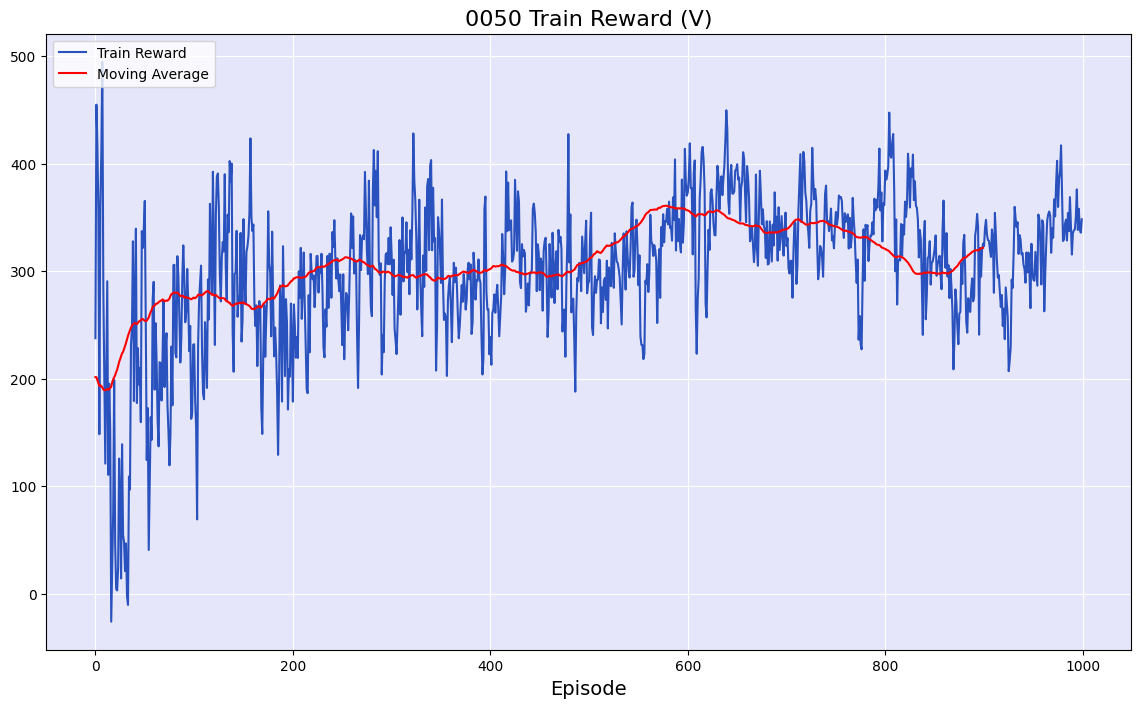

In [38]:
x = []
y = []
xm = []
ym = []
window_size = 100

for i in range(0, len(train_reward_list), 1):
    x.append(i)
    
for j in range(0, len(train_reward_list) - window_size, 1):
    xm.append(j)
    target = np.mean(train_reward_list[j:j+window_size])
    ym.append(target)
    
plt.figure(figsize=(14,8))
plt.plot(x, train_reward_list, label='Train Reward', color='#2A52BE')
plt.plot(xm, ym, label='Moving Average', color='red')

plt.legend(loc='upper left')
plt.xlabel('Episode', fontsize=14)
plt.title(stock_code + ' Train Reward (V)', fontsize=16)

plt.gca().set_facecolor('#E6E6FA')
plt.grid(color='white')

plt.savefig(stock_code + '_train_reward_pic_V.jpg', dpi=300)
plt.show()

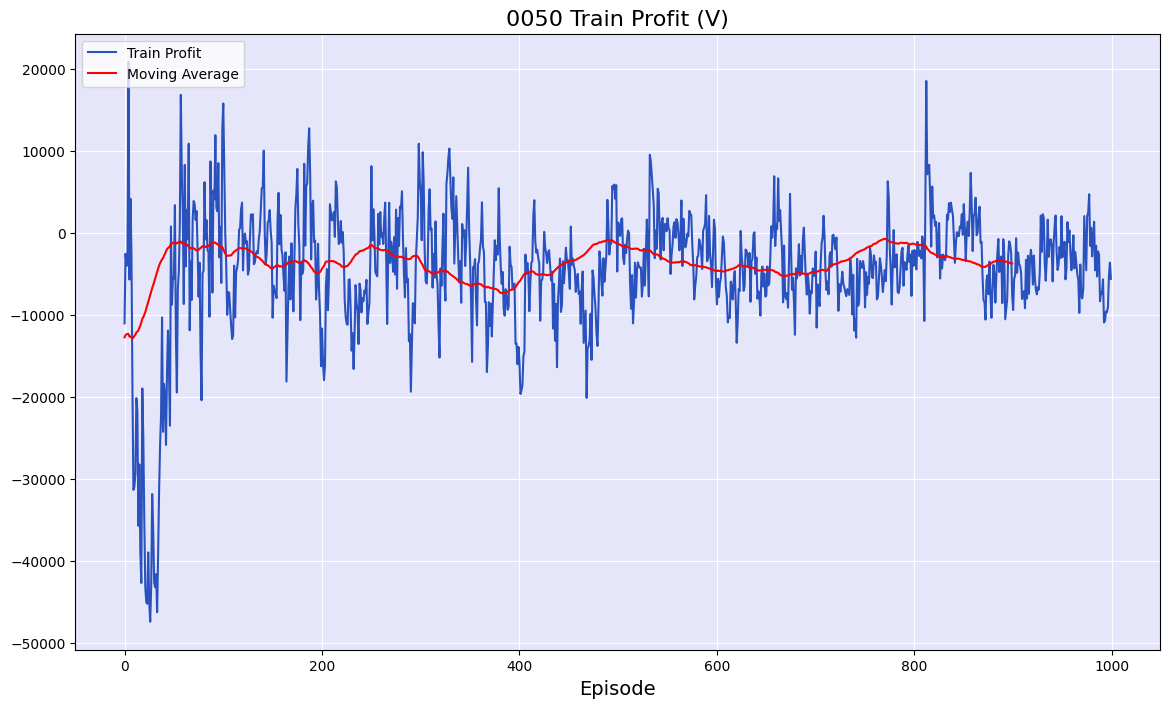

In [39]:
x = []
y = []
xm = []
ym = []
window_size = 100

for i in range(0, len(profit_list), 1):
    x.append(i)
    
for j in range(0, len(profit_list) - window_size, 1):
    xm.append(j)
    target = np.mean(profit_list[j:j+window_size])
    ym.append(target)
    
plt.figure(figsize=(14,8))
plt.plot(x, profit_list, label='Train Profit', color='#2A52BE')
plt.plot(xm, ym, label='Moving Average', color='red')

plt.legend(loc='upper left')
plt.xlabel('Episode', fontsize=14)
plt.title(stock_code + ' Train Profit (V)', fontsize=16)

plt.gca().set_facecolor('#E6E6FA')
plt.grid(color='white')

plt.savefig(stock_code + '_train_profit_pic_V.jpg', dpi=300)
plt.show()